In [1]:
import sys
sys.path.append('..')

import os
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import gaussian, threshold_otsu
from skimage.transform import resize
from skimage import io
import pickle
from skimage.measure import regionprops

import matplotlib.pyplot as plt
import torch
import time
import model.model_cnnvae_conditional
import model.optimizer as optimizer
from sklearn.decomposition import PCA
import pandas as pd
import torchvision

In [2]:
prevSampled=0
nSamples=36
nProt=6
holdOutSamples_samples=[['HV1','P22','P14','P27'],['HV3','P46','P24','P37'],['HV5','P68','P44','P42'],['HV7','P15','P55','P59'],['HV8','P47','P63','P70'],['HV2','P57','P72','P83']]

In [3]:
sourceDir='/data/xinyi/c2p/data/chromark'
segDir=os.path.join(sourceDir,'nuclear_masks')
imgDir=os.path.join(sourceDir,'raw_data')
conditions=['controls','headneck','meningioma', 'glioma']

outSize=128
savename='pathCentered_'+str(outSize)


In [5]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

In [6]:
name_train='conditionClf_lord_sampling'
modelname_train='resnet18'
logsavepath_train=os.path.join('/data/xinyi/c2p/log/',modelname_train,name_train)
modelsavepath_train=os.path.join('/data/xinyi/c2p/models/',modelname_train,name_train)
plotsavepath_train=os.path.join('/data/xinyi/c2p/plots/',modelname_train,name_train)
if not os.path.exists(os.path.join('/data/xinyi/c2p/log/',modelname_train)):
    os.mkdir(os.path.join('/data/xinyi/c2p/log/',modelname_train))
    os.mkdir(os.path.join('/data/xinyi/c2p/models/',modelname_train))
    os.mkdir(os.path.join('/data/xinyi/c2p/plots/',modelname_train))
if not os.path.exists(logsavepath_train):
    os.mkdir(logsavepath_train)
if not os.path.exists(modelsavepath_train):
    os.mkdir(modelsavepath_train)
if not os.path.exists(plotsavepath_train):
    os.mkdir(plotsavepath_train)

In [7]:
def train(epoch,model_clf,optimizer_clf,inputImgs,inputImgs_val,labels_train,labels_val):
    np.random.seed(3)
    train_nodes_idx=np.arange(labels_train.size()[0])
    val_nodes_idx=np.arange(labels_val.size()[0])
    np.random.shuffle(train_nodes_idx)
    t = time.time()
    model_clf.train()
    loss_all=0
    
    ntrainBatches=int(np.ceil(train_nodes_idx.shape[0]/batchsize))
    for i in range(ntrainBatches):
#         if i%200==0:
#             print(i)
        trainIdx=train_nodes_idx[i*batchsize:min((i+1)*batchsize,train_nodes_idx.shape[0])]
        train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
        trainInput=torch.tensor(inputImgs[trainIdx]).cuda().float()

        optimizer_clf.zero_grad()

        pred = model_clf(trainInput)

        loss=loss_clf(pred, train_labels)
        loss_all+=loss.item()
            
        loss.backward()
        optimizer_clf.step()

    loss_all=loss_all/ntrainBatches
    
    with torch.no_grad():
        model_clf.eval()
        loss_val_all=0
        nvalBatches=int(np.ceil(val_nodes_idx.shape[0]/batchsize))
        for i in range(nvalBatches):
            valIdx=val_nodes_idx[i*batchsize:min((i+1)*batchsize,val_nodes_idx.shape[0])]
            val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
            valInput=torch.tensor(inputImgs_val[valIdx]).cuda().float()


            pred = model_clf(valInput)

            loss=loss_clf(pred, val_labels)
            loss_val_all+=loss.item()

        loss_val_all=loss_val_all/nvalBatches
    if epoch%10==0:
        print(' Epoch: {:04d}'.format(epoch),
              'loss_train: {:.4f}'.format(loss_all),
              'loss_val: {:.4f}'.format(loss_val_all),
              'time: {:.4f}s'.format(time.time() - t))
    return loss_all,loss_val_all


In [8]:
def plotCTcomp(labels,ctlist,savepath,savenamecluster,byCT,addname='',ctorder=None,vmin=None,vmax=None):
    if ctorder is None:
        ctorder=np.unique(ctlist)
    res=np.zeros((np.unique(labels).size,ctorder.size))
    for li in range(res.shape[0]):
        l=np.unique(labels)[li]
        nl=np.sum(labels==l)
        ctlist_l=ctlist[labels==l]
        for ci in range(res.shape[1]):
            c=ctorder[ci]
            res[li,ci]=np.sum(ctlist_l==c)
#             res[li,ci]=np.sum(ctlist_l==c)/nl
    if not byCT:
        addname+=''
        for li in range(res.shape[0]):
            l=np.unique(labels)[li]
            nl=np.sum(labels==l)
            res[li]=res[li]/nl
    else:
        addname+='_normbyCT'
        for ci in range(res.shape[1]):
            c=ctorder[ci]
            nc=np.sum(ctlist==c)
            res[:,ci]=res[:,ci]/nc
    
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(res,cmap='binary',vmin=vmin,vmax=vmax)
    ax.set_yticks(np.arange(np.unique(labels).size))
    ax.set_yticklabels(np.unique(labels))
    ax.set_xticks(np.arange(ctorder.size))
    ax.set_xticklabels(ctorder)
    resplot=np.around(res,3)
    for i in range(resplot.shape[0]):
        for j in range(resplot.shape[1]):
            text = ax.text(j, i, resplot[i, j],
                           ha="center", va="center", color="r")
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    fig.colorbar(im)
    fig.tight_layout()
    plt.savefig(os.path.join(savepath,savenamecluster+addname+'.pdf'))
    plt.close()
    return res

### load lord

In [9]:
sharedSizes=[1024]
dSpecific_filter=[(200,16)]
pID_type='randInit'
pIDemb_size=64

#VAE settings
seed=3
epochs=5001
saveFreq=100
lr=0.001 #initial learning rate
weight_decay=0 #Weight for L2 loss on embedding matrix.

# batchsize=4
batchsize=256
kernel_size=4
stride=2
padding=1

# fc_dim1=6000
hidden1=64 #Number of channels in hidden layer 1
hidden2=128 
hidden3=256
hidden4=256
hidden5=96
hidden5_xy=4
fc_dim1=96*hidden5_xy*hidden5_xy
fc_dim2=6000

dropout=0.01
kl_weight=0.0000001


name_lord='splitChannels_conditional_lord_withNoise_bce'
modelname_lord='cnn_vae_pbmc_lord'
logsavepath_lord=os.path.join('/data/xinyi/c2p/log/',modelname_lord,name_lord)
modelsavepath_lord=os.path.join('/data/xinyi/c2p/models/',modelname_lord,name_lord)
plotsavepath_lord=os.path.join('/data/xinyi/c2p/plots/',modelname_lord,name_lord)

loadEpoch='3399'
loadEpoch_decoder=372

logsavepath_p_dna=os.path.join(logsavepath_lord,'dna')
modelsavepath_p_dna=os.path.join(modelsavepath_lord,'dna')
plotsavepath_p_dna=os.path.join(plotsavepath_lord,'dna')

logsavepath_p_protein=os.path.join(logsavepath_lord,'protein')
modelsavepath_p_protein=os.path.join(modelsavepath_lord,'protein')
plotsavepath_p_protein=os.path.join(plotsavepath_lord,'protein')

currLatentSize=sharedSizes[0]
dSpecificSize,dfilterSize=dSpecific_filter[0]

dna_cShared=hidden5-dfilterSize
p_cShared=dna_cShared

if modelname_lord=='cnn_vae_pbmc_lord':
    modelcnn_dna_dec = model.model_cnnvae_conditional.CNN_VAE_decode_pIDemb(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,currLatentSize+dSpecificSize,pIDemb_size)
    modelcnn_protein_dec = model.model_cnnvae_conditional.CNN_VAE_decode_pIDemb(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,currLatentSize+dSpecificSize,pIDemb_size)
    modelcnn_dnaShared_dec=model.model_cnnvae_conditional.CNN_VAE_decode_pIDemb(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,currLatentSize,pIDemb_size)
    modelcnn_pShared_dec=model.model_cnnvae_conditional.CNN_VAE_decode_pIDemb(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,currLatentSize,pIDemb_size)
modelcnn_dna_dec.cuda().eval()
modelcnn_protein_dec.cuda().eval()
modelcnn_dnaShared_dec.cuda().eval()
modelcnn_pShared_dec.cuda().eval()

batchsize=328
pIDemb_dec=torch.nn.Embedding(nProt, pIDemb_size).cuda()


with open(os.path.join(modelsavepath_p_protein,'pIDemb_'+str(currLatentSize)+'_'+str(dSpecificSize)+'_'+str(loadEpoch)), 'rb') as output:
    pIDemb_dec.weight=pickle.load(output)

with open(os.path.join(modelsavepath_p_dna,'stateDict_'+str(currLatentSize)+'_'+str(dSpecificSize)), 'rb') as output:
    stateDict_train_dna_dec=pickle.load(output)
with open(os.path.join(modelsavepath_p_protein,'stateDict_'+str(currLatentSize)+'_'+str(dSpecificSize)), 'rb') as output:
    stateDict_train_protein_dec=pickle.load(output)
with open(os.path.join(modelsavepath_p_dna,'stateDictShared_'+str(currLatentSize)+'_'+str(dSpecificSize)), 'rb') as output:
    stateDict_train_dnaShared_dec=pickle.load(output)
with open(os.path.join(modelsavepath_p_protein,'stateDictShared_'+str(currLatentSize)+'_'+str(dSpecificSize)), 'rb') as output:
    stateDict_train_proteinShared_dec=pickle.load(output)

modelcnn_dna_dec.load_state_dict(stateDict_train_dna_dec[int(loadEpoch)])
modelcnn_dnaShared_dec.load_state_dict(stateDict_train_dnaShared_dec[int(loadEpoch)])
modelcnn_protein_dec.load_state_dict(stateDict_train_protein_dec[int(loadEpoch)])
modelcnn_pShared_dec.load_state_dict(stateDict_train_proteinShared_dec[int(loadEpoch)])
pIDemb_dec.weight.requires_grad=False

with open(os.path.join(modelsavepath_p_dna,'stateDict_encode_'+str(currLatentSize)+'_'+str(dSpecificSize)), 'rb') as output:
    stateDict_train_dna=pickle.load( output)
with open(os.path.join(modelsavepath_p_protein,'stateDict_encode_'+str(currLatentSize)+'_'+str(dSpecificSize)), 'rb') as output:
    stateDict_train_protein=pickle.load(output)

if modelname_lord=='cnn_vae_pbmc_lord':
    modelcnn_dna = model.model_cnnvae_conditional.CNN_VAE_split_encode_pIDemb(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5,p_cShared,dna_cShared*hidden5_xy*hidden5_xy, (hidden5-p_cShared)*hidden5_xy*hidden5_xy,currLatentSize,dSpecificSize,nProt,'randInit',pIDemb_size)
    modelcnn_protein = model.model_cnnvae_conditional.CNN_VAE_split_encode_pIDemb(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5,p_cShared,p_cShared*hidden5_xy*hidden5_xy, (hidden5-p_cShared)*hidden5_xy*hidden5_xy,currLatentSize,dSpecificSize,nProt,'randInit',pIDemb_size)
modelcnn_dna.cuda()
modelcnn_protein.cuda()
modelcnn_dna.load_state_dict(stateDict_train_dna[loadEpoch_decoder])
modelcnn_protein.load_state_dict(stateDict_train_protein[loadEpoch_decoder])




<All keys matched successfully>

In [10]:
modelcnn_dna.eval()
modelcnn_protein.eval()

CNN_VAE_split_encode_pIDemb(
  (pIDemb): Embedding(6, 64)
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(256, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=

### train classifier

In [11]:
seed=3
epochs=5001
saveFreq=50
lr=0.0001
weight_decay=0 #Weight for L2 loss on embedding matrix.

batchsize=256

18
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
hold out: HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
hold out: HV1
HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
hold out: P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
P59
hold out: P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
hold out: P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
hold out: P22
P68
P16
P84
P15
18
cd16
4555


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1597 loss_val: 1.0993 time: 4.5831s
 Epoch: 0010 loss_train: 0.2678 loss_val: 1.7491 time: 4.9360s
 Epoch: 0020 loss_train: 0.0239 loss_val: 3.0202 time: 6.7188s
 Epoch: 0030 loss_train: 0.0188 loss_val: 2.8088 time: 6.8093s
 Epoch: 0040 loss_train: 0.0555 loss_val: 3.3776 time: 5.4689s
 Epoch: 0050 loss_train: 0.0006 loss_val: 2.3767 time: 5.8356s
 Epoch: 0060 loss_train: 0.0003 loss_val: 2.3936 time: 8.1668s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.4123 time: 7.0396s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.4301 time: 7.7006s
 Epoch: 0090 loss_train: 0.0001 loss_val: 2.4470 time: 6.1947s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.4633 time: 8.2576s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.4788 time: 8.5474s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.4938 time: 6.0609s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.5086 time: 6.8247s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.5226 time: 6.8255s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.5368 time: 

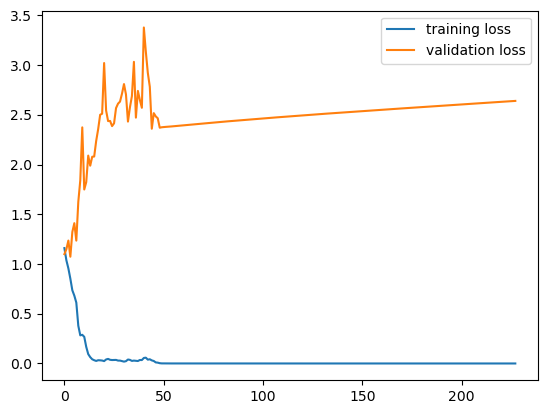

cd3
3760


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0653 loss_val: 1.1076 time: 6.5581s
 Epoch: 0010 loss_train: 0.0081 loss_val: 1.3133 time: 7.0290s
 Epoch: 0020 loss_train: 0.0009 loss_val: 1.1305 time: 5.4894s
 Epoch: 0030 loss_train: 0.0005 loss_val: 1.1681 time: 7.2011s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.2216 time: 6.6619s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.2426 time: 5.9311s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.2612 time: 4.6972s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.2780 time: 6.2119s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.2934 time: 6.0874s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.3078 time: 5.9303s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.3213 time: 5.5150s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.3342 time: 5.9131s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.3463 time: 5.7511s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.3580 time: 5.5184s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.3691 time: 4.8421s
 Epoch: 0160 loss_train: 0.0000 loss_val: 1.3800 time: 

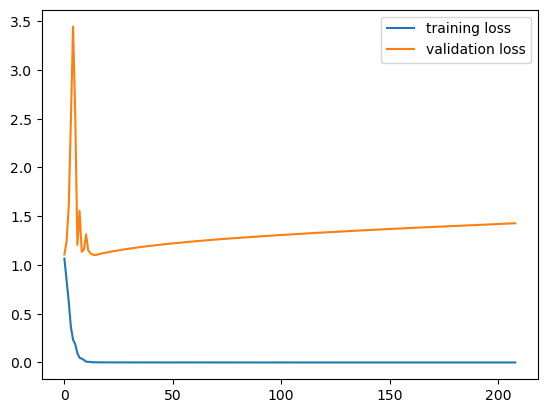

cd4
5580


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.3029 loss_val: 1.4583 time: 7.9865s
 Epoch: 0010 loss_train: 0.0709 loss_val: 1.8597 time: 8.2511s
 Epoch: 0020 loss_train: 0.0047 loss_val: 1.8919 time: 7.5507s
 Epoch: 0030 loss_train: 0.0021 loss_val: 1.9567 time: 9.4386s
 Epoch: 0040 loss_train: 0.0015 loss_val: 2.0149 time: 8.3371s
 Epoch: 0050 loss_train: 0.0013 loss_val: 2.0588 time: 8.1734s
 Epoch: 0060 loss_train: 0.0012 loss_val: 2.0960 time: 7.6302s
 Epoch: 0070 loss_train: 0.0010 loss_val: 2.1324 time: 7.4428s
 Epoch: 0080 loss_train: 0.0009 loss_val: 2.1639 time: 7.3636s
 Epoch: 0090 loss_train: 0.0008 loss_val: 2.1960 time: 9.1605s
 Epoch: 0100 loss_train: 0.0008 loss_val: 2.2353 time: 9.3143s
 Epoch: 0110 loss_train: 0.0008 loss_val: 2.2658 time: 6.8060s
 Epoch: 0120 loss_train: 0.0007 loss_val: 2.2929 time: 9.1745s
 Epoch: 0130 loss_train: 0.0013 loss_val: 2.4151 time: 8.6181s
 Epoch: 0140 loss_train: 0.0912 loss_val: 2.2406 time: 8.2738s
 Epoch: 0150 loss_train: 0.0031 loss_val: 2.2495 time: 

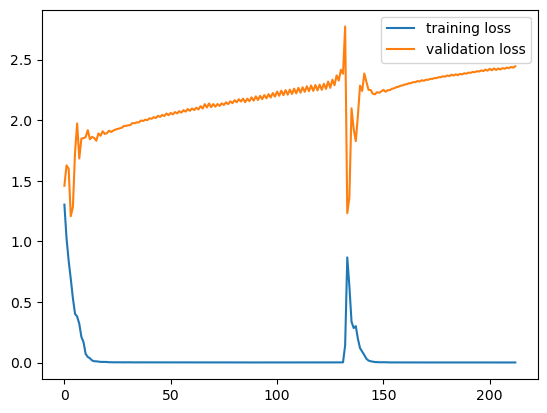

cd8
5604


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2521 loss_val: 1.7391 time: 4.7332s
 Epoch: 0010 loss_train: 0.0645 loss_val: 1.8127 time: 7.9214s
 Epoch: 0020 loss_train: 0.0046 loss_val: 1.9366 time: 7.7022s
 Epoch: 0030 loss_train: 0.0010 loss_val: 1.9371 time: 6.1993s
 Epoch: 0040 loss_train: 0.0005 loss_val: 1.9815 time: 8.0672s
 Epoch: 0050 loss_train: 0.0004 loss_val: 2.0235 time: 7.5620s
 Epoch: 0060 loss_train: 0.0003 loss_val: 2.0596 time: 8.0194s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.0918 time: 7.9039s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.1214 time: 7.8540s
 Epoch: 0090 loss_train: 0.0001 loss_val: 2.1486 time: 8.4306s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.1743 time: 7.9604s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.1986 time: 8.4620s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.2218 time: 6.6570s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.2444 time: 8.5566s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.2662 time: 8.0211s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.2873 time: 

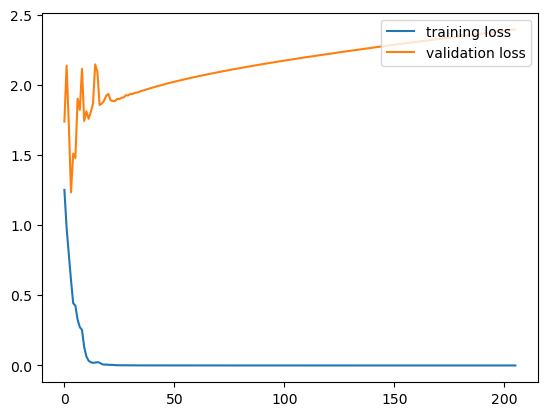

gh2ax
4837


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2842 loss_val: 1.5711 time: 6.7321s
 Epoch: 0010 loss_train: 0.0069 loss_val: 1.3166 time: 6.7414s
 Epoch: 0020 loss_train: 0.0008 loss_val: 1.2669 time: 7.4395s
 Epoch: 0030 loss_train: 0.0005 loss_val: 1.2997 time: 6.9389s
 Epoch: 0040 loss_train: 0.0003 loss_val: 1.3259 time: 7.9371s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.3482 time: 6.1687s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.3678 time: 6.5823s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.3855 time: 6.7672s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.4018 time: 7.2137s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.4169 time: 6.6407s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.4312 time: 6.8128s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.4446 time: 6.9476s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.4575 time: 5.2922s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.4699 time: 5.2200s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.4818 time: 5.6286s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.4934 time: 

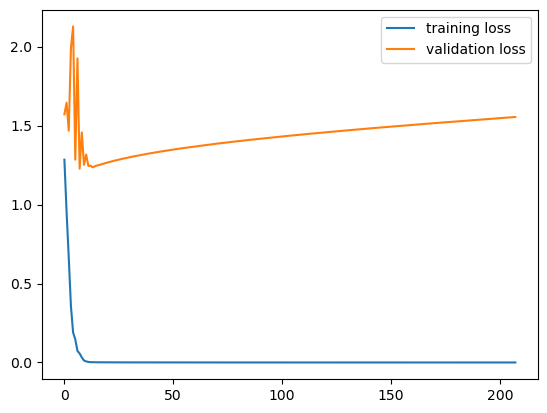

lamin
4838


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.3364 loss_val: 1.3786 time: 8.0204s
 Epoch: 0010 loss_train: 0.0314 loss_val: 1.3576 time: 7.1355s
 Epoch: 0020 loss_train: 0.0115 loss_val: 1.3886 time: 7.1575s
 Epoch: 0030 loss_train: 0.0009 loss_val: 1.3537 time: 6.9363s
 Epoch: 0040 loss_train: 0.0004 loss_val: 1.3761 time: 7.8871s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.3953 time: 7.4437s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.4120 time: 8.3336s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.4271 time: 7.0361s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.4411 time: 8.1928s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.4544 time: 8.4203s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.4668 time: 7.0155s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.4787 time: 7.6216s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.4901 time: 5.6388s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.5010 time: 6.2249s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.5117 time: 8.2334s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.5221 time: 

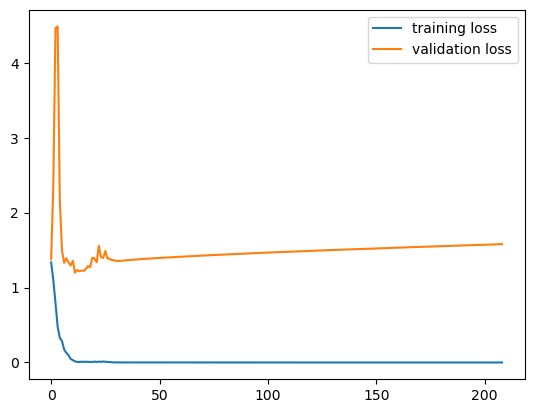

19
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
hold out: HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
hold out: HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
P55
P50
hold out: P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
P63
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
hold out: P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
hold out: P46
P47
P29
P52
P57
P22
P68
P16
P84
P15
19
cd16
4490


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1436 loss_val: 1.1078 time: 7.3715s
 Epoch: 0010 loss_train: 0.1419 loss_val: 2.5701 time: 6.8881s
 Epoch: 0020 loss_train: 0.0295 loss_val: 2.2503 time: 7.4202s
 Epoch: 0030 loss_train: 0.0006 loss_val: 2.1512 time: 6.6440s
 Epoch: 0040 loss_train: 0.0004 loss_val: 2.1859 time: 5.9362s
 Epoch: 0050 loss_train: 0.0003 loss_val: 2.2157 time: 6.2854s
 Epoch: 0060 loss_train: 0.0002 loss_val: 2.2423 time: 4.3596s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.2664 time: 7.0315s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.2888 time: 7.0808s
 Epoch: 0090 loss_train: 0.0001 loss_val: 2.3100 time: 7.9256s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.3301 time: 5.5162s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.3493 time: 6.8552s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.3677 time: 8.6484s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.3858 time: 8.3449s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.4034 time: 7.1158s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.4205 time: 

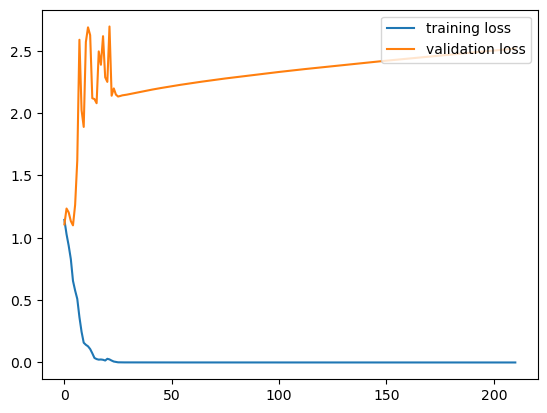

cd3
3802


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1177 loss_val: 1.0903 time: 6.0733s
 Epoch: 0010 loss_train: 0.0167 loss_val: 1.1906 time: 6.9747s
 Epoch: 0020 loss_train: 0.0010 loss_val: 1.0649 time: 5.6729s
 Epoch: 0030 loss_train: 0.0006 loss_val: 1.0913 time: 6.5436s
 Epoch: 0040 loss_train: 0.0004 loss_val: 1.1133 time: 5.8251s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.1321 time: 6.1871s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.1485 time: 5.1408s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.1632 time: 4.8407s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.1767 time: 6.0512s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.1890 time: 4.3486s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.2005 time: 5.2808s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.2113 time: 5.2920s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.2215 time: 4.3417s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.2314 time: 4.6174s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.2408 time: 6.8882s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.2499 time: 

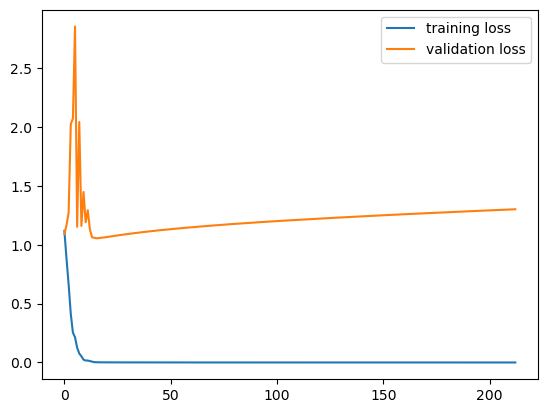

cd4
5518


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.3286 loss_val: 1.4500 time: 7.6288s
 Epoch: 0010 loss_train: 0.1216 loss_val: 1.9445 time: 7.9558s
 Epoch: 0020 loss_train: 0.0015 loss_val: 1.9114 time: 8.0935s
 Epoch: 0030 loss_train: 0.0007 loss_val: 1.9821 time: 7.9953s
 Epoch: 0040 loss_train: 0.0005 loss_val: 2.0342 time: 6.9519s
 Epoch: 0050 loss_train: 0.0003 loss_val: 2.0765 time: 8.3617s
 Epoch: 0060 loss_train: 0.0003 loss_val: 2.1131 time: 8.4433s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.1458 time: 7.8354s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.1755 time: 6.5723s
 Epoch: 0090 loss_train: 0.0001 loss_val: 2.2029 time: 7.1845s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.2288 time: 6.6975s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.2530 time: 8.5604s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.2761 time: 7.4522s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.2986 time: 7.4917s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.3201 time: 6.3709s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.3411 time: 

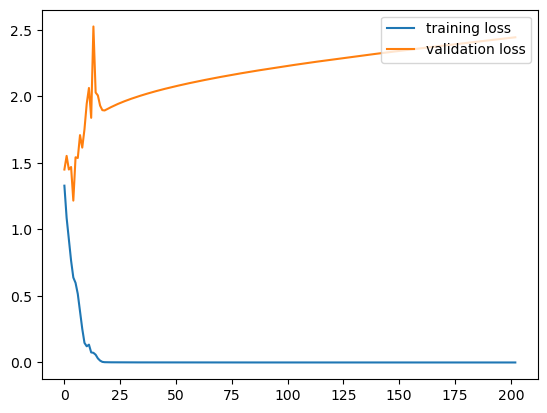

cd8
5545


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2872 loss_val: 1.6512 time: 8.4235s
 Epoch: 0010 loss_train: 0.0895 loss_val: 2.2458 time: 7.5220s
 Epoch: 0020 loss_train: 0.0013 loss_val: 1.8112 time: 9.2152s
 Epoch: 0030 loss_train: 0.0007 loss_val: 1.8773 time: 9.4972s
 Epoch: 0040 loss_train: 0.0005 loss_val: 1.9269 time: 9.8400s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.9676 time: 6.8721s
 Epoch: 0060 loss_train: 0.0003 loss_val: 2.0025 time: 10.0115s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.0334 time: 5.2895s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.0616 time: 6.1468s
 Epoch: 0090 loss_train: 0.0001 loss_val: 2.0876 time: 7.9876s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.1123 time: 7.8245s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.1354 time: 8.7950s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.1576 time: 9.8679s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.1789 time: 7.1422s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.1994 time: 9.7137s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.2195 time:

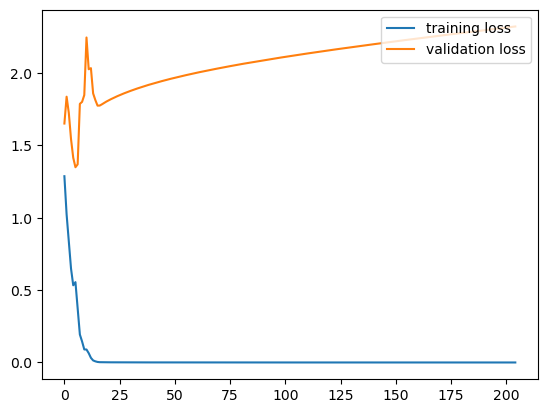

gh2ax
4931


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2641 loss_val: 1.6875 time: 5.5560s
 Epoch: 0010 loss_train: 0.0068 loss_val: 1.2211 time: 8.0168s
 Epoch: 0020 loss_train: 0.0009 loss_val: 1.2571 time: 8.1118s
 Epoch: 0030 loss_train: 0.0005 loss_val: 1.2880 time: 4.9960s
 Epoch: 0040 loss_train: 0.0004 loss_val: 1.3129 time: 7.4164s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.3343 time: 7.9493s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.3532 time: 6.9274s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.3703 time: 8.1605s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.3860 time: 6.7570s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.4006 time: 7.5045s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.4143 time: 6.6648s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.4274 time: 6.7462s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.4400 time: 7.3644s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.4521 time: 7.1661s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.4638 time: 6.0217s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.4750 time: 

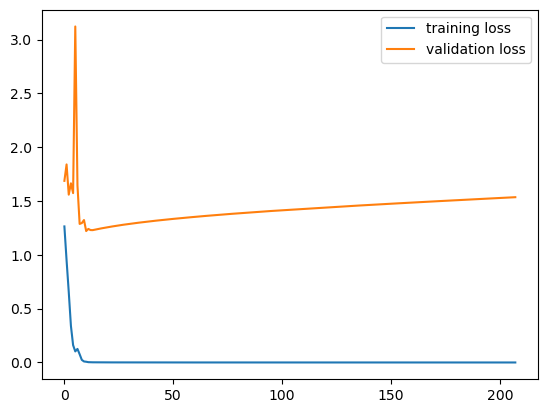

lamin
4932


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.3198 loss_val: 1.4356 time: 6.1712s
 Epoch: 0010 loss_train: 0.0240 loss_val: 1.1663 time: 8.1667s
 Epoch: 0020 loss_train: 0.0026 loss_val: 1.1795 time: 7.6204s
 Epoch: 0030 loss_train: 0.0007 loss_val: 1.2156 time: 7.2347s
 Epoch: 0040 loss_train: 0.0005 loss_val: 1.2401 time: 7.6381s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.2610 time: 7.5926s
 Epoch: 0060 loss_train: 0.0003 loss_val: 1.2796 time: 6.0731s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.2962 time: 7.3442s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.3115 time: 8.2406s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.3258 time: 7.1021s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.3391 time: 6.5163s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.3518 time: 8.4441s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.3639 time: 7.1881s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.3756 time: 7.0865s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.3867 time: 6.7437s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.3975 time: 

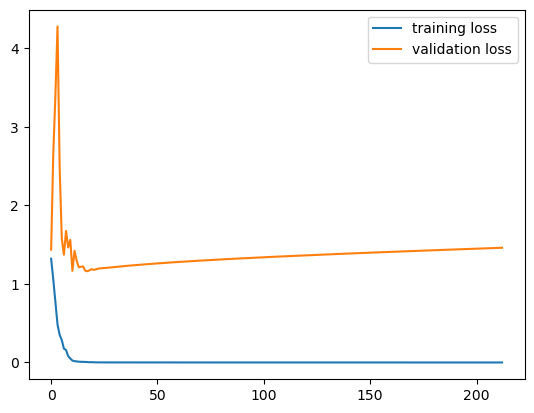

20
controls
dapi_gh2ax_lamin
hold out: HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
hold out: HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
hold out: P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
hold out: P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
hold out: P68
P16
P84
P15
20
cd16
4629


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1479 loss_val: 1.1014 time: 7.1692s
 Epoch: 0010 loss_train: 0.2110 loss_val: 1.9005 time: 6.0889s
 Epoch: 0020 loss_train: 0.0122 loss_val: 2.2421 time: 7.1636s
 Epoch: 0030 loss_train: 0.0016 loss_val: 2.2074 time: 6.7988s
 Epoch: 0040 loss_train: 0.0011 loss_val: 2.2567 time: 6.6457s
 Epoch: 0050 loss_train: 0.0009 loss_val: 2.2949 time: 7.3884s
 Epoch: 0060 loss_train: 0.0007 loss_val: 2.3284 time: 5.3977s
 Epoch: 0070 loss_train: 0.0007 loss_val: 2.3585 time: 6.3514s
 Epoch: 0080 loss_train: 0.0012 loss_val: 2.3776 time: 6.8700s
 Epoch: 0090 loss_train: 0.0005 loss_val: 2.4083 time: 7.2095s
 Epoch: 0100 loss_train: 0.0005 loss_val: 2.4350 time: 5.9664s
 Epoch: 0110 loss_train: 0.0005 loss_val: 2.4583 time: 5.3036s
 Epoch: 0120 loss_train: 0.0006 loss_val: 2.4860 time: 6.8361s
 Epoch: 0130 loss_train: 0.0004 loss_val: 2.5017 time: 7.7955s
 Epoch: 0140 loss_train: 0.0005 loss_val: 2.5257 time: 6.2078s
 Epoch: 0160 loss_train: 0.1613 loss_val: 3.7100 time: 

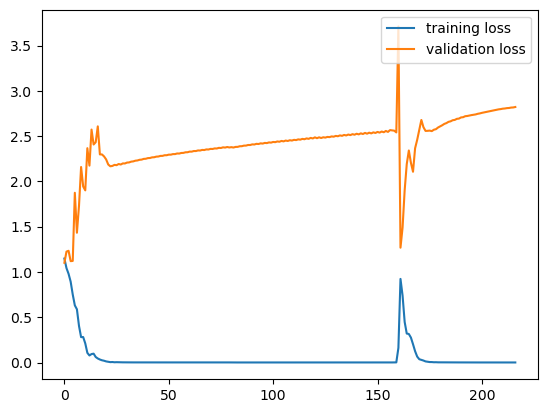

cd3
3806


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0771 loss_val: 1.0960 time: 5.6761s
 Epoch: 0010 loss_train: 0.0301 loss_val: 1.4250 time: 6.0882s
 Epoch: 0020 loss_train: 0.0355 loss_val: 1.6230 time: 6.0397s
 Epoch: 0030 loss_train: 0.0049 loss_val: 1.5226 time: 5.9612s
 Epoch: 0040 loss_train: 0.0004 loss_val: 1.5096 time: 7.4001s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.5216 time: 5.1867s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.5330 time: 4.4764s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.5436 time: 5.5069s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.5535 time: 4.3673s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.5631 time: 5.7541s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.5724 time: 6.5166s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.5812 time: 6.2156s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.5900 time: 3.2565s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.5985 time: 5.6531s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.6068 time: 4.2933s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.6149 time: 

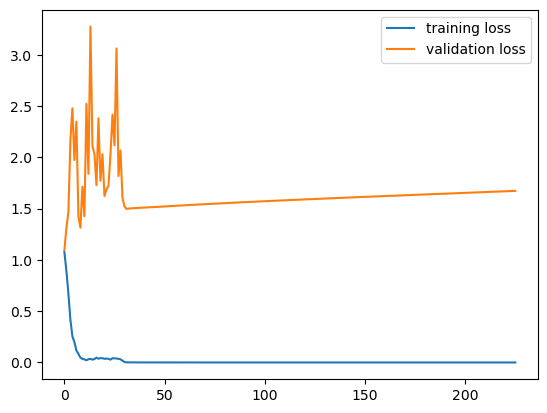

cd4
5663


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.3313 loss_val: 1.5166 time: 9.9046s
 Epoch: 0010 loss_train: 0.2081 loss_val: 2.0729 time: 7.7925s
 Epoch: 0020 loss_train: 0.0084 loss_val: 1.9490 time: 9.4705s
 Epoch: 0030 loss_train: 0.0020 loss_val: 2.0339 time: 8.1715s
 Epoch: 0040 loss_train: 0.0016 loss_val: 2.1142 time: 8.4771s
 Epoch: 0050 loss_train: 0.0009 loss_val: 2.1419 time: 8.8452s
 Epoch: 0060 loss_train: 0.0007 loss_val: 2.1826 time: 6.5731s
 Epoch: 0070 loss_train: 0.0006 loss_val: 2.2163 time: 6.4014s
 Epoch: 0080 loss_train: 0.0007 loss_val: 2.2473 time: 8.7572s
 Epoch: 0090 loss_train: 0.2158 loss_val: 2.7400 time: 7.4572s
 Epoch: 0100 loss_train: 0.0027 loss_val: 2.1833 time: 7.5369s
 Epoch: 0110 loss_train: 0.0011 loss_val: 2.2564 time: 6.8191s
 Epoch: 0120 loss_train: 0.0007 loss_val: 2.3159 time: 7.3899s
 Epoch: 0130 loss_train: 0.0006 loss_val: 2.3567 time: 8.0001s
 Epoch: 0140 loss_train: 0.0005 loss_val: 2.3860 time: 9.0349s
 Epoch: 0150 loss_train: 0.0005 loss_val: 2.4187 time: 

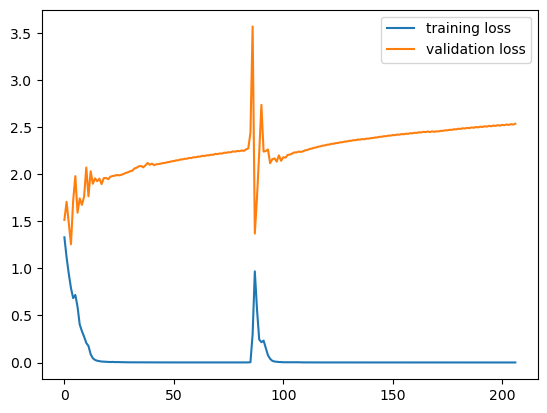

cd8
5687


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2891 loss_val: 1.6568 time: 9.0225s
 Epoch: 0010 loss_train: 0.0888 loss_val: 1.8388 time: 6.8902s
 Epoch: 0020 loss_train: 0.0019 loss_val: 1.9297 time: 8.1499s
 Epoch: 0030 loss_train: 0.0008 loss_val: 2.0009 time: 8.0819s
 Epoch: 0040 loss_train: 0.0005 loss_val: 2.0573 time: 6.8168s
 Epoch: 0050 loss_train: 0.0004 loss_val: 2.1025 time: 6.9565s
 Epoch: 0060 loss_train: 0.0003 loss_val: 2.1411 time: 9.5299s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.1751 time: 8.0515s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.2061 time: 8.5100s
 Epoch: 0090 loss_train: 0.0001 loss_val: 2.2347 time: 7.3803s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.2616 time: 9.1426s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.2868 time: 6.8984s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.3110 time: 8.4480s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.3344 time: 7.3641s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.3566 time: 8.8756s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.3785 time: 

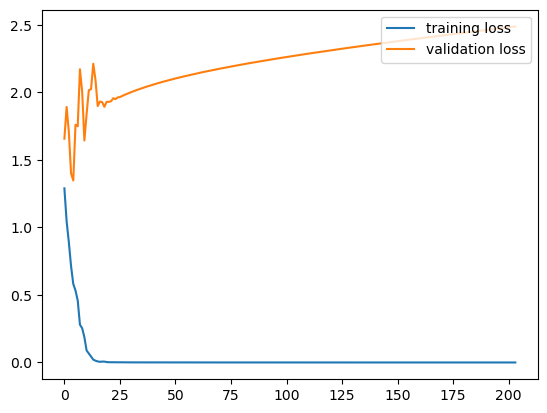

gh2ax
4889


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.3070 loss_val: 1.6214 time: 6.0300s
 Epoch: 0010 loss_train: 0.0032 loss_val: 1.3498 time: 7.5324s
 Epoch: 0020 loss_train: 0.0010 loss_val: 1.3997 time: 6.0264s
 Epoch: 0030 loss_train: 0.0006 loss_val: 1.4428 time: 6.6762s
 Epoch: 0040 loss_train: 0.0004 loss_val: 1.4762 time: 7.0890s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.5040 time: 7.9434s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.5281 time: 7.0456s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.5497 time: 7.0533s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.5693 time: 6.6753s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.5874 time: 6.9704s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.6045 time: 6.5186s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.6205 time: 6.6372s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.6357 time: 6.6625s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.6503 time: 6.5365s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.6644 time: 7.8644s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.6781 time: 

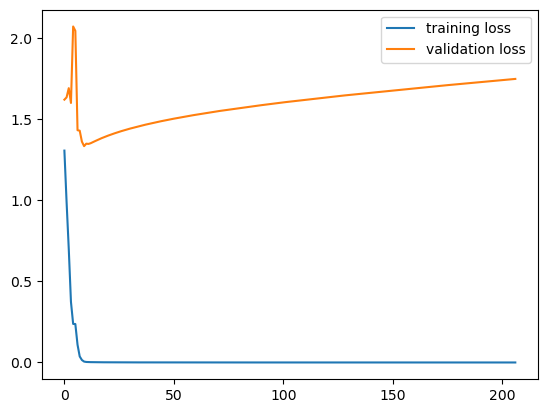

lamin
4890


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.3482 loss_val: 1.3637 time: 6.6447s
 Epoch: 0010 loss_train: 0.0354 loss_val: 1.2699 time: 7.1427s
 Epoch: 0020 loss_train: 0.0024 loss_val: 1.3163 time: 7.9934s
 Epoch: 0030 loss_train: 0.0007 loss_val: 1.3579 time: 5.0119s
 Epoch: 0040 loss_train: 0.0005 loss_val: 1.3869 time: 5.7600s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.4114 time: 5.6037s
 Epoch: 0060 loss_train: 0.0003 loss_val: 1.4327 time: 6.8375s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.4520 time: 7.5728s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.4693 time: 6.2362s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.4855 time: 7.5495s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.5006 time: 7.3080s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.5149 time: 6.5137s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.5284 time: 5.3671s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.5415 time: 5.0208s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.5541 time: 7.8663s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.5662 time: 

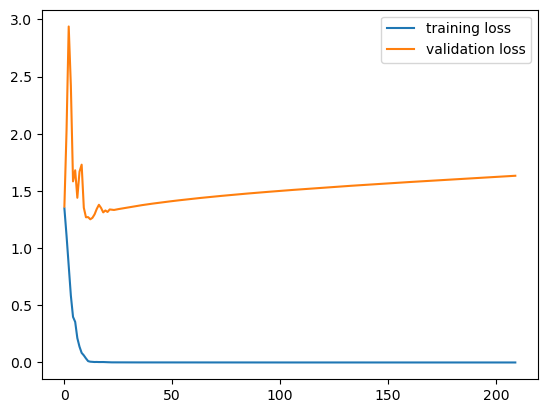

21
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
hold out: HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
hold out: HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
hold out: P55
P50
P24
dapi_cd16_cd4_cd8
hold out: P55
P56
P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
hold out: P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
hold out: P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
hold out: P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
P68
P16
P84
hold out: P15
21
cd16
4560


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1780 loss_val: 1.0989 time: 7.3033s
 Epoch: 0010 loss_train: 0.2846 loss_val: 1.7470 time: 7.1350s
 Epoch: 0020 loss_train: 0.0042 loss_val: 1.9980 time: 4.9597s
 Epoch: 0030 loss_train: 0.0015 loss_val: 2.0722 time: 8.0569s
 Epoch: 0040 loss_train: 0.0012 loss_val: 2.1274 time: 7.3057s
 Epoch: 0050 loss_train: 0.0010 loss_val: 2.1692 time: 5.1706s
 Epoch: 0060 loss_train: 0.0011 loss_val: 2.2023 time: 6.8831s
 Epoch: 0070 loss_train: 0.0007 loss_val: 2.2335 time: 6.8602s
 Epoch: 0080 loss_train: 0.0007 loss_val: 2.2651 time: 8.0161s
 Epoch: 0090 loss_train: 0.0007 loss_val: 2.2931 time: 6.9869s
 Epoch: 0100 loss_train: 0.0005 loss_val: 2.3123 time: 6.5304s
 Epoch: 0110 loss_train: 0.0005 loss_val: 2.3410 time: 5.5923s
 Epoch: 0120 loss_train: 0.0006 loss_val: 2.3639 time: 5.3504s
 Epoch: 0130 loss_train: 0.0004 loss_val: 2.3697 time: 7.6240s
 Epoch: 0140 loss_train: 0.0005 loss_val: 2.3994 time: 6.6664s
 Epoch: 0150 loss_train: 0.0004 loss_val: 2.4236 time: 

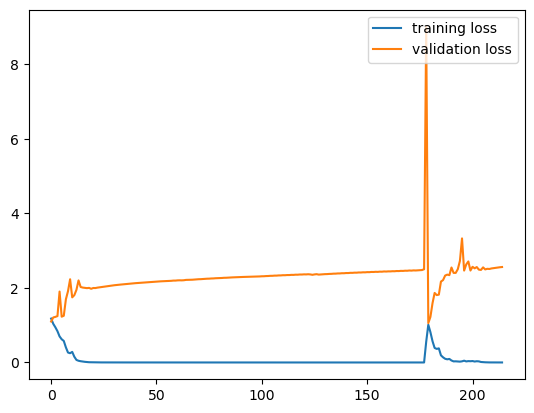

cd3
3772


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0568 loss_val: 1.0967 time: 6.8096s
 Epoch: 0010 loss_train: 0.0235 loss_val: 1.3729 time: 6.0980s
 Epoch: 0020 loss_train: 0.0009 loss_val: 1.2353 time: 5.4874s
 Epoch: 0030 loss_train: 0.0006 loss_val: 1.2680 time: 5.8176s
 Epoch: 0040 loss_train: 0.0004 loss_val: 1.2958 time: 5.9928s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.3193 time: 6.1868s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.3398 time: 5.1003s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.3582 time: 6.7584s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.3751 time: 5.8685s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.3906 time: 5.6139s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.4051 time: 6.3686s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.4187 time: 5.8269s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.4316 time: 6.8881s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.4441 time: 5.3847s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.4559 time: 8.3183s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.4675 time: 

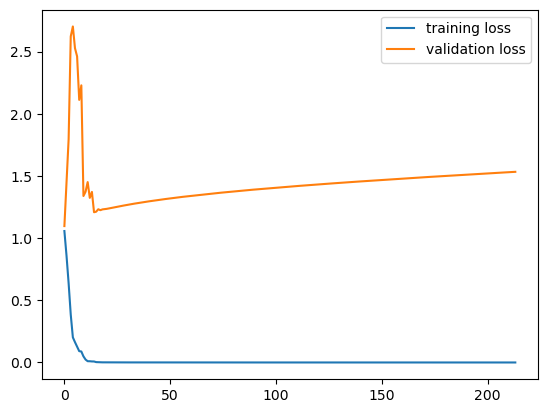

cd4
5602


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.3062 loss_val: 1.4611 time: 9.2004s
 Epoch: 0010 loss_train: 0.1596 loss_val: 2.7842 time: 8.1709s
 Epoch: 0020 loss_train: 0.0174 loss_val: 2.2582 time: 7.1708s
 Epoch: 0030 loss_train: 0.0034 loss_val: 2.0176 time: 8.2262s
 Epoch: 0040 loss_train: 0.0013 loss_val: 2.0441 time: 8.3162s
 Epoch: 0050 loss_train: 0.0011 loss_val: 2.0813 time: 10.1465s
 Epoch: 0060 loss_train: 0.0010 loss_val: 2.1118 time: 8.9886s
 Epoch: 0070 loss_train: 0.0011 loss_val: 2.1412 time: 8.5191s
 Epoch: 0080 loss_train: 0.0008 loss_val: 2.1740 time: 10.3200s
 Epoch: 0090 loss_train: 0.0009 loss_val: 2.1988 time: 9.8775s
 Epoch: 0100 loss_train: 0.0008 loss_val: 2.2247 time: 8.2828s
 Epoch: 0110 loss_train: 0.0008 loss_val: 2.2519 time: 8.2136s
 Epoch: 0120 loss_train: 0.0008 loss_val: 2.2801 time: 7.2475s
 Epoch: 0130 loss_train: 0.0009 loss_val: 2.2968 time: 6.9334s
 Epoch: 0140 loss_train: 0.0006 loss_val: 2.2911 time: 7.1440s
 Epoch: 0150 loss_train: 0.0006 loss_val: 2.3462 time

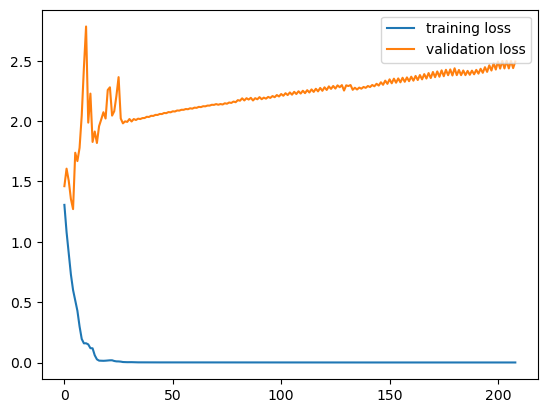

cd8
5625


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2829 loss_val: 1.6651 time: 7.0750s
 Epoch: 0010 loss_train: 0.1059 loss_val: 1.8336 time: 9.0999s
 Epoch: 0020 loss_train: 0.0044 loss_val: 1.8516 time: 8.0964s
 Epoch: 0030 loss_train: 0.0017 loss_val: 1.9251 time: 8.3044s
 Epoch: 0040 loss_train: 0.0015 loss_val: 1.9777 time: 5.7356s
 Epoch: 0050 loss_train: 0.0012 loss_val: 2.0195 time: 7.6621s
 Epoch: 0060 loss_train: 0.0011 loss_val: 2.0553 time: 6.8982s
 Epoch: 0070 loss_train: 0.0009 loss_val: 2.0865 time: 7.1654s
 Epoch: 0080 loss_train: 0.0020 loss_val: 2.1240 time: 9.8867s
 Epoch: 0090 loss_train: 0.1404 loss_val: 2.6053 time: 9.7057s
 Epoch: 0100 loss_train: 0.0017 loss_val: 2.1344 time: 7.8125s
 Epoch: 0110 loss_train: 0.0009 loss_val: 2.1943 time: 6.7825s
 Epoch: 0120 loss_train: 0.0008 loss_val: 2.2325 time: 6.5093s
 Epoch: 0130 loss_train: 0.0007 loss_val: 2.2660 time: 6.8683s
 Epoch: 0140 loss_train: 0.0008 loss_val: 2.2884 time: 7.5991s
 Epoch: 0150 loss_train: 0.0006 loss_val: 2.3118 time: 

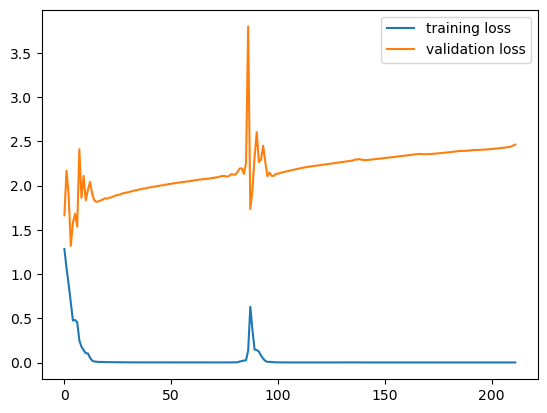

gh2ax
4892


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2736 loss_val: 1.5423 time: 7.5612s
 Epoch: 0010 loss_train: 0.0043 loss_val: 1.3967 time: 8.3575s
 Epoch: 0020 loss_train: 0.0011 loss_val: 1.4356 time: 5.1982s
 Epoch: 0030 loss_train: 0.0006 loss_val: 1.4765 time: 5.9058s
 Epoch: 0040 loss_train: 0.0004 loss_val: 1.5084 time: 5.9955s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.5348 time: 6.4269s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.5577 time: 6.1410s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.5780 time: 7.1454s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.5965 time: 8.3290s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.6138 time: 8.2518s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.6299 time: 5.4411s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.6450 time: 6.4386s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.6594 time: 6.9009s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.6734 time: 6.6895s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.6868 time: 6.0476s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.6996 time: 

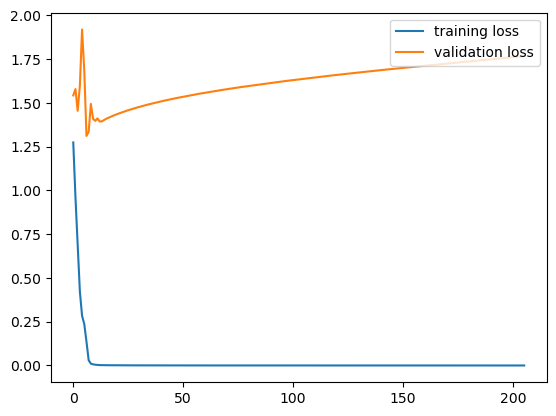

lamin
4893


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.3376 loss_val: 1.4365 time: 4.7830s
 Epoch: 0010 loss_train: 0.0469 loss_val: 1.3225 time: 6.8994s
 Epoch: 0020 loss_train: 0.0012 loss_val: 1.3156 time: 8.2133s
 Epoch: 0030 loss_train: 0.0006 loss_val: 1.3438 time: 7.5520s
 Epoch: 0040 loss_train: 0.0004 loss_val: 1.3699 time: 7.5353s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.3921 time: 7.9736s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.4116 time: 7.7361s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.4290 time: 7.0620s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.4452 time: 8.3868s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.4601 time: 10.0907s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.4740 time: 7.5979s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.4874 time: 5.3439s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.5000 time: 8.0674s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.5123 time: 7.5134s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.5242 time: 7.5692s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.5357 time:

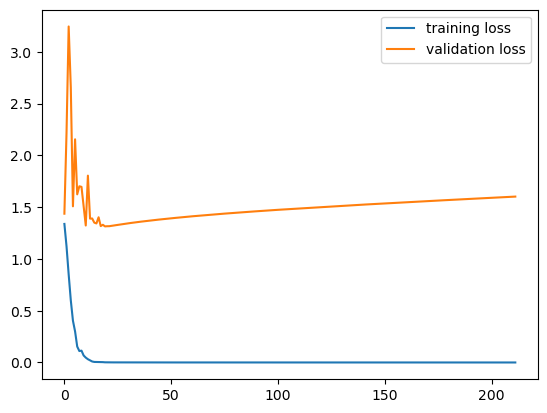

22
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
hold out: HV8
HV3
HV6
dapi_cd8_cd4
HV1
hold out: HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
hold out: P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
hold out: P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
hold out: P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
hold out: P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
hold out: P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
hold out: P47
P29
P52
P57
P22
P68
P16
P84
P15
22
cd16
4544


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1548 loss_val: 1.0982 time: 7.9545s
 Epoch: 0010 loss_train: 0.2102 loss_val: 1.7045 time: 8.7335s
 Epoch: 0020 loss_train: 0.0437 loss_val: 2.2580 time: 7.8131s
 Epoch: 0030 loss_train: 0.0037 loss_val: 2.1168 time: 6.4932s
 Epoch: 0040 loss_train: 0.0020 loss_val: 2.1490 time: 7.0345s
 Epoch: 0050 loss_train: 0.0015 loss_val: 2.1889 time: 8.1472s
 Epoch: 0060 loss_train: 0.0014 loss_val: 2.2175 time: 7.6634s
 Epoch: 0070 loss_train: 0.0011 loss_val: 2.2393 time: 7.7962s
 Epoch: 0080 loss_train: 0.0014 loss_val: 2.2669 time: 6.4659s
 Epoch: 0090 loss_train: 0.0009 loss_val: 2.2876 time: 7.5046s
 Epoch: 0100 loss_train: 0.0010 loss_val: 2.3114 time: 7.7749s
 Epoch: 0110 loss_train: 0.0011 loss_val: 2.3364 time: 6.0095s
 Epoch: 0120 loss_train: 0.0009 loss_val: 2.3484 time: 4.0353s
 Epoch: 0130 loss_train: 0.0012 loss_val: 2.3486 time: 5.0595s
 Epoch: 0140 loss_train: 0.0598 loss_val: 2.2775 time: 7.9645s
 Epoch: 0150 loss_train: 0.0023 loss_val: 2.3674 time: 

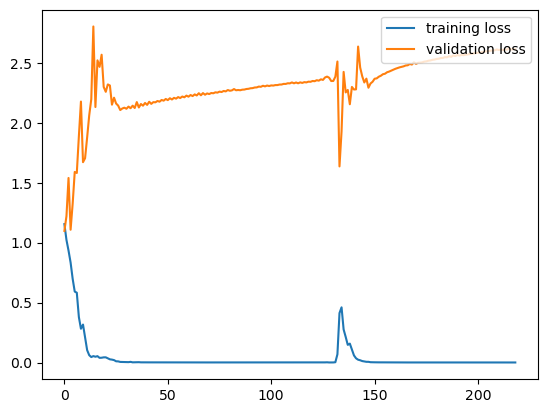

cd3
3781


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0820 loss_val: 1.0890 time: 5.8403s
 Epoch: 0010 loss_train: 0.0144 loss_val: 1.2114 time: 6.2558s
 Epoch: 0020 loss_train: 0.0008 loss_val: 1.2494 time: 4.8586s
 Epoch: 0030 loss_train: 0.0005 loss_val: 1.2778 time: 5.8195s
 Epoch: 0040 loss_train: 0.0003 loss_val: 1.3014 time: 5.8089s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.3217 time: 7.2009s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.3396 time: 6.9831s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.3558 time: 5.4416s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.3705 time: 5.3136s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.3841 time: 5.6504s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.3968 time: 6.4426s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.4089 time: 5.9753s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.4204 time: 6.3025s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.4312 time: 6.5083s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.4418 time: 6.3921s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.4520 time: 

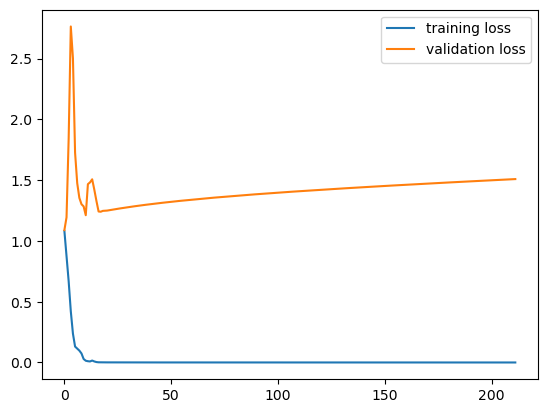

cd4
5579


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2994 loss_val: 1.5029 time: 8.5332s
 Epoch: 0010 loss_train: 0.2088 loss_val: 2.0326 time: 7.7359s
 Epoch: 0020 loss_train: 0.0072 loss_val: 1.9314 time: 8.1292s
 Epoch: 0030 loss_train: 0.0019 loss_val: 1.9904 time: 7.4611s
 Epoch: 0040 loss_train: 0.0015 loss_val: 2.0402 time: 7.7482s
 Epoch: 0050 loss_train: 0.0012 loss_val: 2.0829 time: 9.1475s
 Epoch: 0060 loss_train: 0.0011 loss_val: 2.1156 time: 7.4036s
 Epoch: 0070 loss_train: 0.0010 loss_val: 2.1586 time: 9.2986s
 Epoch: 0080 loss_train: 0.0010 loss_val: 2.1773 time: 7.0556s
 Epoch: 0090 loss_train: 0.0008 loss_val: 2.2025 time: 8.2945s
 Epoch: 0100 loss_train: 0.0009 loss_val: 2.2470 time: 8.9644s
 Epoch: 0110 loss_train: 0.0013 loss_val: 2.3485 time: 7.7572s
 Epoch: 0120 loss_train: 0.1404 loss_val: 2.6357 time: 8.2319s
 Epoch: 0130 loss_train: 0.0033 loss_val: 2.2644 time: 7.9551s
 Epoch: 0140 loss_train: 0.0010 loss_val: 2.3344 time: 8.7496s
 Epoch: 0150 loss_train: 0.0008 loss_val: 2.3726 time: 

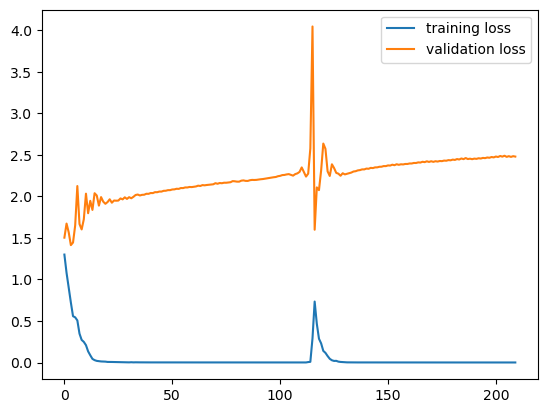

cd8
5605


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2808 loss_val: 1.6833 time: 6.8178s
 Epoch: 0010 loss_train: 0.0602 loss_val: 1.8243 time: 8.1709s
 Epoch: 0020 loss_train: 0.0028 loss_val: 1.9394 time: 8.2509s
 Epoch: 0030 loss_train: 0.0013 loss_val: 2.0032 time: 8.3149s
 Epoch: 0040 loss_train: 0.0010 loss_val: 2.0588 time: 8.7028s
 Epoch: 0050 loss_train: 0.0008 loss_val: 2.1019 time: 9.6059s
 Epoch: 0060 loss_train: 0.0008 loss_val: 2.1400 time: 9.2265s
 Epoch: 0070 loss_train: 0.0006 loss_val: 2.1702 time: 8.2853s
 Epoch: 0080 loss_train: 0.0006 loss_val: 2.2034 time: 9.6570s
 Epoch: 0090 loss_train: 0.0005 loss_val: 2.2248 time: 9.6701s
 Epoch: 0100 loss_train: 0.0005 loss_val: 2.2576 time: 9.0767s
 Epoch: 0110 loss_train: 0.0005 loss_val: 2.2879 time: 9.6990s
 Epoch: 0120 loss_train: 0.1696 loss_val: 2.3031 time: 9.5445s
 Epoch: 0130 loss_train: 0.0028 loss_val: 2.2675 time: 9.1973s
 Epoch: 0140 loss_train: 0.0007 loss_val: 2.3247 time: 8.9695s
 Epoch: 0150 loss_train: 0.0006 loss_val: 2.3670 time: 

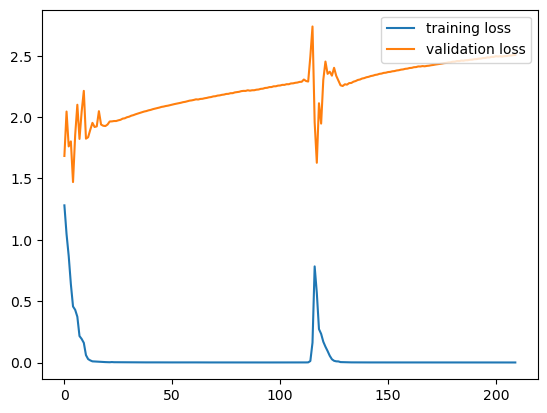

gh2ax
4926


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2756 loss_val: 1.6296 time: 7.2528s
 Epoch: 0010 loss_train: 0.0034 loss_val: 1.4565 time: 7.7320s
 Epoch: 0020 loss_train: 0.0010 loss_val: 1.5071 time: 8.0023s
 Epoch: 0030 loss_train: 0.0006 loss_val: 1.5458 time: 8.8268s
 Epoch: 0040 loss_train: 0.0004 loss_val: 1.5761 time: 7.8245s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.6016 time: 7.7192s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.6238 time: 8.3409s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.6435 time: 5.2087s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.6617 time: 5.7443s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.6787 time: 7.2954s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.6945 time: 8.1593s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.7095 time: 7.3528s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.7239 time: 8.2944s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.7376 time: 7.0487s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.7509 time: 7.3195s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.7638 time: 

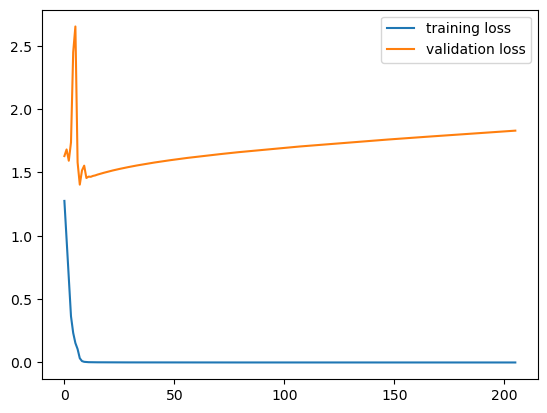

lamin
4927


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.3516 loss_val: 1.3991 time: 7.5536s
 Epoch: 0010 loss_train: 0.0576 loss_val: 1.4368 time: 6.1673s
 Epoch: 0020 loss_train: 0.0013 loss_val: 1.3864 time: 8.5910s
 Epoch: 0030 loss_train: 0.0007 loss_val: 1.4246 time: 5.6534s
 Epoch: 0040 loss_train: 0.0005 loss_val: 1.4554 time: 6.4199s
 Epoch: 0050 loss_train: 0.0004 loss_val: 1.4810 time: 7.1872s
 Epoch: 0060 loss_train: 0.0003 loss_val: 1.5039 time: 6.4096s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.5244 time: 6.5742s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.5433 time: 8.1066s
 Epoch: 0090 loss_train: 0.0002 loss_val: 1.5609 time: 6.7335s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.5772 time: 5.8650s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.5929 time: 5.6961s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.6079 time: 5.0025s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.6226 time: 5.9790s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.6362 time: 7.0465s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.6498 time: 

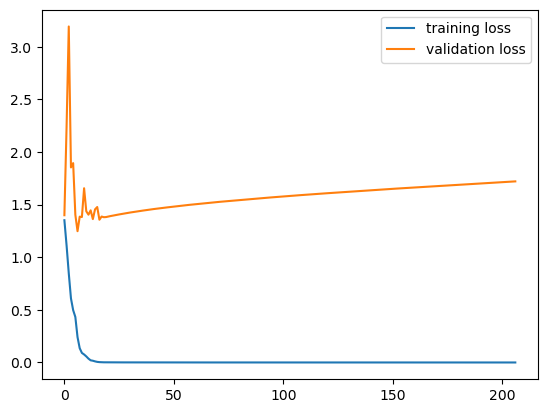

23
controls
dapi_gh2ax_lamin
HV5
HV4
hold out: HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
HV3
hold out: HV2
headneck
dapi_gh2ax_lamin_cd3
hold out: P72
P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
hold out: P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
hold out: P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
hold out: P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
hold out: P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
hold out: P57
P22
P68
P16
P84
P15
23
cd16
4608


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1542 loss_val: 1.1140 time: 7.2102s
 Epoch: 0010 loss_train: 0.2305 loss_val: 1.7198 time: 7.7456s
 Epoch: 0020 loss_train: 0.0103 loss_val: 2.0407 time: 7.4110s
 Epoch: 0030 loss_train: 0.0027 loss_val: 2.1023 time: 8.3097s
 Epoch: 0040 loss_train: 0.0019 loss_val: 2.1624 time: 7.6543s
 Epoch: 0050 loss_train: 0.0015 loss_val: 2.2058 time: 6.7060s
 Epoch: 0060 loss_train: 0.0013 loss_val: 2.2419 time: 5.9087s
 Epoch: 0070 loss_train: 0.0011 loss_val: 2.2718 time: 6.9277s
 Epoch: 0080 loss_train: 0.0011 loss_val: 2.2952 time: 7.4992s
 Epoch: 0090 loss_train: 0.0011 loss_val: 2.3356 time: 6.6634s
 Epoch: 0100 loss_train: 0.2767 loss_val: 2.9176 time: 7.9117s
 Epoch: 0110 loss_train: 0.0224 loss_val: 2.4698 time: 7.4423s
 Epoch: 0120 loss_train: 0.0015 loss_val: 2.4452 time: 5.9354s
 Epoch: 0130 loss_train: 0.0011 loss_val: 2.5006 time: 5.5085s
 Epoch: 0140 loss_train: 0.0008 loss_val: 2.5352 time: 6.4836s
 Epoch: 0150 loss_train: 0.0008 loss_val: 2.5533 time: 

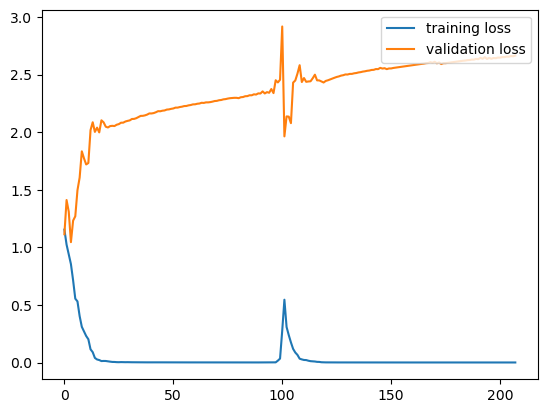

cd3
3822


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0650 loss_val: 1.0911 time: 4.6583s
 Epoch: 0010 loss_train: 0.0126 loss_val: 1.1328 time: 6.5592s
 Epoch: 0020 loss_train: 0.0098 loss_val: 1.4569 time: 4.9709s
 Epoch: 0030 loss_train: 0.0006 loss_val: 1.2944 time: 7.0311s
 Epoch: 0040 loss_train: 0.0004 loss_val: 1.3149 time: 5.5862s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.3348 time: 5.3847s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.3529 time: 4.6793s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.3697 time: 4.6649s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.3852 time: 5.8362s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.3997 time: 4.8140s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.4134 time: 4.8257s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.4263 time: 4.2823s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.4387 time: 7.0615s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.4504 time: 7.1393s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.4619 time: 6.2289s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.4728 time: 

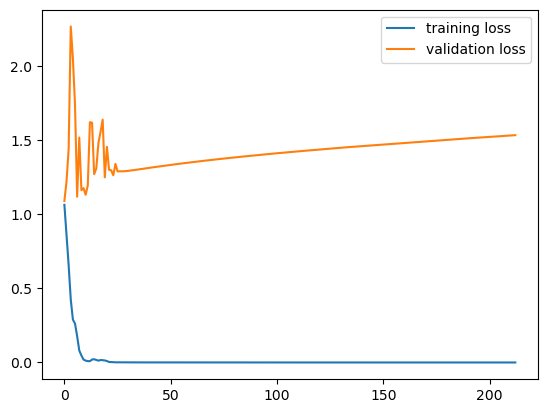

cd4
5637


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.3010 loss_val: 1.5691 time: 9.3970s
 Epoch: 0010 loss_train: 0.1928 loss_val: 1.6829 time: 8.4043s
 Epoch: 0020 loss_train: 0.0067 loss_val: 1.8467 time: 7.7280s
 Epoch: 0030 loss_train: 0.0016 loss_val: 1.9222 time: 8.9965s
 Epoch: 0040 loss_train: 0.0011 loss_val: 1.9684 time: 7.7850s
 Epoch: 0050 loss_train: 0.0009 loss_val: 2.0073 time: 7.9658s
 Epoch: 0060 loss_train: 0.0007 loss_val: 2.0429 time: 8.7645s
 Epoch: 0070 loss_train: 0.0006 loss_val: 2.0716 time: 8.9967s
 Epoch: 0080 loss_train: 0.0006 loss_val: 2.1018 time: 7.1840s
 Epoch: 0090 loss_train: 0.0006 loss_val: 2.1214 time: 9.1055s
 Epoch: 0100 loss_train: 0.0004 loss_val: 2.1443 time: 8.0142s
 Epoch: 0110 loss_train: 0.0004 loss_val: 2.1780 time: 7.3810s
 Epoch: 0120 loss_train: 0.0004 loss_val: 2.2113 time: 8.3017s
 Epoch: 0130 loss_train: 0.0007 loss_val: 2.2877 time: 8.5214s
 Epoch: 0140 loss_train: 0.0003 loss_val: 2.2142 time: 10.0867s
 Epoch: 0150 loss_train: 0.0003 loss_val: 2.2585 time:

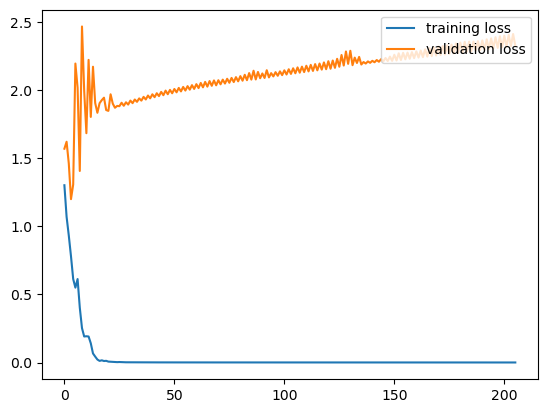

cd8
5659


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2936 loss_val: 1.6647 time: 7.6552s
 Epoch: 0010 loss_train: 0.0594 loss_val: 2.1883 time: 8.3902s
 Epoch: 0020 loss_train: 0.0081 loss_val: 2.0573 time: 7.3479s
 Epoch: 0030 loss_train: 0.0007 loss_val: 1.9668 time: 9.2800s
 Epoch: 0040 loss_train: 0.0004 loss_val: 2.0076 time: 8.0940s
 Epoch: 0050 loss_train: 0.0003 loss_val: 2.0415 time: 6.5657s
 Epoch: 0060 loss_train: 0.0003 loss_val: 2.0710 time: 7.1321s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.0977 time: 7.6506s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.1225 time: 8.2636s
 Epoch: 0090 loss_train: 0.0001 loss_val: 2.1456 time: 8.2715s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.1673 time: 6.4911s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.1884 time: 8.8428s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.2084 time: 7.8106s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.2275 time: 6.4568s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.2462 time: 7.9727s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.2644 time: 

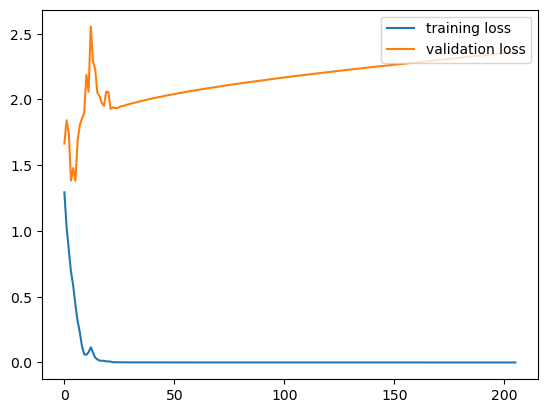

gh2ax
4938


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2758 loss_val: 1.6153 time: 7.2428s
 Epoch: 0010 loss_train: 0.0045 loss_val: 1.5681 time: 7.2674s
 Epoch: 0020 loss_train: 0.0010 loss_val: 1.3948 time: 8.4615s
 Epoch: 0030 loss_train: 0.0006 loss_val: 1.4345 time: 7.0664s
 Epoch: 0040 loss_train: 0.0004 loss_val: 1.4660 time: 6.9498s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.4926 time: 5.3955s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.5157 time: 6.1282s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.5365 time: 8.5469s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.5556 time: 9.0006s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.5731 time: 6.9414s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.5896 time: 7.9606s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.6054 time: 6.5074s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.6203 time: 5.7373s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.6346 time: 7.2892s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.6484 time: 7.2177s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.6618 time: 

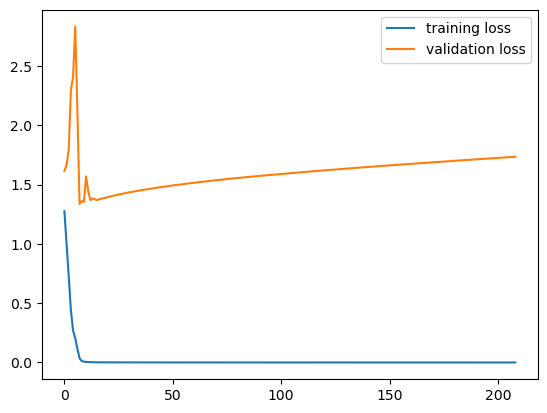

lamin
4939


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.3251 loss_val: 1.3932 time: 6.3932s
 Epoch: 0010 loss_train: 0.0200 loss_val: 1.5438 time: 7.2647s
 Epoch: 0020 loss_train: 0.0063 loss_val: 1.4415 time: 5.4841s
 Epoch: 0030 loss_train: 0.0008 loss_val: 1.4099 time: 6.8405s
 Epoch: 0040 loss_train: 0.0004 loss_val: 1.4279 time: 5.9555s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.4461 time: 7.7002s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.4633 time: 5.7951s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.4791 time: 7.0100s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.4939 time: 8.4214s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.5079 time: 8.8400s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.5210 time: 8.2198s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.5339 time: 6.8062s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.5462 time: 6.6684s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.5581 time: 8.3350s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.5698 time: 6.5111s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.5812 time: 

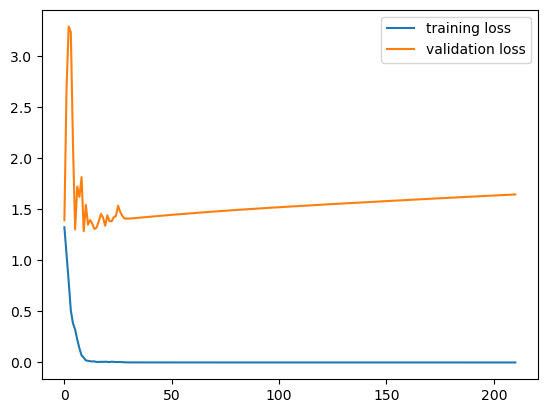

24
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
hold out: HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
hold out: HV1
HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
hold out: P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
P59
hold out: P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
hold out: P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
hold out: P22
P68
P16
P84
P15
24
cd16
4555


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1792 loss_val: 1.0990 time: 6.5229s
 Epoch: 0010 loss_train: 0.2171 loss_val: 1.9136 time: 7.5193s
 Epoch: 0020 loss_train: 0.0344 loss_val: 2.7215 time: 7.5575s
 Epoch: 0030 loss_train: 0.0121 loss_val: 2.4353 time: 7.9915s
 Epoch: 0040 loss_train: 0.0006 loss_val: 2.3130 time: 8.6168s
 Epoch: 0050 loss_train: 0.0004 loss_val: 2.3444 time: 6.1464s
 Epoch: 0060 loss_train: 0.0003 loss_val: 2.3725 time: 5.8473s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.3979 time: 6.5821s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.4211 time: 7.1787s
 Epoch: 0090 loss_train: 0.0001 loss_val: 2.4426 time: 4.7354s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.4630 time: 7.2879s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.4824 time: 6.2311s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.5012 time: 7.3217s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.5191 time: 6.9428s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.5368 time: 6.4671s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.5540 time: 

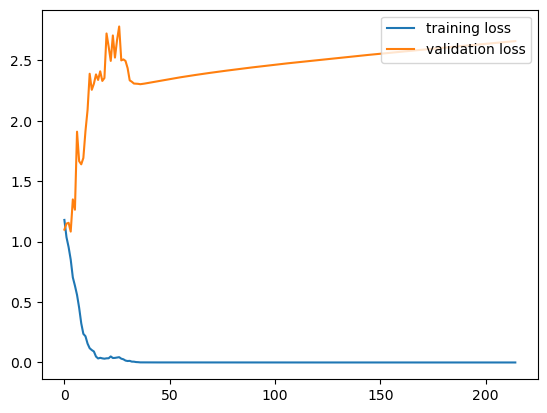

cd3
3760


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0894 loss_val: 1.0948 time: 3.5399s
 Epoch: 0010 loss_train: 0.0122 loss_val: 1.2564 time: 4.3801s
 Epoch: 0020 loss_train: 0.0253 loss_val: 1.6308 time: 4.8972s
 Epoch: 0030 loss_train: 0.0400 loss_val: 1.3312 time: 5.8750s
 Epoch: 0040 loss_train: 0.0004 loss_val: 1.2890 time: 5.2502s
 Epoch: 0050 loss_train: 0.0002 loss_val: 1.2993 time: 4.5405s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.3083 time: 5.3801s
 Epoch: 0070 loss_train: 0.0001 loss_val: 1.3166 time: 5.1203s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.3241 time: 5.0589s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.3314 time: 5.9325s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.3382 time: 6.2801s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.3449 time: 6.4854s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.3514 time: 6.9418s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.3578 time: 4.9768s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.3642 time: 5.4855s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.3705 time: 

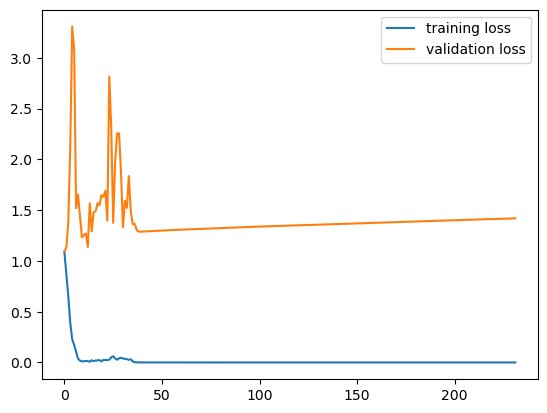

cd4
5580


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.3158 loss_val: 1.4643 time: 7.8958s
 Epoch: 0010 loss_train: 0.1677 loss_val: 2.1231 time: 8.6099s
 Epoch: 0020 loss_train: 0.0027 loss_val: 1.8962 time: 8.3332s
 Epoch: 0030 loss_train: 0.0008 loss_val: 1.9649 time: 9.6515s
 Epoch: 0040 loss_train: 0.0005 loss_val: 2.0175 time: 8.0610s
 Epoch: 0050 loss_train: 0.0004 loss_val: 2.0600 time: 8.1517s
 Epoch: 0060 loss_train: 0.0003 loss_val: 2.0963 time: 7.1389s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.1286 time: 9.9220s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.1581 time: 9.3261s
 Epoch: 0090 loss_train: 0.0002 loss_val: 2.1854 time: 6.1293s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.2110 time: 7.8646s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.2354 time: 9.1909s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.2585 time: 7.9752s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.2809 time: 9.5890s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.3024 time: 9.5294s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.3235 time: 

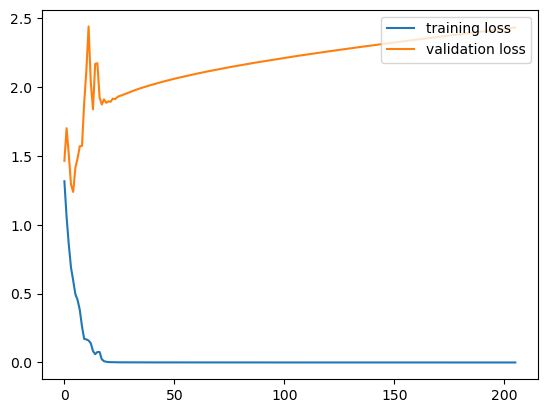

cd8
5604


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2527 loss_val: 1.6104 time: 9.4641s
 Epoch: 0010 loss_train: 0.0650 loss_val: 1.9208 time: 8.2928s
 Epoch: 0020 loss_train: 0.0140 loss_val: 2.0123 time: 6.2839s
 Epoch: 0030 loss_train: 0.0162 loss_val: 2.1116 time: 6.5028s
 Epoch: 0040 loss_train: 0.0015 loss_val: 2.1341 time: 6.1403s
 Epoch: 0050 loss_train: 0.0009 loss_val: 2.1580 time: 8.6033s
 Epoch: 0060 loss_train: 0.0008 loss_val: 2.1890 time: 8.4432s
 Epoch: 0070 loss_train: 0.0008 loss_val: 2.2159 time: 8.0197s
 Epoch: 0080 loss_train: 0.0007 loss_val: 2.2361 time: 6.9268s
 Epoch: 0090 loss_train: 0.0007 loss_val: 2.2603 time: 9.0014s
 Epoch: 0100 loss_train: 0.0007 loss_val: 2.2825 time: 8.1640s
 Epoch: 0110 loss_train: 0.0007 loss_val: 2.2962 time: 8.8379s
 Epoch: 0120 loss_train: 0.0006 loss_val: 2.3196 time: 9.9999s
 Epoch: 0130 loss_train: 0.0006 loss_val: 2.3412 time: 7.5607s
 Epoch: 0140 loss_train: 0.0006 loss_val: 2.3628 time: 9.9785s
 Epoch: 0150 loss_train: 0.0006 loss_val: 2.3836 time: 

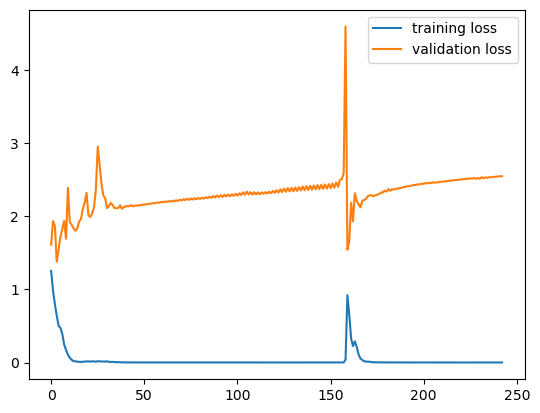

gh2ax
4837


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2762 loss_val: 1.5389 time: 7.0131s
 Epoch: 0010 loss_train: 0.0045 loss_val: 1.3008 time: 7.4183s
 Epoch: 0020 loss_train: 0.0008 loss_val: 1.3438 time: 7.3294s
 Epoch: 0030 loss_train: 0.0005 loss_val: 1.3773 time: 8.7182s
 Epoch: 0040 loss_train: 0.0003 loss_val: 1.4049 time: 7.6107s
 Epoch: 0050 loss_train: 0.0002 loss_val: 1.4284 time: 7.0066s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.4491 time: 6.4548s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.4679 time: 7.7438s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.4849 time: 7.9583s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.5008 time: 6.1029s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.5158 time: 7.2585s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.5298 time: 7.3696s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.5433 time: 8.1369s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.5563 time: 6.9759s
 Epoch: 0140 loss_train: 0.0000 loss_val: 1.5687 time: 5.8221s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.5808 time: 

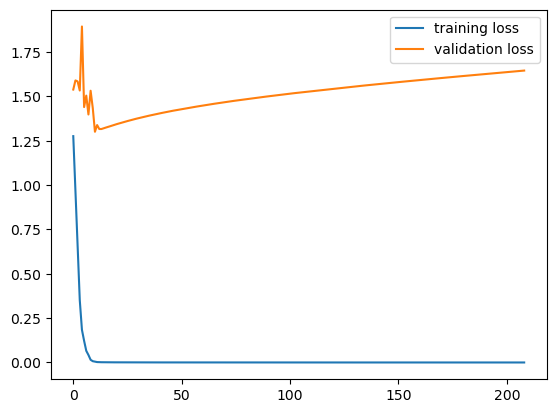

lamin
4838


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.3237 loss_val: 1.3496 time: 8.9337s
 Epoch: 0010 loss_train: 0.0142 loss_val: 1.1750 time: 9.0314s
 Epoch: 0020 loss_train: 0.0049 loss_val: 1.2331 time: 8.0892s
 Epoch: 0030 loss_train: 0.0007 loss_val: 1.2449 time: 7.3115s
 Epoch: 0040 loss_train: 0.0004 loss_val: 1.2681 time: 7.4396s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.2879 time: 6.5385s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.3057 time: 6.9966s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.3217 time: 7.4404s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.3366 time: 7.9726s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.3505 time: 6.9018s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.3636 time: 7.9704s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.3760 time: 6.3829s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.3878 time: 7.5570s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.3993 time: 8.7490s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.4103 time: 7.2179s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.4212 time: 

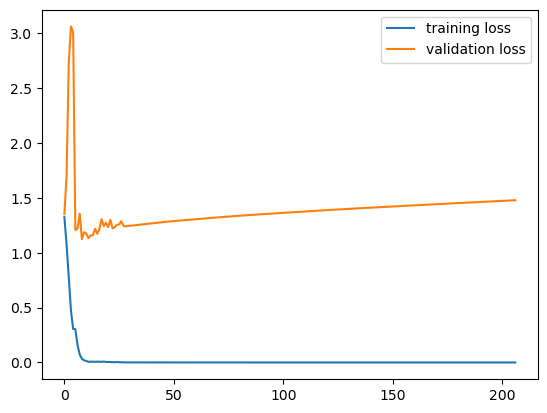

25
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
hold out: HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
hold out: HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
P55
P50
hold out: P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
P63
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
hold out: P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
hold out: P46
P47
P29
P52
P57
P22
P68
P16
P84
P15
25
cd16
4490


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1455 loss_val: 1.1085 time: 8.3758s
 Epoch: 0010 loss_train: 0.2216 loss_val: 1.8630 time: 5.4895s
 Epoch: 0020 loss_train: 0.0012 loss_val: 2.1063 time: 7.1642s
 Epoch: 0030 loss_train: 0.0006 loss_val: 2.1799 time: 7.6340s
 Epoch: 0040 loss_train: 0.0004 loss_val: 2.2334 time: 7.1321s
 Epoch: 0050 loss_train: 0.0003 loss_val: 2.2769 time: 7.1179s
 Epoch: 0060 loss_train: 0.0003 loss_val: 2.3142 time: 7.5933s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.3471 time: 7.8729s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.3771 time: 6.0285s
 Epoch: 0090 loss_train: 0.0001 loss_val: 2.4048 time: 7.4765s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.4307 time: 6.8584s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.4552 time: 7.6263s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.4783 time: 5.5179s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.5007 time: 5.3352s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.5222 time: 7.2736s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.5431 time: 

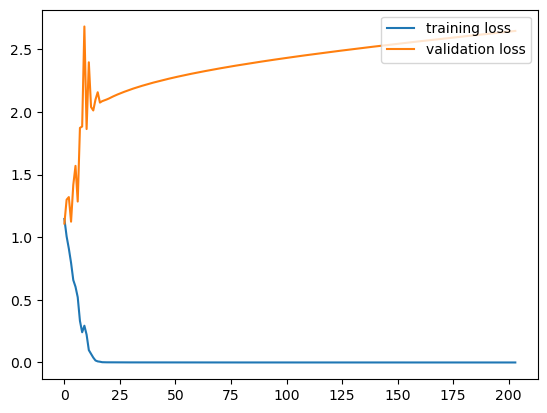

cd3
3802


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0825 loss_val: 1.0861 time: 5.7091s
 Epoch: 0010 loss_train: 0.0060 loss_val: 1.0820 time: 5.4454s
 Epoch: 0020 loss_train: 0.0010 loss_val: 1.1324 time: 7.0699s
 Epoch: 0030 loss_train: 0.0006 loss_val: 1.1684 time: 6.6346s
 Epoch: 0040 loss_train: 0.0004 loss_val: 1.1960 time: 4.9158s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.2189 time: 7.4454s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.2384 time: 5.9517s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.2556 time: 5.0737s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.2712 time: 6.1627s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.2854 time: 6.4002s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.2987 time: 6.6814s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.3111 time: 5.7970s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.3228 time: 6.1865s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.3339 time: 5.5715s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.3446 time: 5.2395s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.3549 time: 

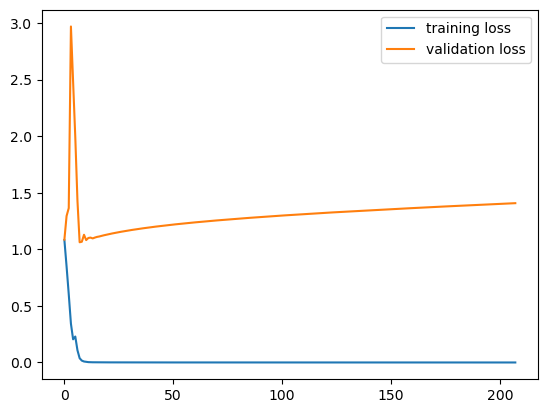

cd4
5518


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.3115 loss_val: 1.4987 time: 6.7083s
 Epoch: 0010 loss_train: 0.1297 loss_val: 1.9517 time: 10.4311s
 Epoch: 0020 loss_train: 0.0070 loss_val: 2.0620 time: 5.7816s
 Epoch: 0030 loss_train: 0.0006 loss_val: 2.0538 time: 6.7086s
 Epoch: 0040 loss_train: 0.0004 loss_val: 2.0877 time: 6.0779s
 Epoch: 0050 loss_train: 0.0003 loss_val: 2.1188 time: 8.6788s
 Epoch: 0060 loss_train: 0.0002 loss_val: 2.1471 time: 8.0757s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.1731 time: 7.1225s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.1977 time: 8.3992s
 Epoch: 0090 loss_train: 0.0001 loss_val: 2.2209 time: 8.3842s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.2429 time: 7.9544s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.2642 time: 8.3160s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.2847 time: 6.5051s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.3046 time: 8.6116s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.3242 time: 6.9300s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.3431 time:

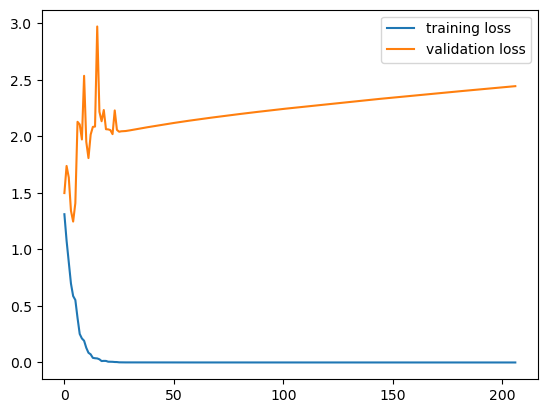

cd8
5545


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2712 loss_val: 1.6633 time: 7.0041s
 Epoch: 0010 loss_train: 0.0526 loss_val: 2.2366 time: 8.1705s
 Epoch: 0020 loss_train: 0.0012 loss_val: 1.8589 time: 8.4016s
 Epoch: 0030 loss_train: 0.0007 loss_val: 1.9219 time: 7.4507s
 Epoch: 0040 loss_train: 0.0004 loss_val: 1.9702 time: 8.4517s
 Epoch: 0050 loss_train: 0.0003 loss_val: 2.0105 time: 7.7959s
 Epoch: 0060 loss_train: 0.0002 loss_val: 2.0454 time: 6.8611s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.0763 time: 8.6160s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.1046 time: 7.6600s
 Epoch: 0090 loss_train: 0.0001 loss_val: 2.1307 time: 6.6069s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.1554 time: 6.6449s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.1788 time: 8.5053s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.2011 time: 8.6198s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.2224 time: 8.0079s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.2430 time: 8.2758s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.2630 time: 

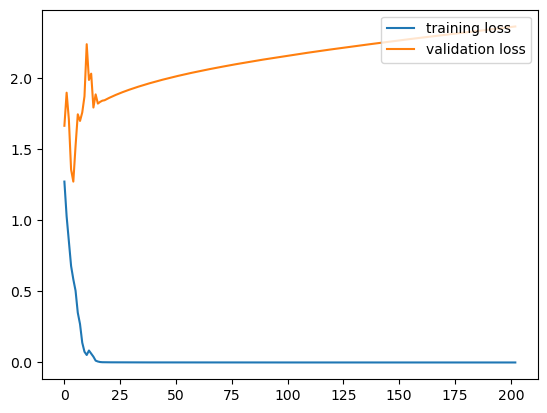

gh2ax
4931


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2540 loss_val: 1.6348 time: 9.0987s
 Epoch: 0010 loss_train: 0.0036 loss_val: 1.1902 time: 5.4212s
 Epoch: 0020 loss_train: 0.0010 loss_val: 1.2317 time: 9.3422s
 Epoch: 0030 loss_train: 0.0006 loss_val: 1.2685 time: 8.8683s
 Epoch: 0040 loss_train: 0.0004 loss_val: 1.2970 time: 7.6777s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.3205 time: 7.8062s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.3410 time: 8.1340s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.3593 time: 6.3041s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.3761 time: 6.1855s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.3915 time: 7.3866s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.4060 time: 7.6584s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.4197 time: 8.1924s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.4327 time: 7.3592s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.4452 time: 7.1194s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.4572 time: 8.5956s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.4689 time: 

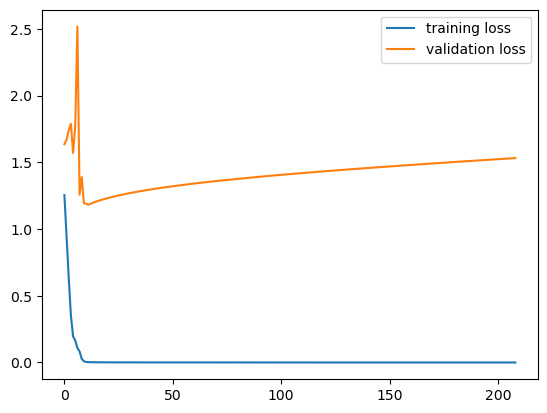

lamin
4932


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.3134 loss_val: 1.3788 time: 8.2610s
 Epoch: 0010 loss_train: 0.0093 loss_val: 1.0795 time: 7.2570s
 Epoch: 0020 loss_train: 0.0013 loss_val: 1.1389 time: 7.6682s
 Epoch: 0030 loss_train: 0.0007 loss_val: 1.1766 time: 5.9816s
 Epoch: 0040 loss_train: 0.0005 loss_val: 1.2054 time: 6.5989s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.2292 time: 9.6073s
 Epoch: 0060 loss_train: 0.0003 loss_val: 1.2497 time: 8.4816s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.2680 time: 8.5822s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.2846 time: 8.5615s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.2999 time: 6.8005s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.3142 time: 5.7709s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.3277 time: 8.0611s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.3405 time: 5.9876s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.3528 time: 8.0263s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.3645 time: 6.7138s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.3758 time: 

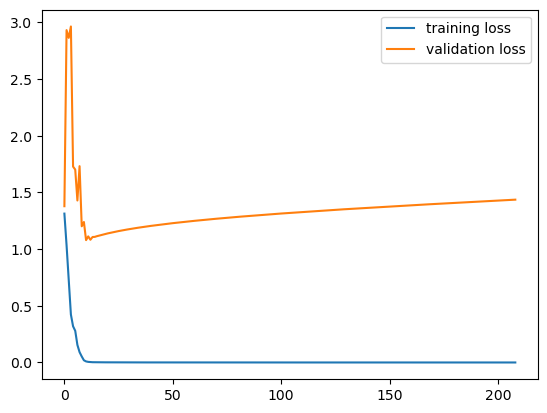

26
controls
dapi_gh2ax_lamin
hold out: HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
hold out: HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
hold out: P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
hold out: P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
hold out: P68
P16
P84
P15
26
cd16
4629


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1656 loss_val: 1.0987 time: 7.6776s
 Epoch: 0010 loss_train: 0.2516 loss_val: 2.1556 time: 7.3806s
 Epoch: 0020 loss_train: 0.0173 loss_val: 2.1683 time: 6.7684s
 Epoch: 0030 loss_train: 0.0049 loss_val: 2.1653 time: 5.4908s
 Epoch: 0040 loss_train: 0.0027 loss_val: 2.1987 time: 7.6148s
 Epoch: 0050 loss_train: 0.0023 loss_val: 2.2364 time: 6.1416s
 Epoch: 0060 loss_train: 0.0020 loss_val: 2.2632 time: 6.8576s
 Epoch: 0070 loss_train: 0.0020 loss_val: 2.2949 time: 6.0130s
 Epoch: 0080 loss_train: 0.0020 loss_val: 2.3035 time: 4.7309s
 Epoch: 0090 loss_train: 0.0014 loss_val: 2.3443 time: 7.6247s
 Epoch: 0100 loss_train: 0.0017 loss_val: 2.3758 time: 8.4630s
 Epoch: 0110 loss_train: 0.0016 loss_val: 2.3948 time: 6.9233s
 Epoch: 0120 loss_train: 0.0014 loss_val: 2.4219 time: 7.8330s
 Epoch: 0130 loss_train: 0.0013 loss_val: 2.4359 time: 5.8076s
 Epoch: 0140 loss_train: 0.8181 loss_val: 1.5142 time: 4.5658s
 Epoch: 0150 loss_train: 0.0200 loss_val: 2.6031 time: 

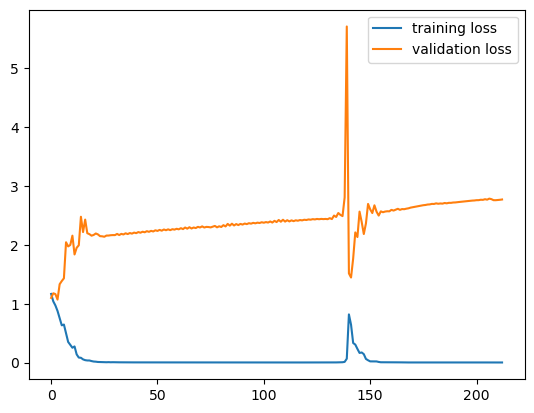

cd3
3806


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0724 loss_val: 1.1150 time: 6.5616s
 Epoch: 0010 loss_train: 0.0115 loss_val: 1.2098 time: 4.5445s
 Epoch: 0020 loss_train: 0.0010 loss_val: 1.2836 time: 4.3752s
 Epoch: 0030 loss_train: 0.0006 loss_val: 1.3244 time: 7.1130s
 Epoch: 0040 loss_train: 0.0004 loss_val: 1.3558 time: 6.1639s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.3818 time: 6.4110s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.4042 time: 5.2957s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.4242 time: 6.8323s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.4422 time: 7.7212s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.4586 time: 4.5032s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.4737 time: 6.7502s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.4880 time: 7.3693s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.5016 time: 6.0294s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.5144 time: 5.6409s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.5266 time: 6.7006s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.5384 time: 

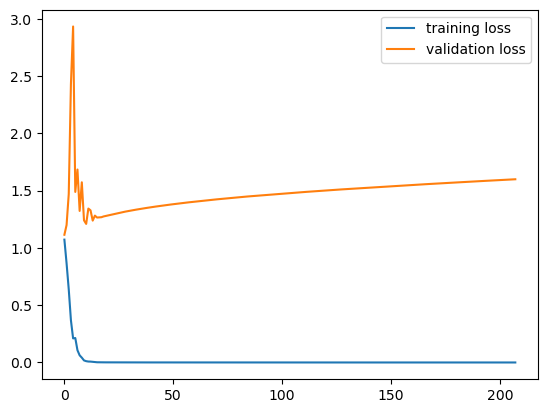

cd4
5663


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.3028 loss_val: 1.5387 time: 8.3090s
 Epoch: 0010 loss_train: 0.1930 loss_val: 2.0522 time: 7.4755s
 Epoch: 0020 loss_train: 0.0064 loss_val: 2.0473 time: 5.7171s
 Epoch: 0030 loss_train: 0.0015 loss_val: 2.0975 time: 6.7541s
 Epoch: 0040 loss_train: 0.0010 loss_val: 2.1531 time: 8.4909s
 Epoch: 0050 loss_train: 0.0008 loss_val: 2.1954 time: 7.7110s
 Epoch: 0060 loss_train: 0.0008 loss_val: 2.2313 time: 7.5664s
 Epoch: 0070 loss_train: 0.0006 loss_val: 2.2656 time: 6.0833s
 Epoch: 0080 loss_train: 0.0005 loss_val: 2.2942 time: 9.1382s
 Epoch: 0090 loss_train: 0.0010 loss_val: 2.3275 time: 6.1895s
 Epoch: 0100 loss_train: 0.0004 loss_val: 2.3450 time: 7.2073s
 Epoch: 0110 loss_train: 0.0004 loss_val: 2.3713 time: 7.4934s
 Epoch: 0120 loss_train: 0.0004 loss_val: 2.3963 time: 7.9319s
 Epoch: 0130 loss_train: 0.0004 loss_val: 2.4191 time: 8.4818s
 Epoch: 0140 loss_train: 0.0003 loss_val: 2.4401 time: 9.5873s
 Epoch: 0150 loss_train: 0.0004 loss_val: 2.4632 time: 

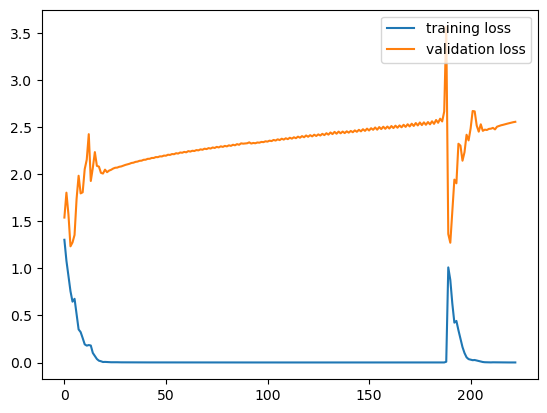

cd8
5687


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2692 loss_val: 1.6993 time: 8.5338s
 Epoch: 0010 loss_train: 0.1104 loss_val: 1.9576 time: 10.0290s
 Epoch: 0020 loss_train: 0.0020 loss_val: 1.9556 time: 8.4278s
 Epoch: 0030 loss_train: 0.0008 loss_val: 2.0290 time: 9.9411s
 Epoch: 0040 loss_train: 0.0005 loss_val: 2.0844 time: 8.1441s
 Epoch: 0050 loss_train: 0.0004 loss_val: 2.1287 time: 10.9231s
 Epoch: 0060 loss_train: 0.0003 loss_val: 2.1667 time: 8.3998s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.2006 time: 8.5131s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.2312 time: 9.8430s
 Epoch: 0090 loss_train: 0.0002 loss_val: 2.2597 time: 8.6536s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.2863 time: 6.9564s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.3114 time: 8.5153s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.3356 time: 8.9309s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.3588 time: 7.9712s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.3813 time: 8.4252s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.4034 time

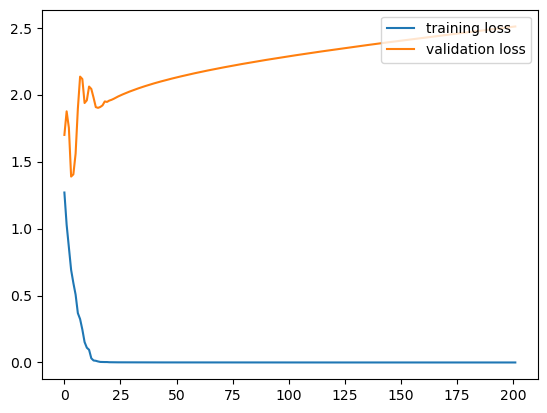

gh2ax
4889


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2911 loss_val: 1.6747 time: 5.5891s
 Epoch: 0010 loss_train: 0.0045 loss_val: 1.3991 time: 7.7371s
 Epoch: 0020 loss_train: 0.0011 loss_val: 1.4403 time: 7.6046s
 Epoch: 0030 loss_train: 0.0006 loss_val: 1.4789 time: 7.0191s
 Epoch: 0040 loss_train: 0.0004 loss_val: 1.5095 time: 8.2658s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.5350 time: 5.9178s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.5572 time: 7.5171s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.5771 time: 7.6611s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.5953 time: 7.9598s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.6121 time: 7.3639s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.6281 time: 5.6893s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.6430 time: 6.5594s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.6572 time: 6.6293s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.6710 time: 9.5035s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.6842 time: 8.9721s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.6970 time: 

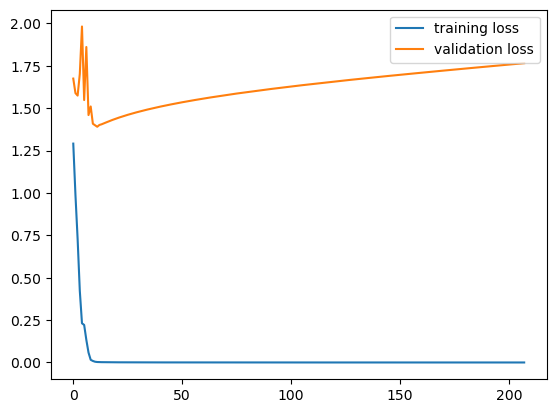

lamin
4890


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.3335 loss_val: 1.4160 time: 6.8586s
 Epoch: 0010 loss_train: 0.0141 loss_val: 1.3023 time: 5.4538s
 Epoch: 0020 loss_train: 0.0014 loss_val: 1.3132 time: 7.4430s
 Epoch: 0030 loss_train: 0.0008 loss_val: 1.3569 time: 7.9462s
 Epoch: 0040 loss_train: 0.0005 loss_val: 1.3901 time: 9.2572s
 Epoch: 0050 loss_train: 0.0004 loss_val: 1.4173 time: 9.9091s
 Epoch: 0060 loss_train: 0.0003 loss_val: 1.4410 time: 9.4209s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.4617 time: 8.6048s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.4805 time: 9.4162s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.4977 time: 8.0348s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.5138 time: 7.6533s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.5288 time: 8.9063s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.5431 time: 8.6685s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.5568 time: 8.9767s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.5699 time: 6.6624s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.5826 time: 

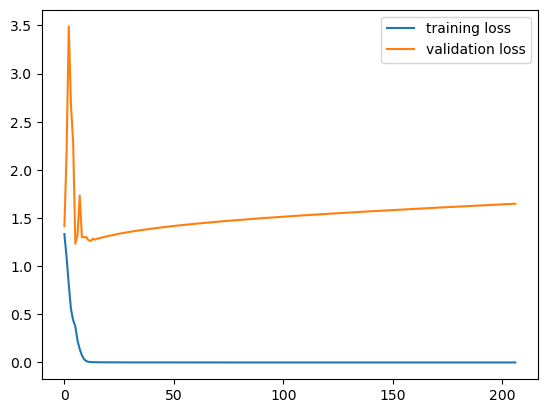

27
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
hold out: HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
hold out: HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
hold out: P55
P50
P24
dapi_cd16_cd4_cd8
hold out: P55
P56
P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
hold out: P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
hold out: P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
hold out: P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
P68
P16
P84
hold out: P15
27
cd16
4560


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1774 loss_val: 1.1036 time: 8.6740s
 Epoch: 0010 loss_train: 0.2312 loss_val: 2.0796 time: 7.8584s
 Epoch: 0020 loss_train: 0.0141 loss_val: 2.2476 time: 8.4747s
 Epoch: 0030 loss_train: 0.0023 loss_val: 2.0664 time: 7.6610s
 Epoch: 0040 loss_train: 0.0010 loss_val: 2.1143 time: 8.7620s
 Epoch: 0050 loss_train: 0.0009 loss_val: 2.1533 time: 7.4532s
 Epoch: 0060 loss_train: 0.0008 loss_val: 2.1863 time: 8.3196s
 Epoch: 0070 loss_train: 0.0006 loss_val: 2.2134 time: 7.2640s
 Epoch: 0080 loss_train: 0.0006 loss_val: 2.2406 time: 7.7863s
 Epoch: 0090 loss_train: 0.0011 loss_val: 2.2634 time: 8.2815s
 Epoch: 0100 loss_train: 0.0004 loss_val: 2.2794 time: 7.1607s
 Epoch: 0110 loss_train: 0.0005 loss_val: 2.3058 time: 6.7404s
 Epoch: 0120 loss_train: 0.0005 loss_val: 2.3287 time: 6.5787s
 Epoch: 0130 loss_train: 0.0005 loss_val: 2.3496 time: 7.2313s
 Epoch: 0140 loss_train: 0.0004 loss_val: 2.3785 time: 8.2049s
 Epoch: 0150 loss_train: 0.0004 loss_val: 2.3610 time: 

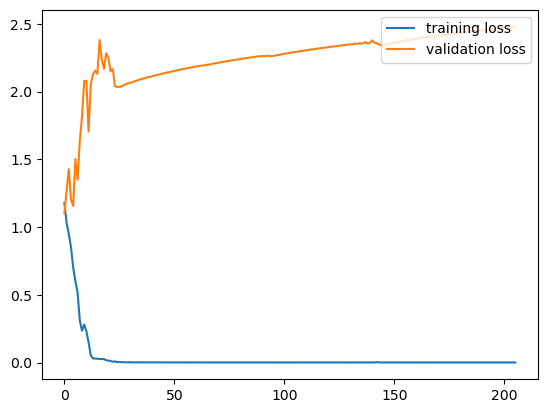

cd3
3772


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0760 loss_val: 1.0884 time: 5.8836s
 Epoch: 0010 loss_train: 0.0162 loss_val: 1.2297 time: 6.2643s
 Epoch: 0020 loss_train: 0.0010 loss_val: 1.1750 time: 7.1108s
 Epoch: 0030 loss_train: 0.0006 loss_val: 1.2080 time: 6.1935s
 Epoch: 0040 loss_train: 0.0004 loss_val: 1.2342 time: 5.2405s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.2561 time: 7.1985s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.2753 time: 5.8242s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.2924 time: 6.5101s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.3078 time: 5.3521s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.3221 time: 5.8914s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.3355 time: 6.0207s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.3480 time: 5.7894s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.3601 time: 5.8057s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.3715 time: 4.6790s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.3825 time: 6.4057s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.3930 time: 

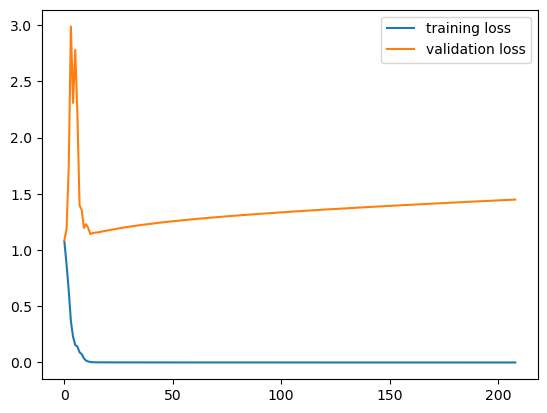

cd4
5602


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.3231 loss_val: 1.5141 time: 11.6651s
 Epoch: 0010 loss_train: 0.2279 loss_val: 1.6637 time: 8.5176s
 Epoch: 0020 loss_train: 0.0031 loss_val: 1.8795 time: 9.6790s
 Epoch: 0030 loss_train: 0.0015 loss_val: 1.9778 time: 9.7875s
 Epoch: 0040 loss_train: 0.0012 loss_val: 2.0431 time: 10.0081s
 Epoch: 0050 loss_train: 0.0009 loss_val: 2.0930 time: 9.7375s
 Epoch: 0060 loss_train: 0.0007 loss_val: 2.1321 time: 10.3756s
 Epoch: 0070 loss_train: 0.0006 loss_val: 2.1736 time: 11.4144s
 Epoch: 0080 loss_train: 0.0006 loss_val: 2.2054 time: 9.6057s
 Epoch: 0090 loss_train: 0.0008 loss_val: 2.2567 time: 7.1186s
 Epoch: 0100 loss_train: 0.0004 loss_val: 2.2480 time: 7.2156s
 Epoch: 0110 loss_train: 0.0004 loss_val: 2.2856 time: 8.3937s
 Epoch: 0120 loss_train: 0.0004 loss_val: 2.3164 time: 9.7765s
 Epoch: 0130 loss_train: 0.0004 loss_val: 2.3545 time: 8.8402s
 Epoch: 0140 loss_train: 0.0004 loss_val: 2.3755 time: 9.0543s
 Epoch: 0150 loss_train: 0.0004 loss_val: 2.4193 ti

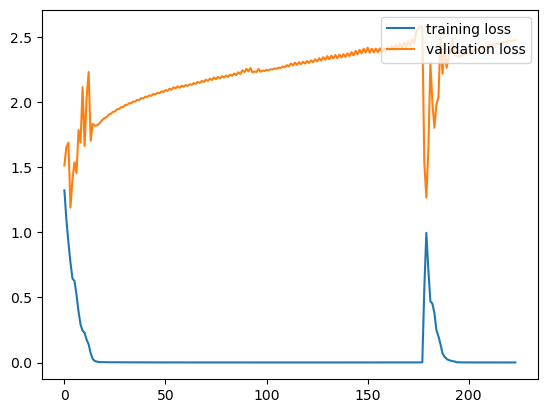

cd8
5625


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2724 loss_val: 1.6745 time: 9.9438s
 Epoch: 0010 loss_train: 0.0691 loss_val: 1.9726 time: 8.8487s
 Epoch: 0020 loss_train: 0.0021 loss_val: 1.8877 time: 10.0922s
 Epoch: 0030 loss_train: 0.0014 loss_val: 1.9656 time: 9.1042s
 Epoch: 0040 loss_train: 0.0010 loss_val: 2.0175 time: 10.2871s
 Epoch: 0050 loss_train: 0.0008 loss_val: 2.0637 time: 9.2705s
 Epoch: 0060 loss_train: 0.0008 loss_val: 2.1027 time: 10.6209s
 Epoch: 0070 loss_train: 0.0006 loss_val: 2.1329 time: 9.7582s
 Epoch: 0080 loss_train: 0.0005 loss_val: 2.1696 time: 10.4587s
 Epoch: 0090 loss_train: 0.0005 loss_val: 2.2048 time: 10.9266s
 Epoch: 0100 loss_train: 0.0061 loss_val: 2.2940 time: 11.0377s
 Epoch: 0110 loss_train: 0.0111 loss_val: 2.1210 time: 10.5975s
 Epoch: 0120 loss_train: 0.0011 loss_val: 2.1480 time: 8.6967s
 Epoch: 0130 loss_train: 0.0006 loss_val: 2.2075 time: 9.8392s
 Epoch: 0140 loss_train: 0.0006 loss_val: 2.2485 time: 8.1198s
 Epoch: 0150 loss_train: 0.0004 loss_val: 2.2844

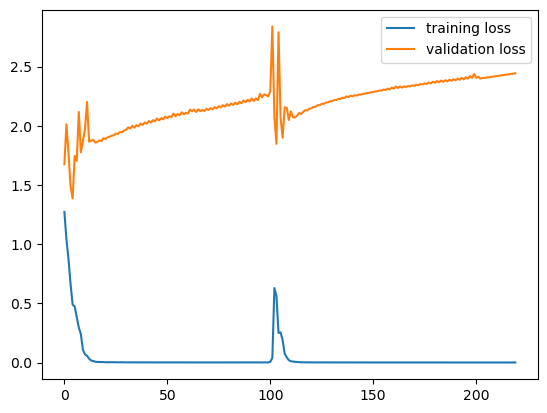

gh2ax
4892


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.3050 loss_val: 1.5765 time: 6.2512s
 Epoch: 0010 loss_train: 0.0039 loss_val: 1.3679 time: 8.3047s
 Epoch: 0020 loss_train: 0.0010 loss_val: 1.4377 time: 7.8170s
 Epoch: 0030 loss_train: 0.0006 loss_val: 1.4793 time: 5.3477s
 Epoch: 0040 loss_train: 0.0004 loss_val: 1.5112 time: 6.5179s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.5378 time: 8.2467s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.5606 time: 8.3215s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.5812 time: 8.1364s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.5998 time: 5.9215s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.6170 time: 5.9478s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.6331 time: 7.2736s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.6484 time: 4.6324s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.6630 time: 8.7585s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.6770 time: 7.2349s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.6905 time: 5.8492s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.7035 time: 

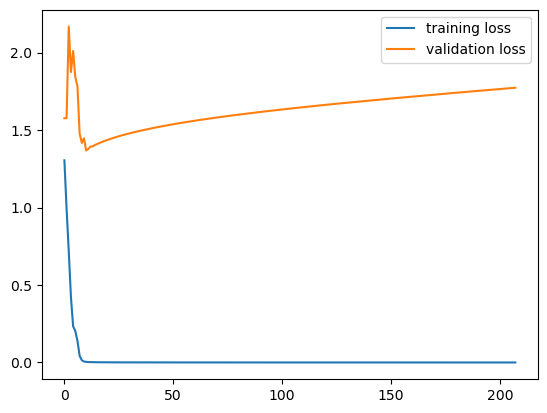

lamin
4893


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.3356 loss_val: 1.4435 time: 6.9365s
 Epoch: 0010 loss_train: 0.0351 loss_val: 1.7779 time: 6.9911s
 Epoch: 0020 loss_train: 0.0011 loss_val: 1.3073 time: 6.3202s
 Epoch: 0030 loss_train: 0.0006 loss_val: 1.3363 time: 7.4367s
 Epoch: 0040 loss_train: 0.0004 loss_val: 1.3625 time: 6.7848s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.3849 time: 7.8250s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.4048 time: 4.8965s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.4229 time: 8.8195s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.4397 time: 7.2612s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.4552 time: 6.5459s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.4698 time: 7.0890s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.4836 time: 8.0280s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.4970 time: 8.9623s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.5097 time: 8.7445s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.5220 time: 8.8703s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.5341 time: 

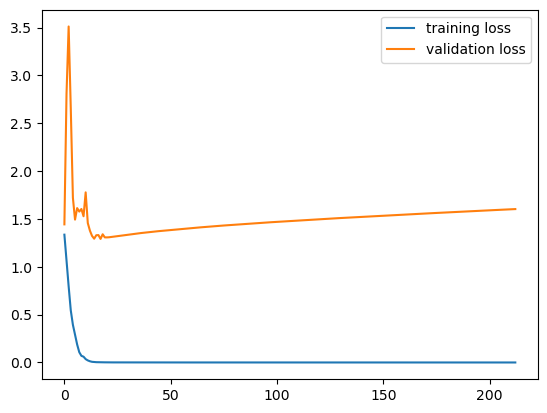

28
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
hold out: HV8
HV3
HV6
dapi_cd8_cd4
HV1
hold out: HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
hold out: P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
hold out: P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
hold out: P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
hold out: P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
hold out: P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
hold out: P47
P29
P52
P57
P22
P68
P16
P84
P15
28
cd16
4544


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1463 loss_val: 1.0997 time: 8.3411s
 Epoch: 0010 loss_train: 0.2435 loss_val: 2.0432 time: 7.4670s
 Epoch: 0020 loss_train: 0.0114 loss_val: 2.0011 time: 9.3683s
 Epoch: 0030 loss_train: 0.0067 loss_val: 2.0846 time: 8.7394s
 Epoch: 0040 loss_train: 0.0031 loss_val: 2.1378 time: 8.2524s
 Epoch: 0050 loss_train: 0.0025 loss_val: 2.1872 time: 8.2683s
 Epoch: 0060 loss_train: 0.0022 loss_val: 2.2308 time: 8.5371s
 Epoch: 0070 loss_train: 0.0025 loss_val: 2.2777 time: 8.0907s
 Epoch: 0080 loss_train: 0.0017 loss_val: 2.3040 time: 8.7294s
 Epoch: 0090 loss_train: 0.0020 loss_val: 2.3486 time: 8.5176s
 Epoch: 0100 loss_train: 0.0017 loss_val: 2.3758 time: 7.6746s
 Epoch: 0110 loss_train: 0.0017 loss_val: 2.3843 time: 7.5551s
 Epoch: 0120 loss_train: 0.0015 loss_val: 2.3738 time: 6.8199s
 Epoch: 0130 loss_train: 0.0014 loss_val: 2.4204 time: 7.5887s
 Epoch: 0140 loss_train: 0.0014 loss_val: 2.4552 time: 8.4799s
 Epoch: 0150 loss_train: 0.0017 loss_val: 2.5341 time: 

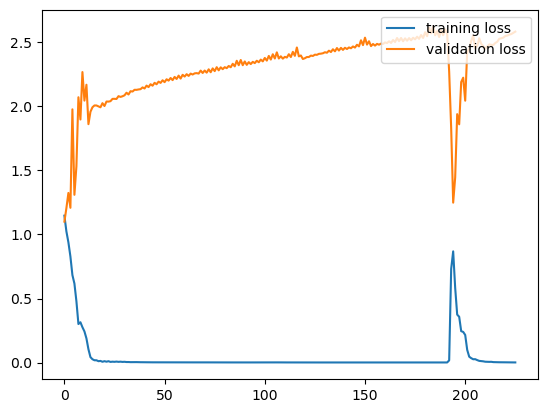

cd3
3781


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0799 loss_val: 1.0909 time: 6.5478s
 Epoch: 0010 loss_train: 0.0181 loss_val: 1.2245 time: 6.1388s
 Epoch: 0020 loss_train: 0.0009 loss_val: 1.2528 time: 6.0243s
 Epoch: 0030 loss_train: 0.0005 loss_val: 1.2876 time: 6.8309s
 Epoch: 0040 loss_train: 0.0004 loss_val: 1.3154 time: 7.2322s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.3388 time: 7.4553s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.3592 time: 6.1204s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.3774 time: 6.6774s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.3939 time: 7.3959s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.4091 time: 5.9431s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.4234 time: 6.2540s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.4365 time: 7.1786s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.4491 time: 6.6354s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.4611 time: 6.5941s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.4727 time: 6.0462s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.4836 time: 

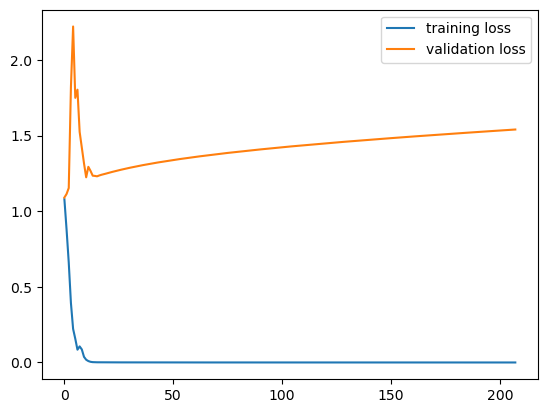

cd4
5579


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.3196 loss_val: 1.4418 time: 6.2158s
 Epoch: 0010 loss_train: 0.1381 loss_val: 1.8611 time: 9.6992s
 Epoch: 0020 loss_train: 0.0024 loss_val: 1.9239 time: 7.3475s
 Epoch: 0030 loss_train: 0.0009 loss_val: 2.0013 time: 10.5274s
 Epoch: 0040 loss_train: 0.0006 loss_val: 2.0608 time: 8.3784s
 Epoch: 0050 loss_train: 0.0004 loss_val: 2.1083 time: 10.6557s
 Epoch: 0060 loss_train: 0.0003 loss_val: 2.1487 time: 9.8997s
 Epoch: 0070 loss_train: 0.0003 loss_val: 2.1843 time: 7.9467s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.2165 time: 10.0693s
 Epoch: 0090 loss_train: 0.0002 loss_val: 2.2460 time: 9.6924s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.2735 time: 9.3630s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.2994 time: 10.3185s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.3241 time: 8.4273s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.3477 time: 11.0453s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.3705 time: 8.2031s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.3923 t

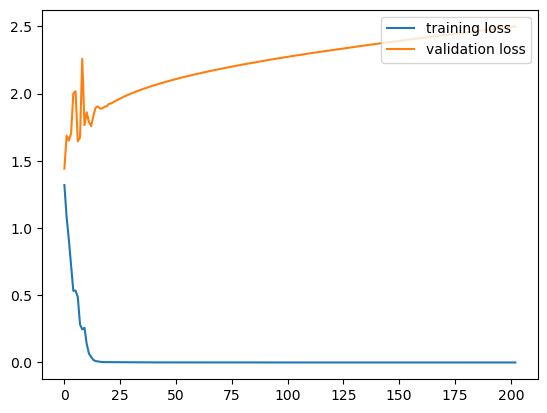

cd8
5605


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2716 loss_val: 1.6489 time: 8.8972s
 Epoch: 0010 loss_train: 0.0731 loss_val: 2.0853 time: 9.0482s
 Epoch: 0020 loss_train: 0.0028 loss_val: 1.9169 time: 8.7637s
 Epoch: 0030 loss_train: 0.0013 loss_val: 1.9790 time: 9.5685s
 Epoch: 0040 loss_train: 0.0010 loss_val: 2.0269 time: 8.5579s
 Epoch: 0050 loss_train: 0.0008 loss_val: 2.0656 time: 8.8337s
 Epoch: 0060 loss_train: 0.0009 loss_val: 2.1013 time: 7.7528s
 Epoch: 0070 loss_train: 0.0006 loss_val: 2.1294 time: 8.2925s
 Epoch: 0080 loss_train: 0.0006 loss_val: 2.1632 time: 8.5684s
 Epoch: 0090 loss_train: 0.0005 loss_val: 2.1894 time: 9.3234s
 Epoch: 0100 loss_train: 0.0047 loss_val: 2.3717 time: 9.9183s
 Epoch: 0110 loss_train: 0.0307 loss_val: 2.2861 time: 9.1168s
 Epoch: 0120 loss_train: 0.0010 loss_val: 2.1985 time: 8.4357s
 Epoch: 0130 loss_train: 0.0007 loss_val: 2.2499 time: 7.6302s
 Epoch: 0140 loss_train: 0.0005 loss_val: 2.2848 time: 8.7666s
 Epoch: 0150 loss_train: 0.0004 loss_val: 2.3108 time: 

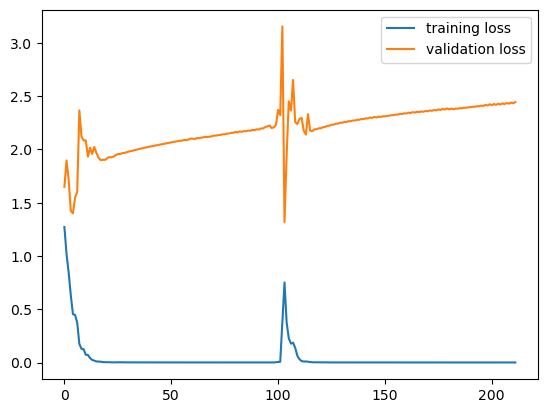

gh2ax
4926


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2743 loss_val: 1.6266 time: 7.5565s
 Epoch: 0010 loss_train: 0.0032 loss_val: 1.3296 time: 8.6322s
 Epoch: 0020 loss_train: 0.0010 loss_val: 1.3895 time: 7.2893s
 Epoch: 0030 loss_train: 0.0006 loss_val: 1.4314 time: 8.6258s
 Epoch: 0040 loss_train: 0.0004 loss_val: 1.4637 time: 9.1877s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.4905 time: 7.8356s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.5136 time: 8.7805s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.5342 time: 8.3118s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.5530 time: 8.0298s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.5705 time: 8.5250s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.5867 time: 8.6274s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.6020 time: 7.4531s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.6166 time: 7.9086s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.6306 time: 8.2783s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.6439 time: 8.2401s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.6570 time: 

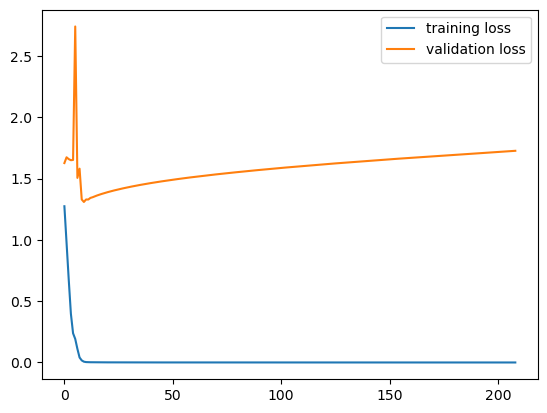

lamin
4927


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.3738 loss_val: 1.4216 time: 8.4552s
 Epoch: 0010 loss_train: 0.0474 loss_val: 1.3634 time: 7.4118s
 Epoch: 0020 loss_train: 0.0015 loss_val: 1.3314 time: 7.5348s
 Epoch: 0030 loss_train: 0.0007 loss_val: 1.3645 time: 7.5116s
 Epoch: 0040 loss_train: 0.0005 loss_val: 1.3941 time: 7.3216s
 Epoch: 0050 loss_train: 0.0004 loss_val: 1.4192 time: 8.9336s
 Epoch: 0060 loss_train: 0.0003 loss_val: 1.4411 time: 9.7989s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.4609 time: 7.9636s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.4789 time: 6.9236s
 Epoch: 0090 loss_train: 0.0002 loss_val: 1.4958 time: 8.0739s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.5115 time: 7.3173s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.5265 time: 8.8345s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.5406 time: 7.7610s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.5542 time: 5.8540s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.5672 time: 10.1890s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.5799 time:

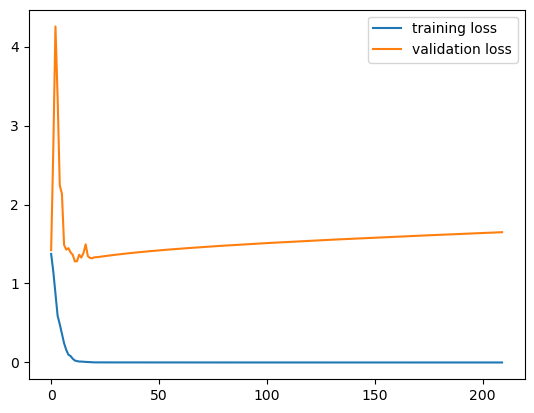

29
controls
dapi_gh2ax_lamin
HV5
HV4
hold out: HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
HV3
hold out: HV2
headneck
dapi_gh2ax_lamin_cd3
hold out: P72
P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
hold out: P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
hold out: P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
hold out: P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
hold out: P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
hold out: P57
P22
P68
P16
P84
P15
29
cd16
4608


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1615 loss_val: 1.1141 time: 8.7261s
 Epoch: 0010 loss_train: 0.0967 loss_val: 2.1615 time: 10.4947s
 Epoch: 0020 loss_train: 0.0153 loss_val: 2.1443 time: 8.2975s
 Epoch: 0030 loss_train: 0.0022 loss_val: 2.1192 time: 8.1850s
 Epoch: 0040 loss_train: 0.0011 loss_val: 2.1662 time: 8.5117s
 Epoch: 0050 loss_train: 0.0009 loss_val: 2.2022 time: 8.7751s
 Epoch: 0060 loss_train: 0.0008 loss_val: 2.2304 time: 7.9723s
 Epoch: 0070 loss_train: 0.0007 loss_val: 2.2606 time: 7.6740s
 Epoch: 0080 loss_train: 0.0007 loss_val: 2.2826 time: 8.3541s
 Epoch: 0090 loss_train: 0.0009 loss_val: 2.3106 time: 8.4492s
 Epoch: 0100 loss_train: 0.0005 loss_val: 2.3254 time: 7.3290s
 Epoch: 0110 loss_train: 0.0005 loss_val: 2.3524 time: 7.8224s
 Epoch: 0120 loss_train: 0.0005 loss_val: 2.3760 time: 7.5742s
 Epoch: 0130 loss_train: 0.0005 loss_val: 2.3963 time: 7.7597s
 Epoch: 0140 loss_train: 0.0006 loss_val: 2.4137 time: 6.8590s
 Epoch: 0150 loss_train: 0.0004 loss_val: 2.4323 time:

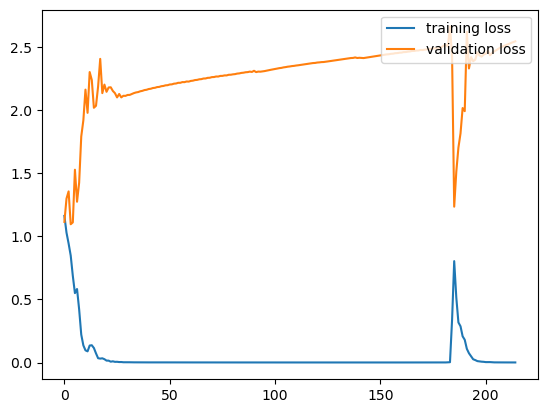

cd3
3822


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0754 loss_val: 1.0988 time: 5.1467s
 Epoch: 0010 loss_train: 0.0195 loss_val: 1.1680 time: 5.9761s
 Epoch: 0020 loss_train: 0.0011 loss_val: 1.2274 time: 5.5083s
 Epoch: 0030 loss_train: 0.0006 loss_val: 1.2546 time: 6.5796s
 Epoch: 0040 loss_train: 0.0004 loss_val: 1.2785 time: 4.2317s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.2994 time: 6.8052s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.3181 time: 7.3649s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.3350 time: 5.2388s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.3505 time: 7.0129s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.3649 time: 5.6009s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.3782 time: 4.8020s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.3909 time: 5.4836s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.4028 time: 6.5734s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.4142 time: 6.7768s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.4252 time: 5.9344s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.4357 time: 

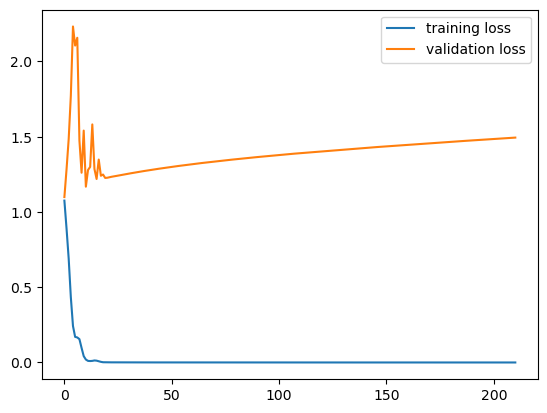

cd4
5637


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.3036 loss_val: 1.5617 time: 7.9799s
 Epoch: 0010 loss_train: 0.1859 loss_val: 2.0123 time: 8.1009s
 Epoch: 0030 loss_train: 0.0008 loss_val: 1.9380 time: 9.0510s
 Epoch: 0040 loss_train: 0.0005 loss_val: 1.9844 time: 7.6967s
 Epoch: 0050 loss_train: 0.0004 loss_val: 2.0240 time: 7.6000s
 Epoch: 0060 loss_train: 0.0003 loss_val: 2.0584 time: 7.9291s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.0897 time: 9.9449s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.1183 time: 7.0463s
 Epoch: 0090 loss_train: 0.0002 loss_val: 2.1451 time: 9.3558s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.1704 time: 9.3684s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.1943 time: 7.9987s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.2172 time: 7.1747s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.2392 time: 7.7294s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.2606 time: 7.2496s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.2814 time: 9.2926s
 Epoch: 0160 loss_train: 0.0001 loss_val: 2.3016 time: 

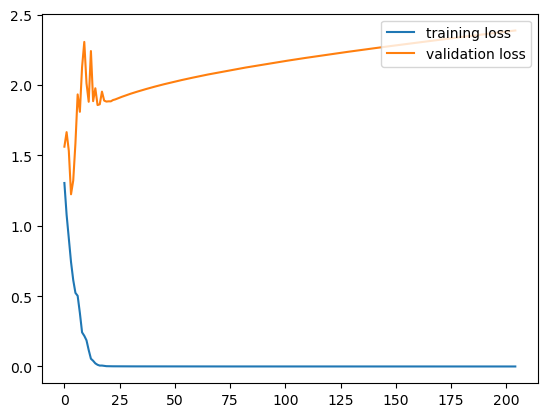

cd8
5659


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2798 loss_val: 1.7179 time: 8.9714s
 Epoch: 0010 loss_train: 0.1009 loss_val: 2.4425 time: 6.8274s
 Epoch: 0020 loss_train: 0.0037 loss_val: 1.9231 time: 9.6367s
 Epoch: 0030 loss_train: 0.0008 loss_val: 1.9575 time: 8.8855s
 Epoch: 0040 loss_train: 0.0005 loss_val: 2.0061 time: 8.1423s
 Epoch: 0050 loss_train: 0.0004 loss_val: 2.0453 time: 5.5815s
 Epoch: 0060 loss_train: 0.0003 loss_val: 2.0793 time: 10.2370s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.1095 time: 8.9307s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.1372 time: 6.3093s
 Epoch: 0090 loss_train: 0.0001 loss_val: 2.1627 time: 8.9473s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.1867 time: 9.6242s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.2100 time: 9.2875s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.2318 time: 7.2084s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.2533 time: 8.7991s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.2740 time: 8.3024s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.2942 time:

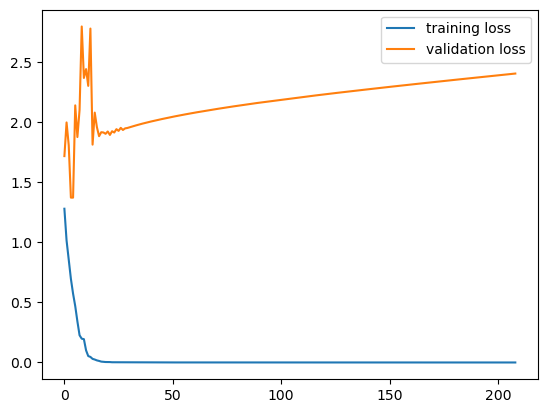

gh2ax
4938


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2844 loss_val: 1.5899 time: 9.1030s
 Epoch: 0010 loss_train: 0.0081 loss_val: 1.6364 time: 7.1293s
 Epoch: 0020 loss_train: 0.0030 loss_val: 1.5923 time: 9.4206s
 Epoch: 0030 loss_train: 0.0005 loss_val: 1.5362 time: 8.0407s
 Epoch: 0040 loss_train: 0.0004 loss_val: 1.5580 time: 8.4208s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.5778 time: 8.5775s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.5962 time: 9.2906s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.6131 time: 8.6661s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.6290 time: 7.6001s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.6439 time: 10.0038s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.6581 time: 8.5079s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.6718 time: 9.3758s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.6851 time: 9.3252s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.6978 time: 10.5982s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.7103 time: 9.4897s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.7225 time

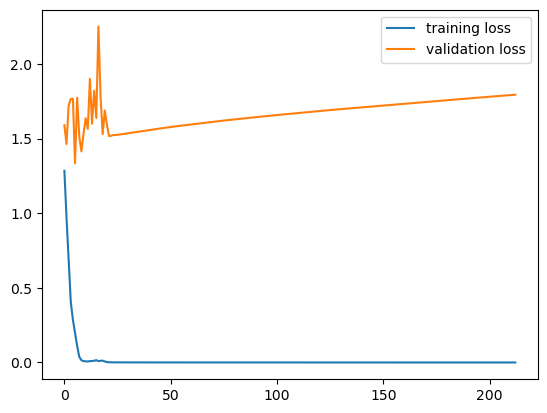

lamin
4939


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.3203 loss_val: 1.4212 time: 10.0205s
 Epoch: 0010 loss_train: 0.0174 loss_val: 1.5039 time: 8.9217s
 Epoch: 0020 loss_train: 0.0013 loss_val: 1.3237 time: 10.0872s
 Epoch: 0030 loss_train: 0.0008 loss_val: 1.3711 time: 9.5134s
 Epoch: 0040 loss_train: 0.0005 loss_val: 1.4071 time: 9.5718s
 Epoch: 0050 loss_train: 0.0004 loss_val: 1.4367 time: 10.1852s
 Epoch: 0060 loss_train: 0.0003 loss_val: 1.4623 time: 10.1392s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.4848 time: 10.6756s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.5051 time: 10.9380s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.5240 time: 10.5683s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.5415 time: 9.8880s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.5580 time: 10.1091s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.5737 time: 8.8036s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.5888 time: 7.9153s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.6030 time: 10.3951s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.61

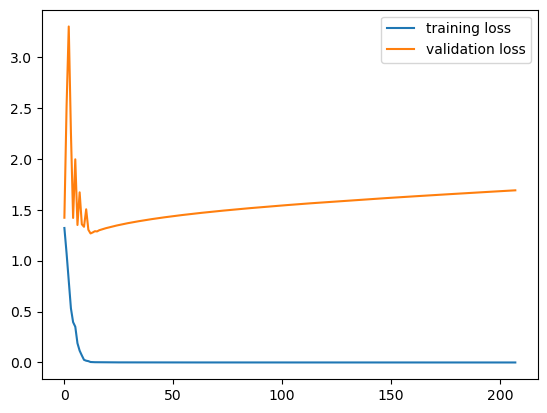

30
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
hold out: HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
hold out: HV1
HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
hold out: P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
P59
hold out: P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
hold out: P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
hold out: P22
P68
P16
P84
P15
30
cd16
4555


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1477 loss_val: 1.0988 time: 8.6018s
 Epoch: 0010 loss_train: 0.2150 loss_val: 2.2583 time: 9.1308s
 Epoch: 0020 loss_train: 0.0081 loss_val: 2.0717 time: 8.5640s
 Epoch: 0030 loss_train: 0.0028 loss_val: 2.1396 time: 9.5012s
 Epoch: 0040 loss_train: 0.0017 loss_val: 2.1945 time: 9.4923s
 Epoch: 0050 loss_train: 0.0015 loss_val: 2.2437 time: 9.2592s
 Epoch: 0060 loss_train: 0.0013 loss_val: 2.2764 time: 8.3017s
 Epoch: 0070 loss_train: 0.0011 loss_val: 2.3093 time: 9.7927s
 Epoch: 0080 loss_train: 0.0011 loss_val: 2.3333 time: 8.9191s
 Epoch: 0090 loss_train: 0.0010 loss_val: 2.3634 time: 8.1415s
 Epoch: 0100 loss_train: 0.0065 loss_val: 2.4708 time: 9.0216s
 Epoch: 0110 loss_train: 0.1265 loss_val: 2.8953 time: 10.3569s
 Epoch: 0120 loss_train: 0.0116 loss_val: 2.4979 time: 10.0931s
 Epoch: 0130 loss_train: 0.0038 loss_val: 2.4593 time: 9.8350s
 Epoch: 0140 loss_train: 0.0009 loss_val: 2.4992 time: 9.7975s
 Epoch: 0150 loss_train: 0.0011 loss_val: 2.5384 time

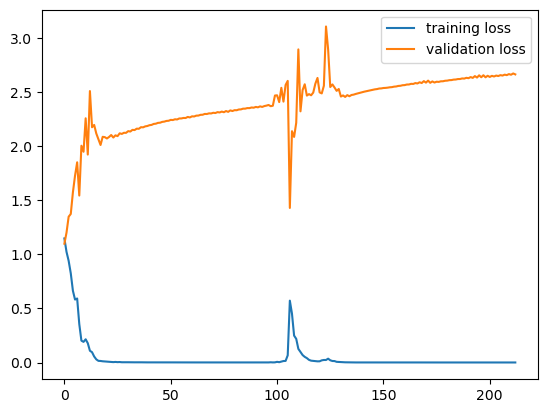

cd3
3760


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0627 loss_val: 1.0997 time: 7.6683s
 Epoch: 0010 loss_train: 0.0090 loss_val: 1.2072 time: 6.5573s
 Epoch: 0020 loss_train: 0.0284 loss_val: 1.3828 time: 8.5651s
 Epoch: 0030 loss_train: 0.0175 loss_val: 1.3089 time: 8.0665s
 Epoch: 0040 loss_train: 0.0539 loss_val: 1.6737 time: 7.0969s
 Epoch: 0050 loss_train: 0.0004 loss_val: 1.3380 time: 7.9757s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.3392 time: 6.9109s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.3439 time: 8.7091s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.3493 time: 9.2134s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.3549 time: 7.6878s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.3607 time: 6.2711s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.3663 time: 7.2034s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.3717 time: 7.8250s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.3772 time: 7.3346s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.3825 time: 7.8309s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.3879 time: 

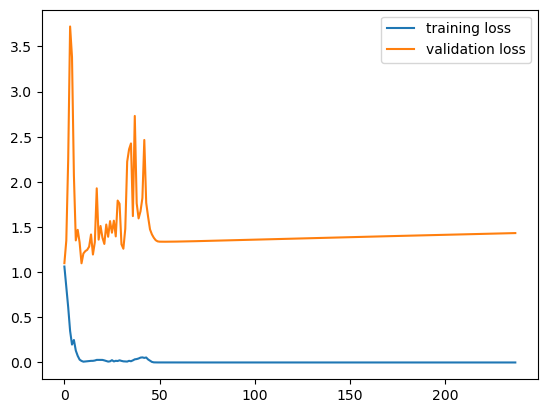

cd4
5580


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.3045 loss_val: 1.4947 time: 9.9739s
 Epoch: 0010 loss_train: 0.1906 loss_val: 2.0021 time: 9.2238s
 Epoch: 0020 loss_train: 0.0040 loss_val: 1.8657 time: 10.8255s
 Epoch: 0030 loss_train: 0.0011 loss_val: 1.9340 time: 12.4396s
 Epoch: 0040 loss_train: 0.0005 loss_val: 1.9854 time: 11.3814s
 Epoch: 0050 loss_train: 0.0004 loss_val: 2.0276 time: 10.3397s
 Epoch: 0060 loss_train: 0.0003 loss_val: 2.0637 time: 12.8552s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.0956 time: 9.4398s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.1244 time: 9.9753s
 Epoch: 0090 loss_train: 0.0001 loss_val: 2.1512 time: 11.1672s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.1763 time: 10.5297s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.2000 time: 11.3165s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.2227 time: 11.5227s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.2444 time: 10.9993s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.2656 time: 10.7860s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.

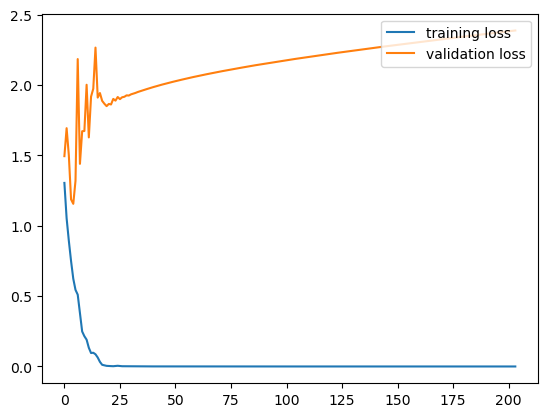

cd8
5604


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2447 loss_val: 1.6433 time: 11.5414s
 Epoch: 0010 loss_train: 0.0805 loss_val: 2.0132 time: 10.1208s
 Epoch: 0020 loss_train: 0.0037 loss_val: 1.8808 time: 11.2186s
 Epoch: 0030 loss_train: 0.0022 loss_val: 1.9530 time: 11.5023s
 Epoch: 0040 loss_train: 0.0018 loss_val: 2.0105 time: 10.2876s
 Epoch: 0050 loss_train: 0.0017 loss_val: 2.0364 time: 12.2918s
 Epoch: 0060 loss_train: 0.0015 loss_val: 2.1046 time: 9.1291s
 Epoch: 0070 loss_train: 0.0019 loss_val: 2.1165 time: 10.0482s
 Epoch: 0080 loss_train: 0.0021 loss_val: 2.1720 time: 10.8001s
 Epoch: 0090 loss_train: 0.1524 loss_val: 2.4682 time: 10.6051s
 Epoch: 0100 loss_train: 0.0025 loss_val: 2.1287 time: 10.7997s
 Epoch: 0110 loss_train: 0.0013 loss_val: 2.1938 time: 10.5531s
 Epoch: 0120 loss_train: 0.0012 loss_val: 2.2296 time: 10.3884s
 Epoch: 0130 loss_train: 0.0011 loss_val: 2.2548 time: 10.4560s
 Epoch: 0140 loss_train: 0.0012 loss_val: 2.2947 time: 12.4877s
 Epoch: 0150 loss_train: 0.0010 loss_val:

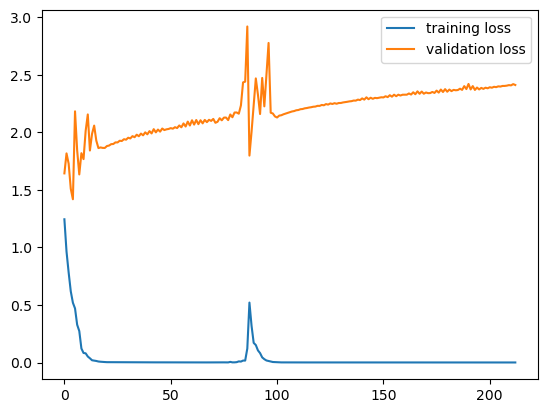

gh2ax
4837


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2561 loss_val: 1.6539 time: 10.3178s
 Epoch: 0010 loss_train: 0.0072 loss_val: 1.2260 time: 8.7628s
 Epoch: 0020 loss_train: 0.0008 loss_val: 1.2520 time: 9.8216s
 Epoch: 0030 loss_train: 0.0005 loss_val: 1.2834 time: 10.3376s
 Epoch: 0040 loss_train: 0.0004 loss_val: 1.3088 time: 10.2276s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.3307 time: 9.6725s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.3500 time: 8.6708s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.3673 time: 9.0470s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.3832 time: 9.2214s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.3979 time: 10.4697s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.4118 time: 10.9226s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.4247 time: 10.6872s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.4372 time: 9.4235s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.4491 time: 10.7497s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.4606 time: 8.6068s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.4717

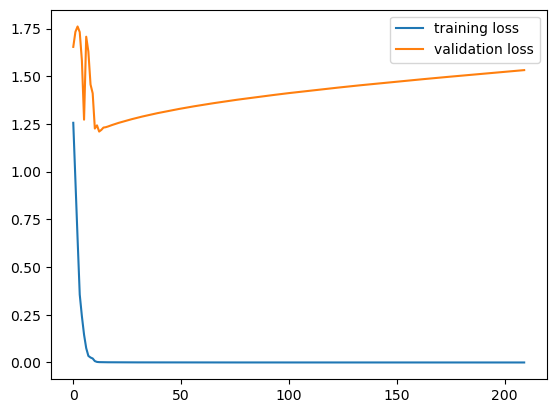

lamin
4838


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.3273 loss_val: 1.3963 time: 9.2929s
 Epoch: 0010 loss_train: 0.0180 loss_val: 1.1829 time: 8.4570s
 Epoch: 0020 loss_train: 0.0013 loss_val: 1.1810 time: 9.4125s
 Epoch: 0030 loss_train: 0.0007 loss_val: 1.2163 time: 9.2575s
 Epoch: 0040 loss_train: 0.0005 loss_val: 1.2439 time: 10.5291s
 Epoch: 0050 loss_train: 0.0004 loss_val: 1.2667 time: 9.2687s
 Epoch: 0060 loss_train: 0.0003 loss_val: 1.2866 time: 8.9118s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.3042 time: 9.3778s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.3203 time: 10.6110s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.3350 time: 9.4546s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.3489 time: 8.5412s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.3620 time: 8.3938s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.3744 time: 7.3795s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.3862 time: 8.9341s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.3977 time: 9.5682s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.4086 time

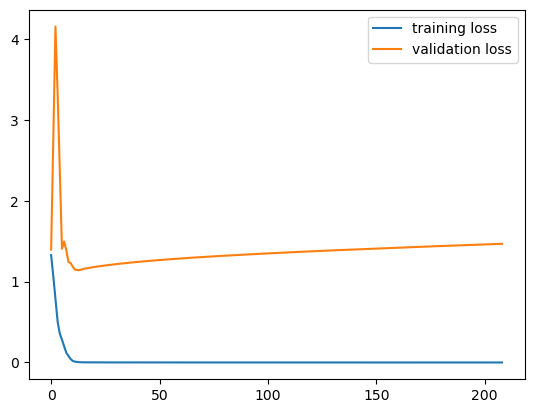

31
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
hold out: HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
hold out: HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
P55
P50
hold out: P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
P63
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
hold out: P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
hold out: P46
P47
P29
P52
P57
P22
P68
P16
P84
P15
31
cd16
4490


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1655 loss_val: 1.1024 time: 9.4555s
 Epoch: 0010 loss_train: 0.1552 loss_val: 2.0086 time: 8.9094s
 Epoch: 0020 loss_train: 0.0017 loss_val: 2.0584 time: 9.8595s
 Epoch: 0030 loss_train: 0.0006 loss_val: 2.1236 time: 8.9513s
 Epoch: 0040 loss_train: 0.0004 loss_val: 2.1725 time: 9.1494s
 Epoch: 0050 loss_train: 0.0003 loss_val: 2.2104 time: 10.3324s
 Epoch: 0060 loss_train: 0.0002 loss_val: 2.2421 time: 9.6987s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.2700 time: 9.5744s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.2953 time: 9.8593s
 Epoch: 0090 loss_train: 0.0001 loss_val: 2.3192 time: 8.0699s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.3414 time: 10.2162s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.3625 time: 9.7096s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.3828 time: 10.7933s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.4023 time: 10.3360s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.4212 time: 9.8149s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.4394 ti

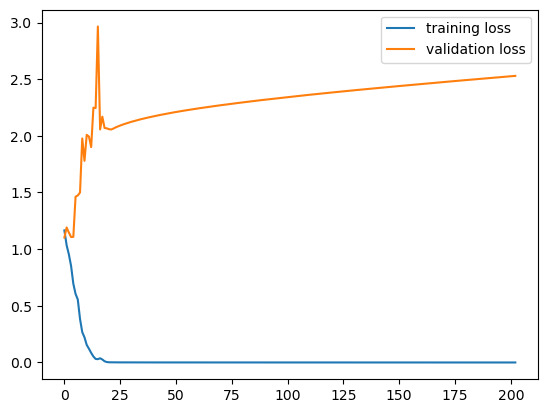

cd3
3802


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0856 loss_val: 1.0865 time: 8.3724s
 Epoch: 0010 loss_train: 0.0143 loss_val: 1.3405 time: 6.8898s
 Epoch: 0020 loss_train: 0.0009 loss_val: 1.1168 time: 7.8312s
 Epoch: 0030 loss_train: 0.0005 loss_val: 1.1418 time: 7.9572s
 Epoch: 0040 loss_train: 0.0004 loss_val: 1.1633 time: 6.5310s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.1818 time: 7.3951s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.1981 time: 6.2821s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.2127 time: 6.6282s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.2263 time: 6.9346s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.2388 time: 7.4371s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.2505 time: 7.3166s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.2617 time: 7.3644s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.2722 time: 8.1147s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.2824 time: 6.9459s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.2921 time: 8.6093s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.3014 time: 

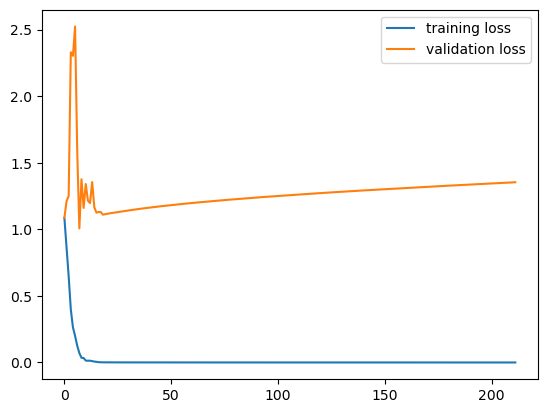

cd4
5518


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.3450 loss_val: 1.5443 time: 10.7575s
 Epoch: 0010 loss_train: 0.1166 loss_val: 2.0096 time: 8.7955s
 Epoch: 0020 loss_train: 0.0023 loss_val: 1.9727 time: 11.4367s
 Epoch: 0030 loss_train: 0.0007 loss_val: 2.0350 time: 10.8441s
 Epoch: 0040 loss_train: 0.0005 loss_val: 2.0837 time: 11.9259s
 Epoch: 0050 loss_train: 0.0004 loss_val: 2.1237 time: 10.8556s
 Epoch: 0060 loss_train: 0.0003 loss_val: 2.1582 time: 10.9732s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.1891 time: 9.8001s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.2173 time: 10.3991s
 Epoch: 0090 loss_train: 0.0001 loss_val: 2.2436 time: 10.7200s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.2680 time: 11.1030s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.2916 time: 11.5559s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.3141 time: 9.6572s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.3356 time: 11.6403s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.3564 time: 10.5820s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2

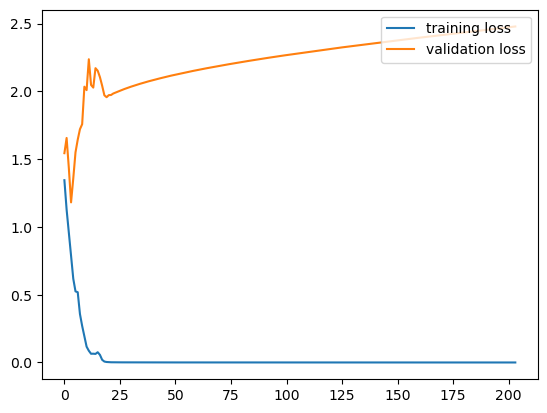

cd8
5545


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2822 loss_val: 1.6683 time: 11.5910s
 Epoch: 0010 loss_train: 0.0414 loss_val: 2.0758 time: 12.4400s
 Epoch: 0020 loss_train: 0.0013 loss_val: 1.8607 time: 11.9633s
 Epoch: 0030 loss_train: 0.0007 loss_val: 1.9347 time: 10.4014s
 Epoch: 0040 loss_train: 0.0005 loss_val: 1.9897 time: 11.0008s
 Epoch: 0050 loss_train: 0.0003 loss_val: 2.0347 time: 11.5123s
 Epoch: 0060 loss_train: 0.0003 loss_val: 2.0731 time: 10.4711s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.1070 time: 11.2685s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.1376 time: 11.5654s
 Epoch: 0090 loss_train: 0.0001 loss_val: 2.1656 time: 9.6500s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.1919 time: 10.9524s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.2165 time: 10.3259s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.2403 time: 11.1114s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.2629 time: 9.8075s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.2846 time: 10.2531s
 Epoch: 0150 loss_train: 0.0001 loss_val: 

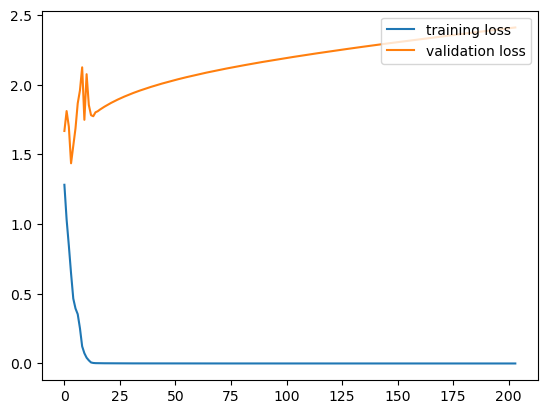

gh2ax
4931


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2647 loss_val: 1.6754 time: 8.6716s
 Epoch: 0010 loss_train: 0.0024 loss_val: 1.2003 time: 10.4367s
 Epoch: 0020 loss_train: 0.0009 loss_val: 1.2525 time: 9.3043s
 Epoch: 0030 loss_train: 0.0005 loss_val: 1.2865 time: 9.8020s
 Epoch: 0040 loss_train: 0.0004 loss_val: 1.3138 time: 9.4667s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.3371 time: 8.4427s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.3575 time: 7.4177s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.3757 time: 8.7606s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.3925 time: 8.9655s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.4080 time: 8.8043s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.4226 time: 9.9791s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.4365 time: 8.6526s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.4496 time: 8.8587s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.4622 time: 9.0009s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.4745 time: 9.1191s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.4864 time:

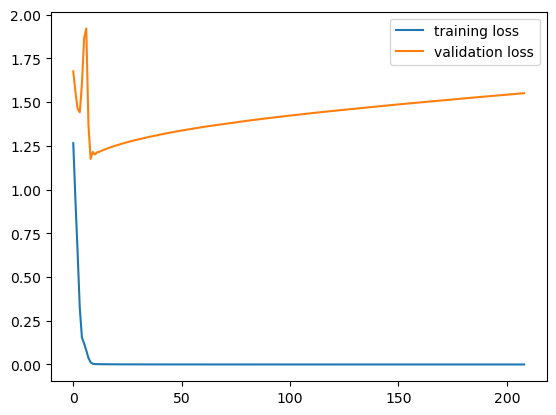

lamin
4932


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.3023 loss_val: 1.4386 time: 9.2480s
 Epoch: 0010 loss_train: 0.0251 loss_val: 1.1600 time: 9.0328s
 Epoch: 0020 loss_train: 0.0013 loss_val: 1.1487 time: 8.7522s
 Epoch: 0030 loss_train: 0.0007 loss_val: 1.1874 time: 9.9401s
 Epoch: 0040 loss_train: 0.0005 loss_val: 1.2165 time: 9.8106s
 Epoch: 0050 loss_train: 0.0004 loss_val: 1.2406 time: 10.7218s
 Epoch: 0060 loss_train: 0.0003 loss_val: 1.2613 time: 8.5450s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.2797 time: 9.2590s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.2966 time: 8.5192s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.3122 time: 11.0232s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.3267 time: 10.1797s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.3403 time: 9.5710s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.3533 time: 9.9025s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.3656 time: 9.1743s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.3777 time: 8.9496s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.3892 tim

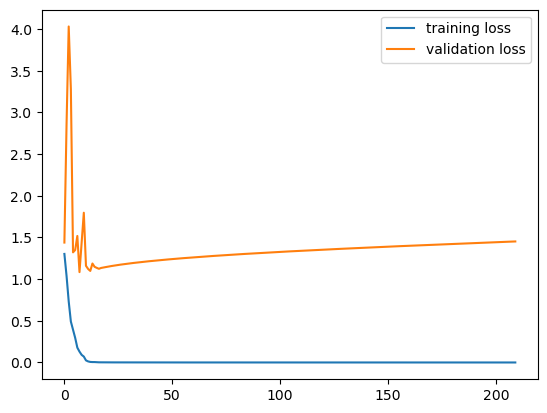

32
controls
dapi_gh2ax_lamin
hold out: HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
hold out: HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
hold out: P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
hold out: P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
hold out: P68
P16
P84
P15
32
cd16
4629


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1520 loss_val: 1.1018 time: 9.6359s
 Epoch: 0010 loss_train: 0.2102 loss_val: 2.0861 time: 7.1147s
 Epoch: 0020 loss_train: 0.0114 loss_val: 2.2449 time: 8.7771s
 Epoch: 0030 loss_train: 0.0007 loss_val: 2.2975 time: 9.6122s
 Epoch: 0040 loss_train: 0.0004 loss_val: 2.3483 time: 9.1785s
 Epoch: 0050 loss_train: 0.0003 loss_val: 2.3882 time: 10.3507s
 Epoch: 0060 loss_train: 0.0002 loss_val: 2.4221 time: 7.9258s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.4523 time: 9.5881s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.4798 time: 9.8262s
 Epoch: 0090 loss_train: 0.0001 loss_val: 2.5052 time: 9.8223s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.5292 time: 8.7906s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.5520 time: 8.6186s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.5737 time: 8.4140s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.5949 time: 9.4714s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.6154 time: 8.6287s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.6353 time:

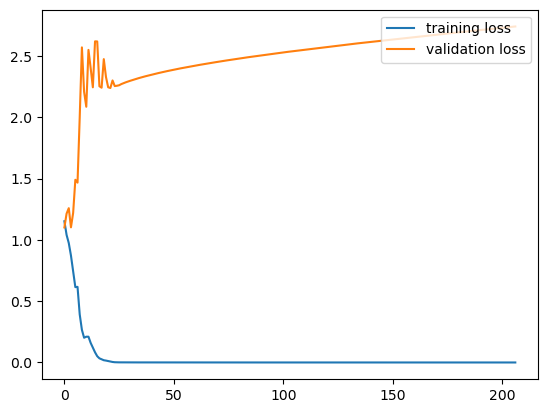

cd3
3806


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0785 loss_val: 1.1026 time: 7.6366s
 Epoch: 0010 loss_train: 0.0069 loss_val: 1.2096 time: 7.3301s
 Epoch: 0020 loss_train: 0.0010 loss_val: 1.2684 time: 8.4341s
 Epoch: 0030 loss_train: 0.0006 loss_val: 1.3065 time: 6.7377s
 Epoch: 0040 loss_train: 0.0004 loss_val: 1.3364 time: 7.6307s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.3611 time: 7.0776s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.3824 time: 6.3547s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.4015 time: 7.2457s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.4187 time: 7.4383s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.4345 time: 8.0721s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.4492 time: 6.7039s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.4630 time: 7.6303s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.4762 time: 7.4140s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.4888 time: 6.5848s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.5008 time: 7.8063s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.5123 time: 

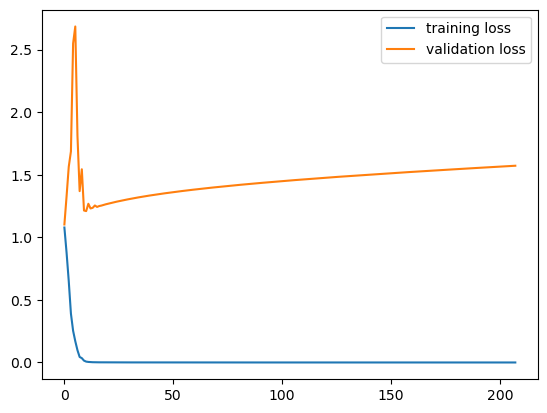

cd4
5663


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.3309 loss_val: 1.5279 time: 10.6652s
 Epoch: 0010 loss_train: 0.2037 loss_val: 2.1906 time: 11.1632s
 Epoch: 0020 loss_train: 0.0084 loss_val: 2.1014 time: 11.7686s
 Epoch: 0030 loss_train: 0.0014 loss_val: 2.1186 time: 9.7598s
 Epoch: 0040 loss_train: 0.0010 loss_val: 2.1751 time: 10.8898s
 Epoch: 0050 loss_train: 0.0009 loss_val: 2.2209 time: 9.6805s
 Epoch: 0060 loss_train: 0.0007 loss_val: 2.2574 time: 11.9028s
 Epoch: 0070 loss_train: 0.0007 loss_val: 2.2932 time: 9.9882s
 Epoch: 0080 loss_train: 0.0005 loss_val: 2.3188 time: 10.8947s
 Epoch: 0090 loss_train: 0.0005 loss_val: 2.3533 time: 11.0436s
 Epoch: 0100 loss_train: 0.0005 loss_val: 2.3826 time: 9.8697s
 Epoch: 0110 loss_train: 0.0004 loss_val: 2.4019 time: 10.8779s
 Epoch: 0120 loss_train: 0.0004 loss_val: 2.4315 time: 10.5495s
 Epoch: 0130 loss_train: 0.0004 loss_val: 2.4576 time: 10.4175s
 Epoch: 0140 loss_train: 0.0005 loss_val: 2.4913 time: 10.9953s
 Epoch: 0150 loss_train: 0.2763 loss_val: 2.

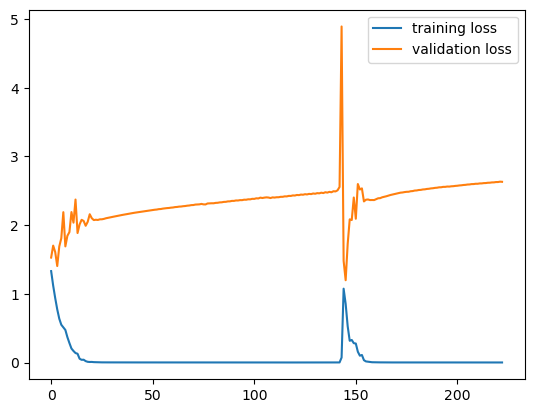

cd8
5687


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2820 loss_val: 1.6683 time: 8.4096s
 Epoch: 0010 loss_train: 0.0374 loss_val: 2.0157 time: 10.0668s
 Epoch: 0020 loss_train: 0.0077 loss_val: 2.8130 time: 10.2806s
 Epoch: 0030 loss_train: 0.0027 loss_val: 2.2014 time: 10.3987s
 Epoch: 0040 loss_train: 0.0005 loss_val: 2.2236 time: 10.5841s
 Epoch: 0050 loss_train: 0.0003 loss_val: 2.2641 time: 8.9456s
 Epoch: 0060 loss_train: 0.0002 loss_val: 2.2984 time: 9.5936s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.3292 time: 11.0821s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.3576 time: 10.9564s
 Epoch: 0090 loss_train: 0.0001 loss_val: 2.3842 time: 10.3561s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.4092 time: 11.2831s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.4331 time: 8.6416s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.4562 time: 11.6161s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.4787 time: 11.7091s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.5004 time: 11.4500s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.

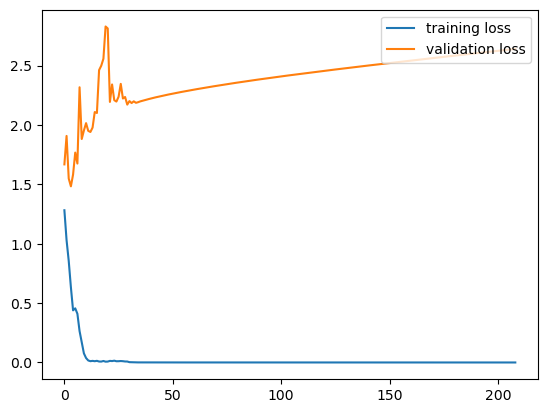

gh2ax
4889


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2794 loss_val: 1.6679 time: 8.9281s
 Epoch: 0010 loss_train: 0.0028 loss_val: 1.3983 time: 8.1968s
 Epoch: 0020 loss_train: 0.0010 loss_val: 1.4546 time: 8.7603s
 Epoch: 0030 loss_train: 0.0006 loss_val: 1.4927 time: 9.1411s
 Epoch: 0040 loss_train: 0.0004 loss_val: 1.5229 time: 7.4461s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.5481 time: 8.5889s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.5702 time: 9.1176s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.5901 time: 9.0110s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.6083 time: 9.8875s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.6252 time: 7.8215s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.6410 time: 7.8582s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.6559 time: 8.6632s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.6702 time: 9.3545s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.6840 time: 8.9495s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.6973 time: 9.0614s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.7101 time: 

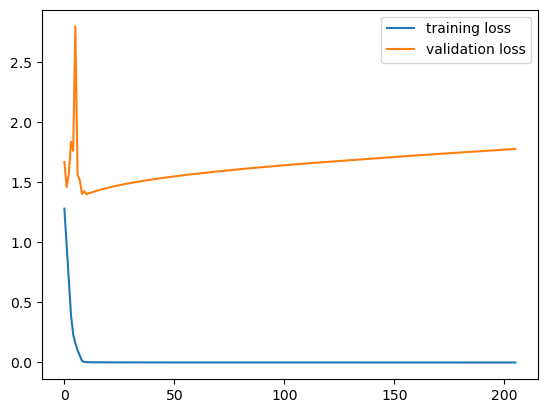

lamin
4890


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.3478 loss_val: 1.3959 time: 8.0642s
 Epoch: 0010 loss_train: 0.0268 loss_val: 1.3895 time: 9.6638s
 Epoch: 0020 loss_train: 0.0013 loss_val: 1.3011 time: 8.8380s
 Epoch: 0030 loss_train: 0.0007 loss_val: 1.3378 time: 9.5452s
 Epoch: 0040 loss_train: 0.0005 loss_val: 1.3671 time: 9.0230s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.3919 time: 7.2227s
 Epoch: 0060 loss_train: 0.0003 loss_val: 1.4136 time: 8.9177s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.4331 time: 9.5170s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.4510 time: 8.1987s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.4676 time: 9.3416s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.4831 time: 9.5032s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.4978 time: 8.2333s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.5119 time: 8.8217s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.5253 time: 8.9703s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.5383 time: 9.0941s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.5509 time: 

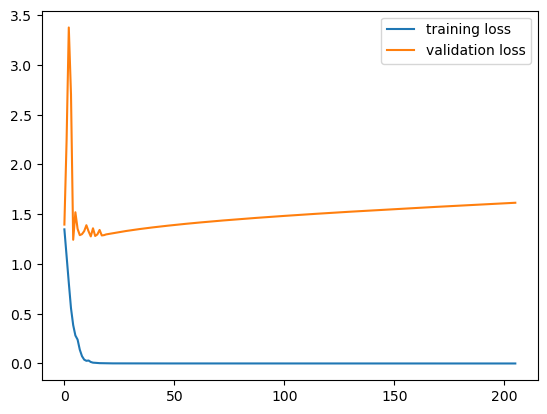

33
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
hold out: HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
hold out: HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
hold out: P55
P50
P24
dapi_cd16_cd4_cd8
hold out: P55
P56
P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
hold out: P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
hold out: P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
hold out: P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
P68
P16
P84
hold out: P15
33
cd16
4560


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1485 loss_val: 1.0998 time: 9.0994s
 Epoch: 0010 loss_train: 0.2159 loss_val: 1.7553 time: 9.2235s
 Epoch: 0020 loss_train: 0.0173 loss_val: 2.2211 time: 6.5855s
 Epoch: 0030 loss_train: 0.0020 loss_val: 2.0184 time: 7.2553s
 Epoch: 0040 loss_train: 0.0005 loss_val: 2.0697 time: 8.4684s
 Epoch: 0050 loss_train: 0.0003 loss_val: 2.1124 time: 8.6580s
 Epoch: 0060 loss_train: 0.0003 loss_val: 2.1474 time: 8.9308s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.1780 time: 8.8462s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.2055 time: 8.2414s
 Epoch: 0090 loss_train: 0.0001 loss_val: 2.2307 time: 7.9701s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.2543 time: 8.6893s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.2765 time: 9.0007s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.2977 time: 8.8776s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.3180 time: 9.6139s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.3375 time: 8.3884s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.3563 time: 

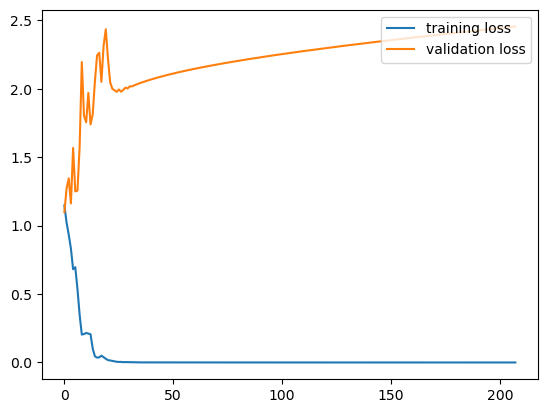

cd3
3772


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0657 loss_val: 1.0997 time: 7.7976s
 Epoch: 0010 loss_train: 0.0171 loss_val: 1.5165 time: 6.9135s
 Epoch: 0020 loss_train: 0.0010 loss_val: 1.2495 time: 7.3291s
 Epoch: 0030 loss_train: 0.0006 loss_val: 1.2891 time: 5.8195s
 Epoch: 0040 loss_train: 0.0004 loss_val: 1.3194 time: 7.9261s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.3446 time: 7.0217s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.3663 time: 7.6060s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.3856 time: 6.2912s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.4031 time: 5.8240s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.4191 time: 5.4533s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.4340 time: 8.0401s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.4478 time: 6.3255s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.4611 time: 6.2206s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.4737 time: 6.8919s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.4856 time: 6.6714s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.4972 time: 

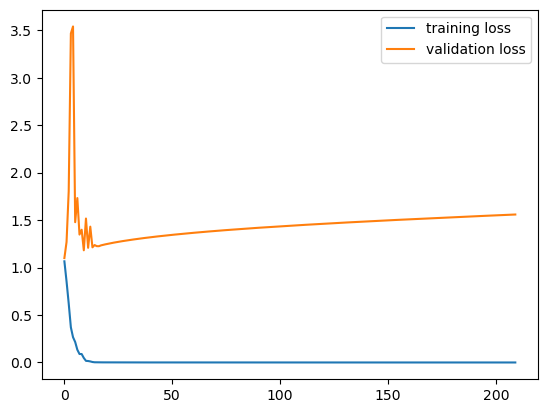

cd4
5602


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.3070 loss_val: 1.4991 time: 10.3044s
 Epoch: 0010 loss_train: 0.2120 loss_val: 1.8560 time: 9.4677s
 Epoch: 0020 loss_train: 0.0069 loss_val: 2.1110 time: 9.3220s
 Epoch: 0030 loss_train: 0.0116 loss_val: 2.6346 time: 11.3671s
 Epoch: 0040 loss_train: 0.0009 loss_val: 2.1089 time: 11.1749s
 Epoch: 0050 loss_train: 0.0007 loss_val: 2.1521 time: 11.6499s
 Epoch: 0060 loss_train: 0.0006 loss_val: 2.1870 time: 11.0155s
 Epoch: 0070 loss_train: 0.0005 loss_val: 2.2126 time: 9.6891s
 Epoch: 0080 loss_train: 0.0006 loss_val: 2.2463 time: 10.2454s
 Epoch: 0090 loss_train: 0.0004 loss_val: 2.2614 time: 11.3875s
 Epoch: 0100 loss_train: 0.0005 loss_val: 2.2897 time: 10.2387s
 Epoch: 0110 loss_train: 0.0004 loss_val: 2.3118 time: 10.4810s
 Epoch: 0120 loss_train: 0.0006 loss_val: 2.3520 time: 8.9647s
 Epoch: 0130 loss_train: 0.0003 loss_val: 2.3343 time: 9.9460s
 Epoch: 0140 loss_train: 0.0004 loss_val: 2.3732 time: 8.7514s
 Epoch: 0150 loss_train: 0.0004 loss_val: 2.39

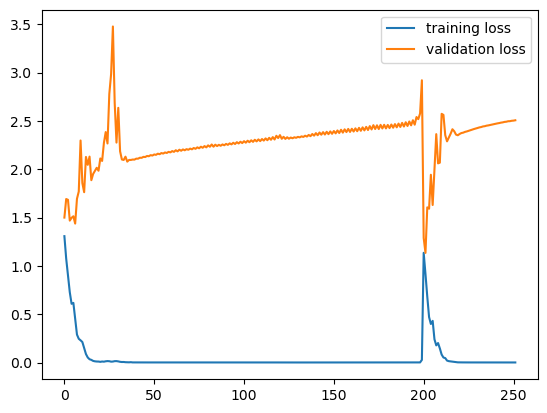

cd8
5625


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2739 loss_val: 1.6763 time: 9.3578s
 Epoch: 0010 loss_train: 0.0824 loss_val: 1.7768 time: 10.1855s
 Epoch: 0020 loss_train: 0.0032 loss_val: 1.8662 time: 10.1151s
 Epoch: 0030 loss_train: 0.0011 loss_val: 1.9441 time: 11.3229s
 Epoch: 0040 loss_train: 0.0010 loss_val: 2.0043 time: 10.9062s
 Epoch: 0050 loss_train: 0.0008 loss_val: 2.0468 time: 9.4519s
 Epoch: 0060 loss_train: 0.0007 loss_val: 2.0854 time: 11.0223s
 Epoch: 0070 loss_train: 0.0007 loss_val: 2.1222 time: 10.4721s
 Epoch: 0080 loss_train: 0.2381 loss_val: 2.1565 time: 12.4421s
 Epoch: 0090 loss_train: 0.0025 loss_val: 2.1330 time: 12.1332s
 Epoch: 0100 loss_train: 0.0007 loss_val: 2.2071 time: 9.8567s
 Epoch: 0110 loss_train: 0.0006 loss_val: 2.2463 time: 10.4648s
 Epoch: 0120 loss_train: 0.0006 loss_val: 2.2826 time: 10.8739s
 Epoch: 0130 loss_train: 0.0004 loss_val: 2.3062 time: 9.6306s
 Epoch: 0140 loss_train: 0.0005 loss_val: 2.3277 time: 10.5993s
 Epoch: 0150 loss_train: 0.0004 loss_val: 2.

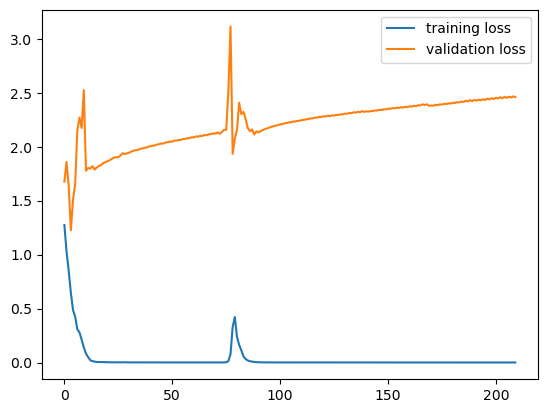

gh2ax
4892


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2777 loss_val: 1.6051 time: 9.5550s
 Epoch: 0010 loss_train: 0.0033 loss_val: 1.3776 time: 8.2520s
 Epoch: 0020 loss_train: 0.0010 loss_val: 1.4308 time: 9.5600s
 Epoch: 0030 loss_train: 0.0006 loss_val: 1.4727 time: 8.0767s
 Epoch: 0040 loss_train: 0.0004 loss_val: 1.5053 time: 8.5949s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.5322 time: 8.5522s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.5553 time: 8.4340s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.5760 time: 9.6634s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.5946 time: 9.6888s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.6121 time: 9.7635s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.6284 time: 7.4895s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.6438 time: 8.5010s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.6583 time: 9.4008s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.6723 time: 8.5740s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.6859 time: 8.3344s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.6989 time: 

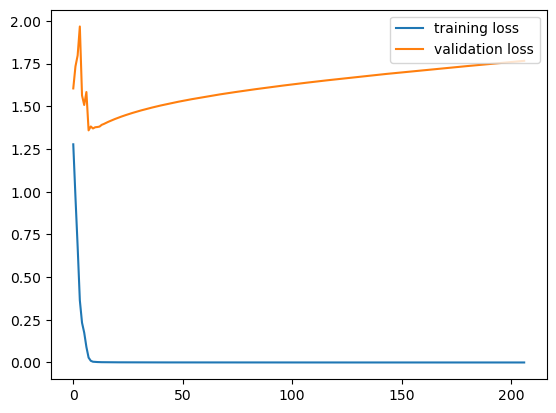

lamin
4893


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.3483 loss_val: 1.3780 time: 8.3455s
 Epoch: 0010 loss_train: 0.0562 loss_val: 1.5426 time: 7.7610s
 Epoch: 0020 loss_train: 0.0012 loss_val: 1.3058 time: 9.4911s
 Epoch: 0030 loss_train: 0.0007 loss_val: 1.3401 time: 8.2640s
 Epoch: 0040 loss_train: 0.0005 loss_val: 1.3677 time: 8.8545s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.3910 time: 8.8826s
 Epoch: 0060 loss_train: 0.0003 loss_val: 1.4114 time: 10.2911s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.4296 time: 9.4794s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.4464 time: 8.3371s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.4619 time: 9.8967s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.4764 time: 8.3587s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.4901 time: 8.9419s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.5033 time: 8.5323s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.5158 time: 8.1822s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.5279 time: 7.5826s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.5397 time:

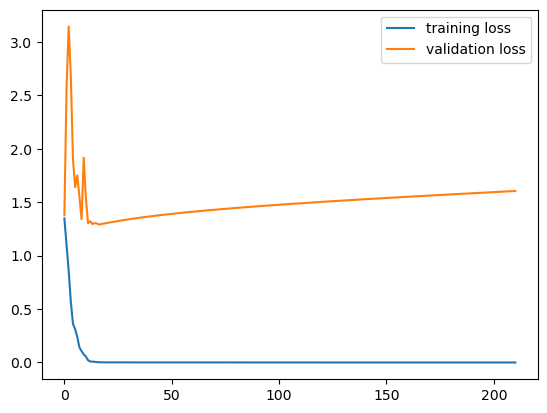

34
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
hold out: HV8
HV3
HV6
dapi_cd8_cd4
HV1
hold out: HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
hold out: P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
hold out: P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
hold out: P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
hold out: P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
hold out: P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
hold out: P47
P29
P52
P57
P22
P68
P16
P84
P15
34
cd16
4544


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1673 loss_val: 1.1019 time: 7.8674s
 Epoch: 0010 loss_train: 0.2396 loss_val: 1.7452 time: 5.5191s
 Epoch: 0020 loss_train: 0.0393 loss_val: 2.6622 time: 6.6239s
 Epoch: 0030 loss_train: 0.0363 loss_val: 2.4469 time: 6.0614s
 Epoch: 0040 loss_train: 0.0021 loss_val: 2.2506 time: 6.0764s
 Epoch: 0050 loss_train: 0.0004 loss_val: 2.2919 time: 8.3353s
 Epoch: 0060 loss_train: 0.0003 loss_val: 2.3275 time: 7.2408s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.3582 time: 8.4427s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.3855 time: 6.4416s
 Epoch: 0090 loss_train: 0.0002 loss_val: 2.4103 time: 8.0797s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.4332 time: 7.5155s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.4551 time: 9.4659s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.4758 time: 7.8043s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.4958 time: 7.8906s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.5152 time: 7.1060s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.5340 time: 

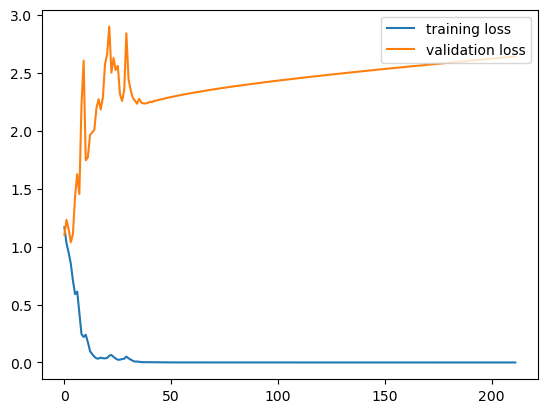

cd3
3781


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0582 loss_val: 1.1064 time: 6.3378s
 Epoch: 0010 loss_train: 0.0201 loss_val: 1.3839 time: 6.7391s
 Epoch: 0020 loss_train: 0.0011 loss_val: 1.2649 time: 7.0465s
 Epoch: 0030 loss_train: 0.0006 loss_val: 1.3040 time: 6.8158s
 Epoch: 0040 loss_train: 0.0004 loss_val: 1.3348 time: 6.1439s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.3607 time: 5.7142s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.3830 time: 6.5445s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.4027 time: 6.5609s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.4205 time: 6.2264s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.4368 time: 6.5684s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.4522 time: 6.2452s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.4663 time: 6.4927s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.4800 time: 5.9826s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.4928 time: 5.2205s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.5051 time: 7.4394s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.5169 time: 

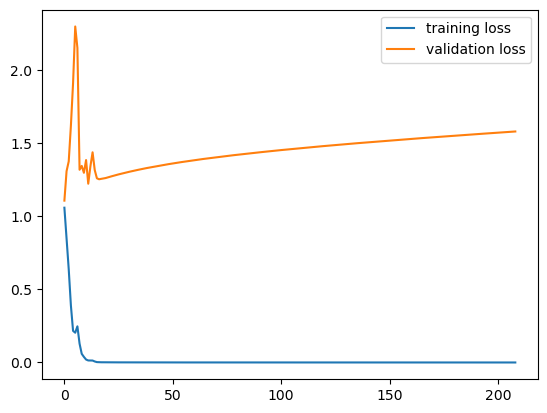

cd4
5579


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2842 loss_val: 1.5047 time: 9.6210s
 Epoch: 0010 loss_train: 0.1244 loss_val: 1.7312 time: 8.3166s
 Epoch: 0020 loss_train: 0.0112 loss_val: 2.0092 time: 10.1085s
 Epoch: 0030 loss_train: 0.0024 loss_val: 2.0275 time: 9.9524s
 Epoch: 0040 loss_train: 0.0013 loss_val: 2.0511 time: 9.3575s
 Epoch: 0050 loss_train: 0.0012 loss_val: 2.0867 time: 8.3008s
 Epoch: 0060 loss_train: 0.0011 loss_val: 2.1189 time: 9.0869s
 Epoch: 0070 loss_train: 0.0009 loss_val: 2.1373 time: 9.8155s
 Epoch: 0080 loss_train: 0.0009 loss_val: 2.1689 time: 10.1150s
 Epoch: 0090 loss_train: 0.0009 loss_val: 2.1924 time: 9.2410s
 Epoch: 0100 loss_train: 0.0012 loss_val: 2.2267 time: 9.0375s
 Epoch: 0110 loss_train: 0.0006 loss_val: 2.2155 time: 9.2857s
 Epoch: 0120 loss_train: 0.0006 loss_val: 2.2507 time: 10.4478s
 Epoch: 0130 loss_train: 0.0007 loss_val: 2.2798 time: 9.9621s
 Epoch: 0140 loss_train: 0.0007 loss_val: 2.3014 time: 10.0383s
 Epoch: 0150 loss_train: 0.0007 loss_val: 2.3207 ti

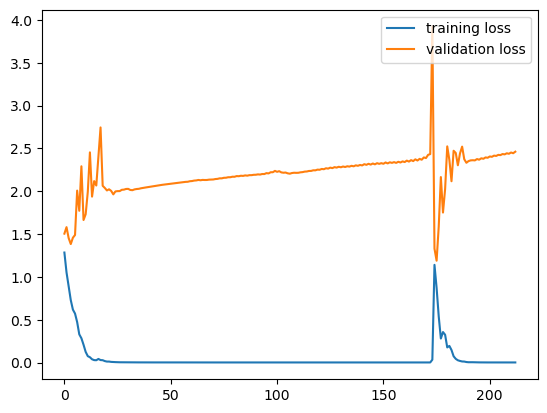

cd8
5605


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2636 loss_val: 1.6506 time: 11.3001s
 Epoch: 0010 loss_train: 0.0741 loss_val: 2.3680 time: 9.1862s
 Epoch: 0020 loss_train: 0.0022 loss_val: 1.9316 time: 8.7023s
 Epoch: 0030 loss_train: 0.0009 loss_val: 2.0036 time: 10.3943s
 Epoch: 0040 loss_train: 0.0005 loss_val: 2.0581 time: 9.7025s
 Epoch: 0050 loss_train: 0.0004 loss_val: 2.1024 time: 8.9232s
 Epoch: 0060 loss_train: 0.0003 loss_val: 2.1409 time: 10.8991s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.1749 time: 9.9075s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.2059 time: 10.6526s
 Epoch: 0090 loss_train: 0.0002 loss_val: 2.2346 time: 8.9481s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.2616 time: 10.1696s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.2871 time: 9.9869s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.3114 time: 10.7196s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.3347 time: 10.8834s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.3573 time: 8.8279s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.3792

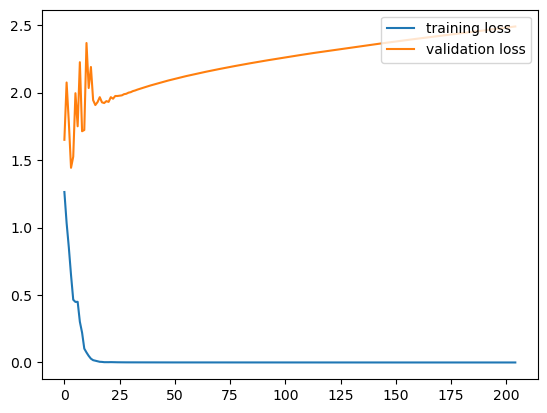

gh2ax
4926


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2783 loss_val: 1.5745 time: 7.2739s
 Epoch: 0010 loss_train: 0.0030 loss_val: 1.3548 time: 9.5151s
 Epoch: 0020 loss_train: 0.0010 loss_val: 1.4397 time: 8.6283s
 Epoch: 0030 loss_train: 0.0006 loss_val: 1.4839 time: 7.5244s
 Epoch: 0040 loss_train: 0.0004 loss_val: 1.5179 time: 6.6419s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.5463 time: 7.2283s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.5705 time: 8.5079s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.5922 time: 9.4869s
 Epoch: 0080 loss_train: 0.0001 loss_val: 1.6123 time: 9.2116s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.6307 time: 8.7143s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.6480 time: 9.4767s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.6641 time: 8.9314s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.6797 time: 8.1555s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.6942 time: 9.1674s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.7085 time: 8.3471s
 Epoch: 0150 loss_train: 0.0000 loss_val: 1.7224 time: 

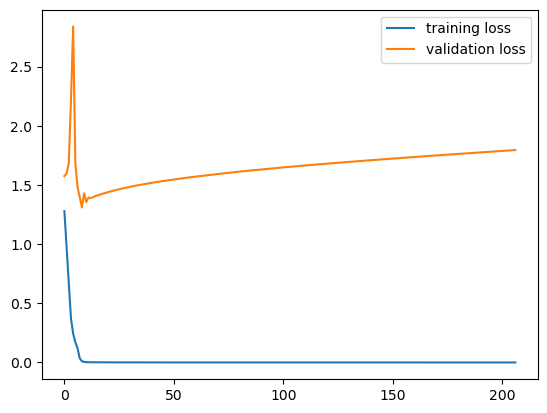

lamin
4927


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.3462 loss_val: 1.3981 time: 9.5406s
 Epoch: 0010 loss_train: 0.0152 loss_val: 1.2171 time: 9.5865s
 Epoch: 0020 loss_train: 0.0021 loss_val: 1.3161 time: 8.2786s
 Epoch: 0030 loss_train: 0.0008 loss_val: 1.3459 time: 9.1209s
 Epoch: 0040 loss_train: 0.0005 loss_val: 1.3756 time: 9.4310s
 Epoch: 0050 loss_train: 0.0004 loss_val: 1.4001 time: 8.4637s
 Epoch: 0060 loss_train: 0.0003 loss_val: 1.4217 time: 8.6063s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.4406 time: 7.8101s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.4583 time: 8.6488s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.4744 time: 10.2077s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.4896 time: 9.0262s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.5039 time: 8.0201s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.5176 time: 8.1841s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.5310 time: 7.5227s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.5437 time: 8.8490s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.5563 time:

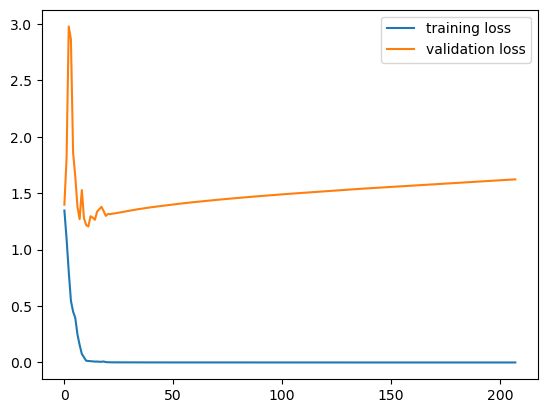

35
controls
dapi_gh2ax_lamin
HV5
HV4
hold out: HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
HV3
hold out: HV2
headneck
dapi_gh2ax_lamin_cd3
hold out: P72
P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
hold out: P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
hold out: P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
hold out: P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
hold out: P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
hold out: P57
P22
P68
P16
P84
P15
35
cd16
4608


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.1395 loss_val: 1.1058 time: 8.3000s
 Epoch: 0010 loss_train: 0.2049 loss_val: 1.7918 time: 7.1872s
 Epoch: 0020 loss_train: 0.0154 loss_val: 2.2642 time: 8.5087s
 Epoch: 0030 loss_train: 0.0023 loss_val: 2.2543 time: 8.0048s
 Epoch: 0040 loss_train: 0.0004 loss_val: 2.2884 time: 10.0948s
 Epoch: 0050 loss_train: 0.0003 loss_val: 2.3289 time: 9.0378s
 Epoch: 0060 loss_train: 0.0002 loss_val: 2.3634 time: 8.1117s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.3938 time: 8.1162s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.4217 time: 8.9370s
 Epoch: 0090 loss_train: 0.0001 loss_val: 2.4476 time: 7.7094s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.4720 time: 7.6726s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.4951 time: 9.1312s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.5172 time: 8.1156s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.5385 time: 8.2833s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.5593 time: 7.9046s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.5791 time:

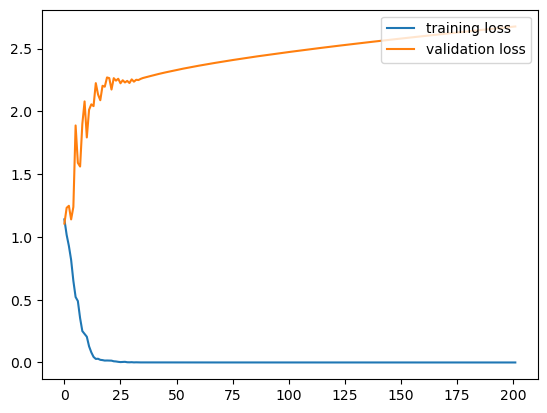

cd3
3822


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0994 loss_val: 1.0959 time: 6.1390s
 Epoch: 0010 loss_train: 0.0468 loss_val: 1.2445 time: 7.8182s
 Epoch: 0020 loss_train: 0.0012 loss_val: 1.2361 time: 6.3476s
 Epoch: 0030 loss_train: 0.0007 loss_val: 1.2728 time: 6.5959s
 Epoch: 0040 loss_train: 0.0005 loss_val: 1.3006 time: 7.4140s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.3235 time: 7.2894s
 Epoch: 0060 loss_train: 0.0003 loss_val: 1.3435 time: 6.1541s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.3609 time: 6.4804s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.3768 time: 5.5821s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.3915 time: 7.8322s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.4050 time: 7.8313s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.4179 time: 7.2454s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.4300 time: 6.1755s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.4416 time: 7.6553s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.4527 time: 6.6668s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.4634 time: 

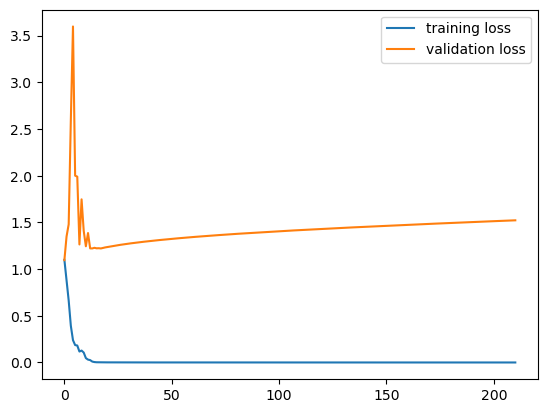

cd4
5637


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2678 loss_val: 1.5530 time: 10.0676s
 Epoch: 0010 loss_train: 0.2311 loss_val: 1.7344 time: 9.2881s
 Epoch: 0020 loss_train: 0.0079 loss_val: 1.7951 time: 9.9006s
 Epoch: 0030 loss_train: 0.0012 loss_val: 1.8623 time: 11.1560s
 Epoch: 0040 loss_train: 0.0009 loss_val: 1.9017 time: 10.6664s
 Epoch: 0050 loss_train: 0.0007 loss_val: 1.9323 time: 8.4642s
 Epoch: 0060 loss_train: 0.0006 loss_val: 1.9604 time: 9.5480s
 Epoch: 0070 loss_train: 0.0006 loss_val: 1.9856 time: 10.0000s
 Epoch: 0080 loss_train: 0.0005 loss_val: 2.0095 time: 9.5156s
 Epoch: 0090 loss_train: 0.0005 loss_val: 2.0276 time: 8.4319s
 Epoch: 0100 loss_train: 0.0004 loss_val: 2.0539 time: 8.8796s
 Epoch: 0110 loss_train: 0.0004 loss_val: 2.0692 time: 9.7932s
 Epoch: 0120 loss_train: 0.0004 loss_val: 2.0863 time: 7.8438s
 Epoch: 0130 loss_train: 0.0004 loss_val: 2.1028 time: 10.0118s
 Epoch: 0140 loss_train: 0.0004 loss_val: 2.1210 time: 9.3014s
 Epoch: 0150 loss_train: 0.0004 loss_val: 2.1253 t

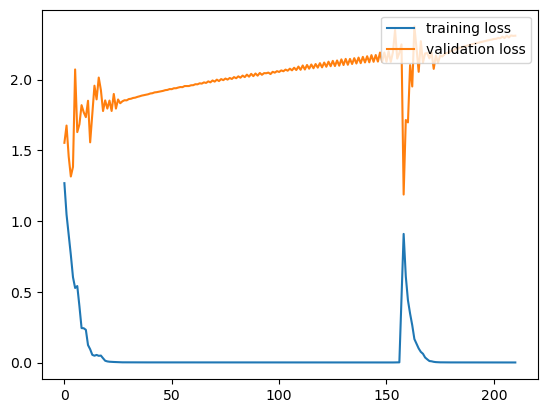

cd8
5659


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.3000 loss_val: 1.7566 time: 9.6089s
 Epoch: 0010 loss_train: 0.0881 loss_val: 2.1338 time: 10.0441s
 Epoch: 0020 loss_train: 0.0049 loss_val: 1.8492 time: 10.1793s
 Epoch: 0030 loss_train: 0.0012 loss_val: 1.9102 time: 10.5587s
 Epoch: 0040 loss_train: 0.0005 loss_val: 1.9607 time: 9.8302s
 Epoch: 0050 loss_train: 0.0004 loss_val: 2.0012 time: 10.3445s
 Epoch: 0060 loss_train: 0.0003 loss_val: 2.0356 time: 9.1965s
 Epoch: 0070 loss_train: 0.0002 loss_val: 2.0659 time: 9.8505s
 Epoch: 0080 loss_train: 0.0002 loss_val: 2.0936 time: 8.6188s
 Epoch: 0090 loss_train: 0.0001 loss_val: 2.1190 time: 9.8723s
 Epoch: 0100 loss_train: 0.0001 loss_val: 2.1428 time: 10.9250s
 Epoch: 0110 loss_train: 0.0001 loss_val: 2.1654 time: 7.4076s
 Epoch: 0120 loss_train: 0.0001 loss_val: 2.1872 time: 8.5894s
 Epoch: 0130 loss_train: 0.0001 loss_val: 2.2081 time: 10.4671s
 Epoch: 0140 loss_train: 0.0001 loss_val: 2.2284 time: 10.4248s
 Epoch: 0150 loss_train: 0.0001 loss_val: 2.2481

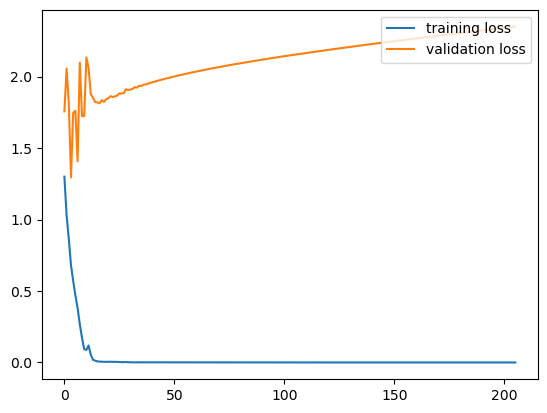

gh2ax
4938


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.2796 loss_val: 1.6118 time: 9.2144s
 Epoch: 0010 loss_train: 0.0036 loss_val: 1.3472 time: 8.9193s
 Epoch: 0020 loss_train: 0.0011 loss_val: 1.4120 time: 10.1141s
 Epoch: 0030 loss_train: 0.0006 loss_val: 1.4556 time: 9.8420s
 Epoch: 0040 loss_train: 0.0004 loss_val: 1.4893 time: 8.9006s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.5171 time: 7.6269s
 Epoch: 0060 loss_train: 0.0002 loss_val: 1.5413 time: 7.4809s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.5631 time: 8.3070s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.5826 time: 7.6563s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.6009 time: 7.6381s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.6178 time: 8.2064s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.6340 time: 9.1099s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.6493 time: 6.6029s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.6640 time: 8.3142s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.6782 time: 9.3239s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.6919 time:

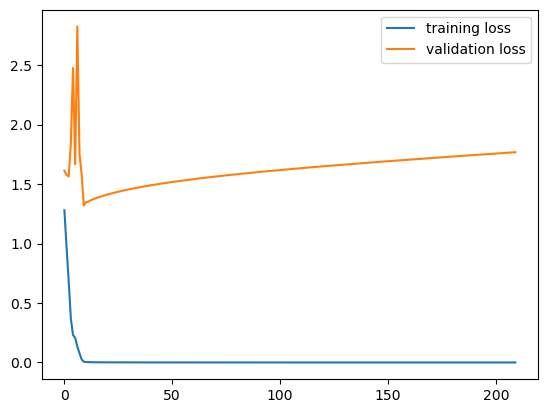

lamin
4939


/tmp/ipykernel_1554935/3258373865.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554935/3258373865.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.3363 loss_val: 1.4167 time: 8.8366s
 Epoch: 0010 loss_train: 0.0419 loss_val: 1.5350 time: 8.2828s
 Epoch: 0020 loss_train: 0.0018 loss_val: 1.3069 time: 9.5532s
 Epoch: 0030 loss_train: 0.0007 loss_val: 1.3409 time: 7.6490s
 Epoch: 0040 loss_train: 0.0005 loss_val: 1.3707 time: 7.7900s
 Epoch: 0050 loss_train: 0.0003 loss_val: 1.3954 time: 8.9027s
 Epoch: 0060 loss_train: 0.0003 loss_val: 1.4167 time: 7.6908s
 Epoch: 0070 loss_train: 0.0002 loss_val: 1.4359 time: 8.6599s
 Epoch: 0080 loss_train: 0.0002 loss_val: 1.4532 time: 9.6675s
 Epoch: 0090 loss_train: 0.0001 loss_val: 1.4694 time: 8.1707s
 Epoch: 0100 loss_train: 0.0001 loss_val: 1.4844 time: 8.9524s
 Epoch: 0110 loss_train: 0.0001 loss_val: 1.4987 time: 8.5789s
 Epoch: 0120 loss_train: 0.0001 loss_val: 1.5122 time: 8.5916s
 Epoch: 0130 loss_train: 0.0001 loss_val: 1.5252 time: 8.7580s
 Epoch: 0140 loss_train: 0.0001 loss_val: 1.5377 time: 8.0599s
 Epoch: 0150 loss_train: 0.0001 loss_val: 1.5499 time: 

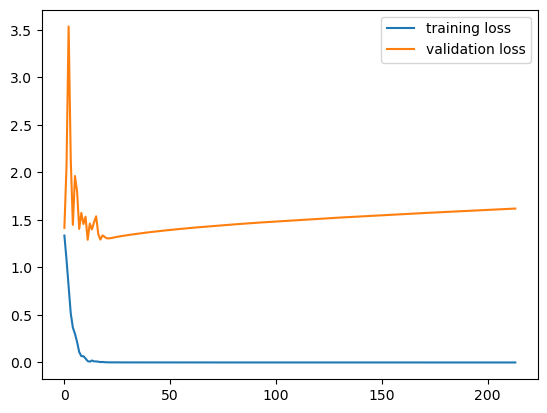

In [12]:
for sample_s in range(prevSampled,nSamples):
    print(sample_s)
    imgsC_all_samples_s=None
    imgsP_all_samples_s=None
    imgNames_all_samples_s=None
    proteinNames_samples_s=None
    pID_all_samples_s=None
    conditions_all_samples_s=None
    
    imgsC_all_val_samples_s={}
    imgsP_all_val_samples_s={}
    imgNames_all_val_samples_s={}
    proteinTrainInput_val_samples_s={}
    pID_all_val_samples_s={}
    conditions_all_val_samples_s={}
    for condition_i in conditions:
        print(condition_i)
        segDir_i=os.path.join(segDir,condition_i)
        imgDir_i=os.path.join(imgDir,condition_i)
        for stain in os.listdir(segDir_i):
            print(stain)
            segDir_i_stain=os.path.join(segDir_i,stain)
            imgDir_i_stain=os.path.join(imgDir_i,stain)

            segPID2name={}
            for pID_dir in os.listdir(segDir_i_stain):
                pID=pID_dir.split('_')
                segPID2name[pID[0]]=pID_dir
            imgPID2name={}
            for pID_dir in os.listdir(imgDir_i_stain):
                pID=pID_dir.split('_')
                imgPID2name[pID[0]]=pID_dir
            for pID in segPID2name.keys():
                if condition_i=='meningioma' and stain=='dapi_gh2ax_lamin_cd3' and pID=='P33': #skipping incorrect images
                    continue
                if pID in holdOutSamples_samples[sample_s%6]:
                    print('hold out: '+pID)
                    continue
                print(pID)
                if pID not in imgPID2name:
                    print('img not found '+pID)
                    continue
                imgDir_i_stain_p=os.path.join(imgDir_i_stain,imgPID2name[pID])
                segDir_i_stain_p=os.path.join(segDir_i_stain,segPID2name[pID])

                with open(os.path.join(imgDir_i_stain_p,savename+'_imgNames'), 'rb') as output:
                    imgNames=pickle.load(output)
                with open(os.path.join(imgDir_i_stain_p,savename+'_img'), 'rb') as output:
                    img=pickle.load(output)

                imgP=np.zeros((img.shape[0],1,img.shape[2],img.shape[3]))
                proteinNames_curr=np.array([])
                stain_list=stain.split('_')
                nImgPerStain=int(img.shape[0]/(len(stain_list)-1))
                np.random.seed(sample_s+6)
                allIdx_all=np.arange(img.shape[0])
                np.random.shuffle(allIdx_all)
                for s in range(1,len(stain_list)):
                    s_start=(s-1)*nImgPerStain
                    if s==len(stain_list)-1:
                        s_end=img.shape[0]
                    else:
                        s_end=s*nImgPerStain
                    imgP[s_start:s_end]=img[allIdx_all[s_start:s_end],s].reshape(s_end-s_start,1,img.shape[2],img.shape[3])
                    proteinNames_curr=np.concatenate((proteinNames_curr,np.repeat(stain_list[s],s_end-s_start)))

                    #store other channels for validation
                    for sother in range(1,len(stain_list)):
                        if sother==s:
                            continue
                        if stain_list[sother] not in imgsP_all_val_samples_s.keys():
                            proteinTrainInput_val_samples_s[stain_list[sother]]=np.repeat(stain_list[s],s_end-s_start)
                            pID_all_val_samples_s[stain_list[sother]]=np.repeat(pID,s_end-s_start)
                            imgsC_all_val_samples_s[stain_list[sother]]=img[allIdx_all[s_start:s_end],0].reshape(s_end-s_start,1,img.shape[2],img.shape[3])
                            imgNames_all_val_samples_s[stain_list[sother]]=imgNames[allIdx_all[s_start:s_end]]
                            imgsP_all_val_samples_s[stain_list[sother]]=img[allIdx_all[s_start:s_end],sother].reshape(s_end-s_start,1,img.shape[2],img.shape[3])
                            conditions_all_val_samples_s[stain_list[sother]]=np.repeat(condition_i,s_end-s_start)
                        else:
                            proteinTrainInput_val_samples_s[stain_list[sother]]=np.concatenate((proteinTrainInput_val_samples_s[stain_list[sother]],np.repeat(stain_list[s],s_end-s_start)))
                            pID_all_val_samples_s[stain_list[sother]]=np.concatenate((pID_all_val_samples_s[stain_list[sother]],np.repeat(pID,s_end-s_start)))
                            imgsC_all_val_samples_s[stain_list[sother]]=np.concatenate((imgsC_all_val_samples_s[stain_list[sother]],img[allIdx_all[s_start:s_end],0].reshape(s_end-s_start,1,img.shape[2],img.shape[3])),axis=0)
                            imgNames_all_val_samples_s[stain_list[sother]]=np.concatenate((imgNames_all_val_samples_s[stain_list[sother]],imgNames[allIdx_all[s_start:s_end]]))
                            imgsP_all_val_samples_s[stain_list[sother]]=np.concatenate((imgsP_all_val_samples_s[stain_list[sother]],img[allIdx_all[s_start:s_end],sother].reshape(s_end-s_start,1,img.shape[2],img.shape[3])),axis=0)
                            conditions_all_val_samples_s[stain_list[sother]]=np.concatenate((conditions_all_val_samples_s[stain_list[sother]],np.repeat(condition_i,s_end-s_start)))
                if pID_all_samples_s is None:
                    pID_all_samples_s=np.repeat(pID,img.shape[0])
                    imgsC_all_samples_s=img[allIdx_all,[0]]
                    imgNames_all_samples_s=imgNames[allIdx_all]
                    proteinNames_samples_s=proteinNames_curr
                    imgsP_all_samples_s=imgP
                    conditions_all_samples_s=np.repeat(condition_i,img.shape[0])
                else:
                    pID_all_samples_s=np.concatenate((pID_all_samples_s,np.repeat(pID,img.shape[0])))
                    imgsC_all_samples_s=np.concatenate((imgsC_all_samples_s,img[allIdx_all,[0]]),axis=0)
                    imgNames_all_samples_s=np.concatenate((imgNames_all_samples_s,imgNames[allIdx_all]))
                    proteinNames_samples_s=np.concatenate((proteinNames_samples_s,proteinNames_curr))
                    imgsP_all_samples_s=np.concatenate((imgsP_all_samples_s,imgP),axis=0)
                    conditions_all_samples_s=np.concatenate((conditions_all_samples_s,np.repeat(condition_i,img.shape[0])))
    imgsC_all_samples_s=imgsC_all_samples_s.reshape(imgsC_all_samples_s.shape[0],1,imgsC_all_samples_s.shape[1],imgsC_all_samples_s.shape[2])
    
    
    print(sample_s)
    nProt=np.unique(proteinNames_samples_s).size
    pnames,revIdx,pCounts=np.unique(proteinNames_samples_s,return_inverse=True,return_counts=True)
    plabels=torch.tensor(np.arange(pnames.size)[revIdx]).long()
    
    for p_curr in np.unique(proteinNames_samples_s):
        print(p_curr)
        print(np.sum(proteinNames_samples_s==p_curr))

        logsavepath_train_curr=os.path.join(logsavepath_train,p_curr)
        modelsavepath_train_curr=os.path.join(modelsavepath_train,p_curr)
        plotsavepath_train_curr=os.path.join(plotsavepath_train,p_curr)
        if not os.path.exists(logsavepath_train_curr):
            os.mkdir(logsavepath_train_curr)
        if not os.path.exists(modelsavepath_train_curr):
            os.mkdir(modelsavepath_train_curr)
        if not os.path.exists(plotsavepath_train_curr):
            os.mkdir(plotsavepath_train_curr)
        logsavepath_train_curr=os.path.join(logsavepath_train,p_curr,str(sample_s+6))
        modelsavepath_train_curr=os.path.join(modelsavepath_train,p_curr,str(sample_s+6))
        plotsavepath_train_curr=os.path.join(plotsavepath_train,p_curr,str(sample_s+6))
        if not os.path.exists(logsavepath_train_curr):
            os.mkdir(logsavepath_train_curr)
        if not os.path.exists(modelsavepath_train_curr):
            os.mkdir(modelsavepath_train_curr)
        if not os.path.exists(plotsavepath_train_curr):
            os.mkdir(plotsavepath_train_curr)

        imgsP_all_curr=imgsP_all_samples_s[proteinNames_samples_s==p_curr]
        imgsC_all_curr=imgsC_all_samples_s[proteinNames_samples_s==p_curr]
        conditions_all_curr=conditions_all_samples_s[proteinNames_samples_s==p_curr]
        cnames,revIdx_c,cCounts=np.unique(conditions_all_curr,return_inverse=True,return_counts=True)
        clfWeight=1/cCounts
        clfWeight=clfWeight/np.sum(clfWeight)
        loss_clf=torch.nn.CrossEntropyLoss(weight=torch.tensor(clfWeight).cuda().float())
        cnames_val,revIdx_c_val,cCounts_val=np.unique(conditions_all_val_samples_s[p_curr],return_inverse=True,return_counts=True)

        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.enabled = True
        if modelname_train=='resnet18':
            model=torchvision.models.resnet18(num_classes=cnames.size)
            model.conv1=torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) #change to one input channel
        elif modelname_train=='alexnet':
            model=torchvision.models.alexnet(num_classes=cnames.size)
            model.features[0]=torch.nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
        elif modelname_train=='cnn_base':
            model=model_clf.cnn_clf.CNN_VAE_clf(4, 2, 1, 1, 64,128,256,256,96, 96*4*4,64,cnames.size)
        model.cuda()
        optimizer_clf = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        #c2p - train samples
        starget_index=pnames.tolist().index(p_curr)
        plabels=torch.tensor(np.repeat(starget_index,imgsC_all_curr.shape[0])).long()
        valIdx=np.arange(imgsC_all_curr.shape[0])
        c2p_res_train=np.zeros_like(imgsC_all_curr)
        with torch.no_grad():
            nvalBatches=int(np.ceil(valIdx.shape[0]/batchsize))
            for i in range(nvalBatches):
                valIdx_i=valIdx[i*batchsize:min((i+1)*batchsize,valIdx.shape[0])]
                valtarget_dna=torch.tensor(imgsC_all_curr[valIdx_i]).cuda().float()
                valInput_ID=plabels[valIdx_i].cuda()
                valIdx_i=torch.tensor(valIdx_i)

                reconShared_dna_l,recon_dna_l= modelcnn_dna(valtarget_dna,valInput_ID)

                reconShared_protein=modelcnn_pShared_dec(reconShared_dna_l,pIDemb_dec(valInput_ID))
                c2p_res_train[valIdx_i]=reconShared_protein.cpu().numpy()

        #c2p - validation samples
        imgP_c2p_target=imgsP_all_val_samples_s[p_curr]
        imgC_c2p_input=imgsC_all_val_samples_s[p_curr]
        starget_index=pnames.tolist().index(p_curr)
        plabels=torch.tensor(np.repeat(starget_index,imgP_c2p_target.shape[0])).long()
        valIdx=np.arange(imgP_c2p_target.shape[0])

        c2p_res=np.zeros_like(imgP_c2p_target)
        with torch.no_grad():
            nvalBatches=int(np.ceil(valIdx.shape[0]/batchsize))
            for i in range(nvalBatches):
                valIdx_i=valIdx[i*batchsize:min((i+1)*batchsize,valIdx.shape[0])]
                valtarget_dna=torch.tensor(imgC_c2p_input[valIdx_i]).cuda().float()
                valInput_ID=plabels[valIdx_i].cuda()
                valIdx_i=torch.tensor(valIdx_i)

                reconShared_dna_l,recon_dna_l= modelcnn_dna(valtarget_dna,valInput_ID)

                reconShared_protein=modelcnn_pShared_dec(reconShared_dna_l,pIDemb_dec(valInput_ID))
                c2p_res[valIdx_i]=reconShared_protein.cpu().numpy()


        #train classifier
        train_loss=[np.inf]*epochs
        val_loss=[np.inf]*epochs

        t_ep=time.time()

        epCounts=0
        for ep in range(epochs):
            train_loss[ep],val_loss[ep]=train(ep,model,optimizer_clf,c2p_res_train,c2p_res,torch.tensor(revIdx_c),torch.tensor(revIdx_c_val))

            if ep>50 and val_loss[ep]>=val_loss[ep-50]:
                epCounts+=1

            if epCounts>150:
                break


            if ep%saveFreq == (saveFreq-1):
                torch.save(model.cpu().state_dict(), os.path.join(modelsavepath_train_curr,'ep'+str(ep)+'.pt'))


            model.cuda()
            torch.cuda.empty_cache()
        print(' total time: {:.4f}s'.format(time.time() - t_ep))


        with open(os.path.join(logsavepath_train_curr,'train_loss'), 'wb') as output:
            pickle.dump(train_loss, output, pickle.HIGHEST_PROTOCOL)
        with open(os.path.join(logsavepath_train_curr,'val_loss'), 'wb') as output:
            pickle.dump(val_loss, output, pickle.HIGHEST_PROTOCOL)


        plt.plot(np.arange(epochs),train_loss)
        plt.plot(np.arange(epochs),val_loss)
        plt.legend(['training loss','validation loss'],loc='upper right')
        plt.savefig(os.path.join(plotsavepath_train_curr,'loss_seed3.jpg'))
        plt.show()


### validation samples

In [13]:
for p_curr in np.unique(proteinNames_samples_s):
    print(p_curr)
    nconditions=np.unique(conditions_all_samples_s[proteinNames_samples_s==p_curr]).size
    res_val=np.zeros((nSamples,nconditions,nconditions))
    correctCount_val=[None]*nSamples
    
    for sample_s in range(nSamples):
        imgsC_all_samples_s=None
        imgsP_all_samples_s=None
        imgNames_all_samples_s=None
        proteinNames_samples_s=None
        pID_all_samples_s=None
        conditions_all_samples_s=None

        imgsC_all_val_samples_s={}
        imgsP_all_val_samples_s={}
        imgNames_all_val_samples_s={}
        proteinTrainInput_val_samples_s={}
        pID_all_val_samples_s={}
        conditions_all_val_samples_s={}
        for condition_i in conditions:
            print(condition_i)
            segDir_i=os.path.join(segDir,condition_i)
            imgDir_i=os.path.join(imgDir,condition_i)
            for stain in os.listdir(segDir_i):
                print(stain)
                segDir_i_stain=os.path.join(segDir_i,stain)
                imgDir_i_stain=os.path.join(imgDir_i,stain)

                segPID2name={}
                for pID_dir in os.listdir(segDir_i_stain):
                    pID=pID_dir.split('_')
                    segPID2name[pID[0]]=pID_dir
                imgPID2name={}
                for pID_dir in os.listdir(imgDir_i_stain):
                    pID=pID_dir.split('_')
                    imgPID2name[pID[0]]=pID_dir
                for pID in segPID2name.keys():
                    if condition_i=='meningioma' and stain=='dapi_gh2ax_lamin_cd3' and pID=='P33': #skipping incorrect images
                        continue
                    if pID in holdOutSamples_samples[sample_s%6]:
                        print('hold out: '+pID)
                        continue
                    print(pID)
                    if pID not in imgPID2name:
                        print('img not found '+pID)
                        continue
                    imgDir_i_stain_p=os.path.join(imgDir_i_stain,imgPID2name[pID])
                    segDir_i_stain_p=os.path.join(segDir_i_stain,segPID2name[pID])

                    with open(os.path.join(imgDir_i_stain_p,savename+'_imgNames'), 'rb') as output:
                        imgNames=pickle.load(output)
                    with open(os.path.join(imgDir_i_stain_p,savename+'_img'), 'rb') as output:
                        img=pickle.load(output)

                    imgP=np.zeros((img.shape[0],1,img.shape[2],img.shape[3]))
                    proteinNames_curr=np.array([])
                    stain_list=stain.split('_')
                    nImgPerStain=int(img.shape[0]/(len(stain_list)-1))
                    np.random.seed(sample_s+6)
                    allIdx_all=np.arange(img.shape[0])
                    np.random.shuffle(allIdx_all)
                    for s in range(1,len(stain_list)):
                        s_start=(s-1)*nImgPerStain
                        if s==len(stain_list)-1:
                            s_end=img.shape[0]
                        else:
                            s_end=s*nImgPerStain
                        imgP[s_start:s_end]=img[allIdx_all[s_start:s_end],s].reshape(s_end-s_start,1,img.shape[2],img.shape[3])
                        proteinNames_curr=np.concatenate((proteinNames_curr,np.repeat(stain_list[s],s_end-s_start)))

                        #store other channels for validation
                        for sother in range(1,len(stain_list)):
                            if sother==s:
                                continue
                            if stain_list[sother] not in imgsP_all_val_samples_s.keys():
                                proteinTrainInput_val_samples_s[stain_list[sother]]=np.repeat(stain_list[s],s_end-s_start)
                                pID_all_val_samples_s[stain_list[sother]]=np.repeat(pID,s_end-s_start)
                                imgsC_all_val_samples_s[stain_list[sother]]=img[allIdx_all[s_start:s_end],0].reshape(s_end-s_start,1,img.shape[2],img.shape[3])
                                imgNames_all_val_samples_s[stain_list[sother]]=imgNames[allIdx_all[s_start:s_end]]
                                imgsP_all_val_samples_s[stain_list[sother]]=img[allIdx_all[s_start:s_end],sother].reshape(s_end-s_start,1,img.shape[2],img.shape[3])
                                conditions_all_val_samples_s[stain_list[sother]]=np.repeat(condition_i,s_end-s_start)
                            else:
                                proteinTrainInput_val_samples_s[stain_list[sother]]=np.concatenate((proteinTrainInput_val_samples_s[stain_list[sother]],np.repeat(stain_list[s],s_end-s_start)))
                                pID_all_val_samples_s[stain_list[sother]]=np.concatenate((pID_all_val_samples_s[stain_list[sother]],np.repeat(pID,s_end-s_start)))
                                imgsC_all_val_samples_s[stain_list[sother]]=np.concatenate((imgsC_all_val_samples_s[stain_list[sother]],img[allIdx_all[s_start:s_end],0].reshape(s_end-s_start,1,img.shape[2],img.shape[3])),axis=0)
                                imgNames_all_val_samples_s[stain_list[sother]]=np.concatenate((imgNames_all_val_samples_s[stain_list[sother]],imgNames[allIdx_all[s_start:s_end]]))
                                imgsP_all_val_samples_s[stain_list[sother]]=np.concatenate((imgsP_all_val_samples_s[stain_list[sother]],img[allIdx_all[s_start:s_end],sother].reshape(s_end-s_start,1,img.shape[2],img.shape[3])),axis=0)
                                conditions_all_val_samples_s[stain_list[sother]]=np.concatenate((conditions_all_val_samples_s[stain_list[sother]],np.repeat(condition_i,s_end-s_start)))
                    if pID_all_samples_s is None:
                        pID_all_samples_s=np.repeat(pID,img.shape[0])
                        imgsC_all_samples_s=img[allIdx_all,[0]]
                        imgNames_all_samples_s=imgNames[allIdx_all]
                        proteinNames_samples_s=proteinNames_curr
                        imgsP_all_samples_s=imgP
                        conditions_all_samples_s=np.repeat(condition_i,img.shape[0])
                    else:
                        pID_all_samples_s=np.concatenate((pID_all_samples_s,np.repeat(pID,img.shape[0])))
                        imgsC_all_samples_s=np.concatenate((imgsC_all_samples_s,img[allIdx_all,[0]]),axis=0)
                        imgNames_all_samples_s=np.concatenate((imgNames_all_samples_s,imgNames[allIdx_all]))
                        proteinNames_samples_s=np.concatenate((proteinNames_samples_s,proteinNames_curr))
                        imgsP_all_samples_s=np.concatenate((imgsP_all_samples_s,imgP),axis=0)
                        conditions_all_samples_s=np.concatenate((conditions_all_samples_s,np.repeat(condition_i,img.shape[0])))
        imgsC_all_samples_s=imgsC_all_samples_s.reshape(imgsC_all_samples_s.shape[0],1,imgsC_all_samples_s.shape[1],imgsC_all_samples_s.shape[2])


        print(sample_s)
        nProt=np.unique(proteinNames_samples_s).size
        pnames,revIdx,pCounts=np.unique(proteinNames_samples_s,return_inverse=True,return_counts=True)
        plabels=torch.tensor(np.arange(pnames.size)[revIdx]).long()

        plotsavepath_train_p=os.path.join(plotsavepath_train,p_curr)
        
        logsavepath_train_curr=os.path.join(logsavepath_train,p_curr,str(sample_s+6))
        modelsavepath_train_curr=os.path.join(modelsavepath_train,p_curr,str(sample_s+6))
        plotsavepath_train_curr=os.path.join(plotsavepath_train,p_curr,str(sample_s+6))

        imgsP_all_curr=imgsP_all_samples_s[proteinNames_samples_s==p_curr]
        conditions_all_curr=conditions_all_samples_s[proteinNames_samples_s==p_curr]
        cnames,revIdx_c,cCounts=np.unique(conditions_all_curr,return_inverse=True,return_counts=True)
        clfWeight=1/cCounts
        clfWeight=clfWeight/np.sum(clfWeight)
        loss_clf=torch.nn.CrossEntropyLoss(weight=torch.tensor(clfWeight).cuda().float())
        cnames_val,revIdx_c_val,cCounts_val=np.unique(conditions_all_val_samples_s[p_curr],return_inverse=True,return_counts=True)


        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.enabled = True
        if modelname_train=='resnet18':
            model=torchvision.models.resnet18(num_classes=cnames.size)
            model.conv1=torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) #change to one input channel
        elif modelname_train=='alexnet':
            model=torchvision.models.alexnet(num_classes=cnames.size)
            model.features[0]=torch.nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
        elif modelname_train=='cnn_base':
            model=model_clf.cnn_clf.CNN_VAE_clf(4, 2, 1, 1, 64,128,256,256,96, 96*4*4,64,cnames.size)

        model.cuda()

        with open(os.path.join(logsavepath_train_curr,'val_loss'), 'rb') as output:
            val_loss=pickle.load(output)
        minlossepoch=np.argmin(val_loss)
        minlossepoch_saved=int(np.round(minlossepoch/saveFreq)*saveFreq)-1
        if minlossepoch_saved==-1:
            minlossepoch_saved=saveFreq-1
        if val_loss[minlossepoch_saved-saveFreq]<val_loss[minlossepoch_saved]:
            if val_loss[minlossepoch_saved+saveFreq]<val_loss[minlossepoch_saved-saveFreq]:
                minlossepoch_saved=minlossepoch_saved+saveFreq
            else:
                minlossepoch_saved=minlossepoch_saved-saveFreq
        if minlossepoch_saved==-1:
            minlossepoch_saved=saveFreq-1
        model.load_state_dict(torch.load(os.path.join(modelsavepath_train_curr,'ep'+str(minlossepoch_saved)+'.pt')))



        #c2p - validation samples
        imgP_c2p_target=imgsP_all_val_samples_s[p_curr]
        imgC_c2p_input=imgsC_all_val_samples_s[p_curr]
        starget_index=pnames.tolist().index(p_curr)
        plabels=torch.tensor(np.repeat(starget_index,imgP_c2p_target.shape[0])).long()
        valIdx=np.arange(imgP_c2p_target.shape[0])

        c2p_res=np.zeros_like(imgP_c2p_target)
        with torch.no_grad():
            nvalBatches=int(np.ceil(valIdx.shape[0]/batchsize))
            for i in range(nvalBatches):
                valIdx_i=valIdx[i*batchsize:min((i+1)*batchsize,valIdx.shape[0])]
                valtarget_dna=torch.tensor(imgC_c2p_input[valIdx_i]).cuda().float()
                valInput_ID=plabels[valIdx_i].cuda()
                valIdx_i=torch.tensor(valIdx_i)

                reconShared_dna_l,recon_dna_l= modelcnn_dna(valtarget_dna,valInput_ID)

                reconShared_protein=modelcnn_pShared_dec(reconShared_dna_l,pIDemb_dec(valInput_ID))
                c2p_res[valIdx_i]=reconShared_protein.cpu().numpy()

        #validation samples - c2p results
        with torch.no_grad():
            model.eval()
            loss_val_all=0
            valIdx=np.arange(revIdx_c_val.size)
            nvalBatches=int(np.ceil(valIdx.shape[0]/batchsize))
            pred_curr_c2p=np.array([])
            for i in range(nvalBatches):
                valIdx_i=valIdx[i*batchsize:min((i+1)*batchsize,valIdx.shape[0])]
                val_labels=torch.tensor(revIdx_c_val[valIdx_i]).cuda().long()
                valInput=torch.tensor(c2p_res[valIdx_i]).cuda().float()


                pred = model(valInput)

                loss=loss_clf(pred, val_labels)
                loss_val_all+=loss.item()
                pred_curr_c2p=np.concatenate((pred_curr_c2p,np.argmax(pred.detach().cpu().numpy(),axis=1)))

            loss_val_all=loss_val_all/nvalBatches

        print('loss_val: {:.4f}'.format(loss_val_all))
        correctCount=np.sum(pred_curr_c2p==revIdx_c_val)/pred_curr_c2p.size
        print('acc: {:.4f}'.format(correctCount))

        correctCount_val[sample_s]=correctCount
        pred_curr_c2p=pred_curr_c2p.astype(int)
    #     pred_curr_target=pred_curr_target.astype(int)
        res_val[sample_s]=plotCTcomp(cnames[revIdx_c_val],cnames[pred_curr_c2p],plotsavepath_train_curr,'confusion_val_c2p_moreSamples',False,addname='',ctorder=None,vmin=0,vmax=1)
       
    print('avg val acc: {:.4f}'.format(np.mean(correctCount_val)))
    with open(os.path.join(plotsavepath_train_p,'acc_val_moreSamples'), 'wb') as output:
        pickle.dump(correctCount_val, output, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(plotsavepath_train_p,'confusion_val_moreSamples'), 'wb') as output:
        pickle.dump(res_val, output, pickle.HIGHEST_PROTOCOL)




cd16
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
hold out: HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
hold out: HV1
HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
hold out: P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
P59
hold out: P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
hold out: P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
hold out: P22
P68
P16
P84
P15
0
loss_val: 2.2883
acc: 0.4571
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
hold out: HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
hold out: HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
P55
P50
hold out: P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
P63
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
dapi_cd16_cd4_cd

hold out: HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
P55
P50
hold out: P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
P63
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
hold out: P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
hold out: P46
P47
P29
P52
P57
P22
P68
P16
P84
P15
13
loss_val: 2.2270
acc: 0.4696
controls
dapi_gh2ax_lamin
hold out: HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
hold out: HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
hold out: P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
P15
P29
im

P56
P72
P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
hold out: P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
hold out: P68
P16
P84
P15
26
loss_val: 2.2472
acc: 0.4318
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
hold out: HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
hold out: HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
hold out: P55
P50
P24
dapi_cd16_cd4_cd8
hold out: P55
P56
P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
hold out: P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
hold out: P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
hold out: P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
P68
P16
P84
hold out: P15
27
loss_val: 2.1493
ac

P83
P42
hold out: P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
hold out: P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
hold out: P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
P68
P16
P84
hold out: P15
3
loss_val: 1.3088
acc: 0.6327
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
hold out: HV8
HV3
HV6
dapi_cd8_cd4
HV1
hold out: HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
hold out: P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
hold out: P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
hold out: P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
hold out: P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
hold out: P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
hold out: P47
P29
P52
P57
P22
P68
P16
P84
P15
4
loss_val: 1.2897
acc: 0.6485
controls
dapi_gh2ax_lamin
HV5
HV4
hold out: HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
d

P84
hold out: P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
hold out: P47
P29
P52
P57
P22
P68
P16
P84
P15
16
loss_val: 1.2760
acc: 0.6559
controls
dapi_gh2ax_lamin
HV5
HV4
hold out: HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
HV3
hold out: HV2
headneck
dapi_gh2ax_lamin_cd3
hold out: P72
P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
hold out: P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
hold out: P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
hold out: P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
hold out: P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
hold out: P57
P22
P68
P16
P84
P15
17
loss_val: 1.3237
acc: 0.6347
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
hold out: HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
hold out: HV1
HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_

P16
P84
P15
29
loss_val: 1.2974
acc: 0.6344
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
hold out: HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
hold out: HV1
HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
hold out: P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
P59
hold out: P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
hold out: P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
hold out: P22
P68
P16
P84
P15
30
loss_val: 1.3413
acc: 0.6656
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
hold out: HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
hold out: HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
P55
P50
hold out: P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
P63
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
P3

HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
hold out: HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
hold out: P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
hold out: P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
hold out: P68
P16
P84
P15
8
loss_val: 2.1319
acc: 0.4373
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
hold out: HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
hold out: HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
hold out: P55
P50
P24
dapi_cd16_cd4_cd8
hold out: P55
P56
P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
hold out: P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
hold out: P59
P27
glioma
dap

P63
P14
P44
P41
P56
P18
hold out: P55
P50
P24
dapi_cd16_cd4_cd8
hold out: P55
P56
P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
hold out: P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
hold out: P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
hold out: P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
P68
P16
P84
hold out: P15
21
loss_val: 2.0732
acc: 0.4828
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
hold out: HV8
HV3
HV6
dapi_cd8_cd4
HV1
hold out: HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
hold out: P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
hold out: P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
hold out: P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
hold out: P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
hold out: P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46


P24
meningioma
dapi_gh2ax_lamin_cd3
P27
hold out: P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
hold out: P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
hold out: P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
hold out: P47
P29
P52
P57
P22
P68
P16
P84
P15
34
loss_val: 2.3277
acc: 0.4743
controls
dapi_gh2ax_lamin
HV5
HV4
hold out: HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
HV3
hold out: HV2
headneck
dapi_gh2ax_lamin_cd3
hold out: P72
P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
hold out: P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
hold out: P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
hold out: P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
hold out: P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
hold out: P57
P22
P68
P16
P84
P15
35
loss_val: 2.0596
acc: 0.4652
avg val acc: 0.4676
cd8
controls

P48
P62
P38
hold out: P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
hold out: P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
hold out: P57
P22
P68
P16
P84
P15
11
loss_val: 2.0548
acc: 0.4718
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
hold out: HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
hold out: HV1
HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
hold out: P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
P59
hold out: P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
hold out: P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
hold out: P22
P68
P16
P84
P15
12
loss_val: 1.9901
acc: 0.4919
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
hold out: HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
hold out: HV3
HV2
head

P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
hold out: P22
P68
P16
P84
P15
24
loss_val: 2.1580
acc: 0.4943
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
hold out: HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
hold out: HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
P55
P50
hold out: P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
P63
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
hold out: P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
hold out: P46
P47
P29
P52
P57
P22
P68
P16
P84
P15
25
loss_val: 2.0068
acc: 0.4834
controls
dapi_gh2ax_lamin
hold out: HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
hold out: HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
hold out: P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P1

P22
P68
P16
P84
P15
1
loss_val: 1.3557
acc: 0.6474
controls
dapi_gh2ax_lamin
hold out: HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
hold out: HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
hold out: P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
hold out: P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
hold out: P68
P16
P84
P15
2
loss_val: 1.5169
acc: 0.6025
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
hold out: HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
hold out: HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
hold out: P55
P50
P24
dapi_cd16_cd4_cd8
hold out: P55
P56
P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42


HV6
hold out: HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
hold out: P55
P50
P24
dapi_cd16_cd4_cd8
hold out: P55
P56
P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
hold out: P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
hold out: P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
hold out: P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
P68
P16
P84
hold out: P15
15
loss_val: 1.4331
acc: 0.6216
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
hold out: HV8
HV3
HV6
dapi_cd8_cd4
HV1
hold out: HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
hold out: P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
hold out: P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
hold out: P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
hold out: P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
ho

P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
hold out: P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
hold out: P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
hold out: P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
hold out: P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
hold out: P47
P29
P52
P57
P22
P68
P16
P84
P15
28
loss_val: 1.4879
acc: 0.6124
controls
dapi_gh2ax_lamin
HV5
HV4
hold out: HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
HV3
hold out: HV2
headneck
dapi_gh2ax_lamin_cd3
hold out: P72
P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
hold out: P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
hold out: P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
hold out: P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
hold out: P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
hold out: P57
P22
P68
P16
P84


P56
P72
hold out: P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
P59
hold out: P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
hold out: P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
hold out: P22
P68
P16
P84
P15
6
loss_val: 1.2351
acc: 0.6607
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
hold out: HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
hold out: HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
P55
P50
hold out: P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
P63
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
hold out: P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
hold out: P46
P47
P29
P52
P57
P22
P68
P16
P84
P15
7
loss_val: 1.1728
acc:

dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
hold out: P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
hold out: P46
P47
P29
P52
P57
P22
P68
P16
P84
P15
19
loss_val: 1.2590
acc: 0.6636
controls
dapi_gh2ax_lamin
hold out: HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
hold out: HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
hold out: P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
hold out: P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
hold out: P68
P16
P84
P15
20
loss_val: 1.4090
acc: 0.6167
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
hold out: HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
hold out: HV

P22
P84
P47
P57
P15
P29
img not found P29
hold out: P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
hold out: P68
P16
P84
P15
32
loss_val: 1.3895
acc: 0.6267
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
hold out: HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
hold out: HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
hold out: P55
P50
P24
dapi_cd16_cd4_cd8
hold out: P55
P56
P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
hold out: P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
hold out: P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
hold out: P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
P68
P16
P84
hold out: P15
33
loss_val: 1.3889
acc: 0.6289
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
hold out: HV8
HV3
HV6
dapi_cd8_cd4
HV1
hold out: HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
hold out: P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_

In [16]:
for p_curr in np.unique(proteinNames_samples[0]):
    
    print(p_curr)

    nconditions=np.unique(conditions_all_samples[0][proteinNames_samples[0]==p_curr]).size
    res_heldout=np.zeros((nSamples,nconditions,nconditions))
    correctCount_heldout=[None]*nSamples
    
    for sample_s in range(nSamples):
        print(sample_s)
        
        plotsavepath_train_p=os.path.join(plotsavepath_train,p_curr)
        
        logsavepath_train_curr=os.path.join(logsavepath_train,p_curr,str(sample_s))
        modelsavepath_train_curr=os.path.join(modelsavepath_train,p_curr,str(sample_s))
        plotsavepath_train_curr=os.path.join(plotsavepath_train,p_curr,str(sample_s))
    
        imgsP_all_curr=imgsP_all_samples[sample_s][proteinNames_samples[sample_s]==p_curr]
        conditions_all_curr=conditions_all_samples[sample_s][proteinNames_samples[sample_s]==p_curr]
        cnames,revIdx_c,cCounts=np.unique(conditions_all_curr,return_inverse=True,return_counts=True)
        clfWeight=1/cCounts
        clfWeight=clfWeight/np.sum(clfWeight)
        loss_clf=torch.nn.CrossEntropyLoss(weight=torch.tensor(clfWeight).cuda().float())
        cnames_val,revIdx_c_val,cCounts_val=np.unique(conditions_val_allProt_samples[sample_s][p_curr],return_inverse=True,return_counts=True)


        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.enabled = True
        if modelname_train=='resnet18':
            model=torchvision.models.resnet18(num_classes=cnames.size)
            model.conv1=torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) #change to one input channel
        elif modelname_train=='alexnet':
            model=torchvision.models.alexnet(num_classes=cnames.size)
            model.features[0]=torch.nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
        elif modelname_train=='cnn_base':
            model=model_clf.cnn_clf.CNN_VAE_clf(4, 2, 1, 1, 64,128,256,256,96, 96*4*4,64,cnames.size)

        model.cuda()

        with open(os.path.join(logsavepath_train_curr,'val_loss'), 'rb') as output:
            val_loss=pickle.load(output)
        minlossepoch=np.argmin(val_loss)
        minlossepoch_saved=int(np.round(minlossepoch/saveFreq)*saveFreq)-1
        if minlossepoch_saved==-1:
            minlossepoch_saved=saveFreq-1
        if val_loss[minlossepoch_saved-saveFreq]<val_loss[minlossepoch_saved]:
            if val_loss[minlossepoch_saved+saveFreq]<val_loss[minlossepoch_saved-saveFreq]:
                minlossepoch_saved=minlossepoch_saved+saveFreq
            else:
                minlossepoch_saved=minlossepoch_saved-saveFreq
        if minlossepoch_saved==-1:
            minlossepoch_saved=saveFreq-1
        model.load_state_dict(torch.load(os.path.join(modelsavepath_train_curr,'ep'+str(minlossepoch_saved)+'.pt')))



        #c2p - validation samples
        imgP_c2p_target=imgsP_val_allProt_samples[sample_s][p_curr]
        imgC_c2p_input=imgsC_val_allProt_samples[sample_s][p_curr]
        starget_index=pnames.tolist().index(p_curr)
        plabels=torch.tensor(np.repeat(starget_index,imgP_c2p_target.shape[0])).long()
        valIdx=np.arange(imgP_c2p_target.shape[0])

        c2p_res=np.zeros_like(imgP_c2p_target)
        with torch.no_grad():
            nvalBatches=int(np.ceil(valIdx.shape[0]/batchsize))
            for i in range(nvalBatches):
                valIdx_i=valIdx[i*batchsize:min((i+1)*batchsize,valIdx.shape[0])]
                valtarget_dna=torch.tensor(imgC_c2p_input[valIdx_i]).cuda().float()
                valInput_ID=plabels[valIdx_i].cuda()
                valIdx_i=torch.tensor(valIdx_i)

                reconShared_dna_l,recon_dna_l= modelcnn_dna(valtarget_dna,valInput_ID)

                reconShared_protein=modelcnn_pShared_dec(reconShared_dna_l,pIDemb_dec(valInput_ID))
                c2p_res[valIdx_i]=reconShared_protein.cpu().numpy()


        #validation samples - c2p results
        with torch.no_grad():
            model.eval()
            loss_val_all=0
            valIdx=np.arange(revIdx_c_val.size)
            nvalBatches=int(np.ceil(valIdx.shape[0]/batchsize))
            pred_curr_c2p=np.array([])
            for i in range(nvalBatches):
                valIdx_i=valIdx[i*batchsize:min((i+1)*batchsize,valIdx.shape[0])]
                val_labels=torch.tensor(revIdx_c_val[valIdx_i]).cuda().long()
                valInput=torch.tensor(c2p_res[valIdx_i]).cuda().float()


                pred = model(valInput)

                loss=loss_clf(pred, val_labels)
                loss_val_all+=loss.item()
                pred_curr_c2p=np.concatenate((pred_curr_c2p,np.argmax(pred.detach().cpu().numpy(),axis=1)))

            loss_val_all=loss_val_all/nvalBatches

        print('loss_val: {:.4f}'.format(loss_val_all))
        correctCount=np.sum(pred_curr_c2p==revIdx_c_val)/pred_curr_c2p.size
        print('acc: {:.4f}'.format(correctCount))

        pred_curr_c2p=pred_curr_c2p.astype(int)
    #     pred_curr_target=pred_curr_target.astype(int)
        res_heldout[sample_s]=plotCTcomp(cnames[revIdx_c_val],cnames[pred_curr_c2p],plotsavepath_train_curr,'confusion_heldout_c2p',False,addname='',ctorder=None,vmin=0,vmax=1)
        correctCount_heldout[sample_s]=correctCount
    with open(os.path.join(plotsavepath_train_p,'acc_heldout'), 'wb') as output:
        pickle.dump(correctCount_heldout, output, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(plotsavepath_train_p,'confusion_heldout'), 'wb') as output:
        pickle.dump(res_heldout, output, pickle.HIGHEST_PROTOCOL)





cd16
0
loss_val: 3.8243
acc: 0.2737
1
loss_val: 3.4637
acc: 0.3394
2
loss_val: 1.9133
acc: 0.4966
3
loss_val: 3.2345
acc: 0.3219
4
loss_val: 3.0557
acc: 0.3580
5
loss_val: 4.4262
acc: 0.3065
cd3
0
loss_val: 2.8101
acc: 0.4597
1
loss_val: 2.7369
acc: 0.3906
2
loss_val: 1.3110
acc: 0.6669
3
loss_val: 1.4558
acc: 0.6471
4
loss_val: 1.4541
acc: 0.6236
5
loss_val: 1.2642
acc: 0.6883
cd4
0
loss_val: 5.0221
acc: 0.2503
1
loss_val: 2.8502
acc: 0.3765
2
loss_val: 1.8898
acc: 0.5147
3
loss_val: 3.2849
acc: 0.3183
4
loss_val: 2.7756
acc: 0.3854
5
loss_val: 3.0069
acc: 0.4035
cd8
0
loss_val: 3.1350
acc: 0.2979
1
loss_val: 2.7597
acc: 0.3833
2
loss_val: 1.8223
acc: 0.4902
3
loss_val: 2.3485
acc: 0.3095
4
loss_val: 1.3523
acc: 0.3987
5
loss_val: 3.8344
acc: 0.3806
gh2ax
0
loss_val: 3.0467
acc: 0.4501
1
loss_val: 3.1317
acc: 0.4172
2
loss_val: 1.3732
acc: 0.6609
3
loss_val: 1.5713
acc: 0.6138
4
loss_val: 1.4052
acc: 0.6412
5
loss_val: 1.1807
acc: 0.6972
lamin
0
loss_val: 2.9731
acc: 0.4842
1
loss_val